# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity misfit.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import plotting, regional, synthetic, uncertainty, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement. The gravity effect from the Moho will represent the **regional** which we are aiming to isolate. We will forward model the gravity effects of both layers, and add some noise, to create an observed gravity dataset. We will then use a series of point where we know the basement topography to create a starting model, forward calculate its gravity effect, and remove it from the observed gravity to get a gravity misfit. We will then demonstrate the range of techniques implemented within *Invert4Geom* for isolated the regional component of this gravity misfit.

In [2]:
# get topography data
grid = synthetic.load_bishop_model(coarsen_factor=20)

# extract grid spacing and region
spacing, buffer_region, _, _, _ = polar_utils.get_grid_info(
    grid.basement_topo, print_info=True
)

# get topography data
basement_topo = grid.basement_topo
moho_topo = grid.moho_topo

# create an inside region to reduce gravity edge effects
region = vd.pad_region(buffer_region, -spacing * 5)
region

grid spacing: 4000.0 m
grid region: (3900.0, 379900.0, 142900.0, 538900.0)
grid zmin: -9349.98535156
grid zmax: -276.429992676
grid registration: g


(23900.0, 359900.0, 162900.0, 518900.0)

## Prism layers

Create prism layers from the Moho and basement surfaces.

true zref: -6129.2626799258505m


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


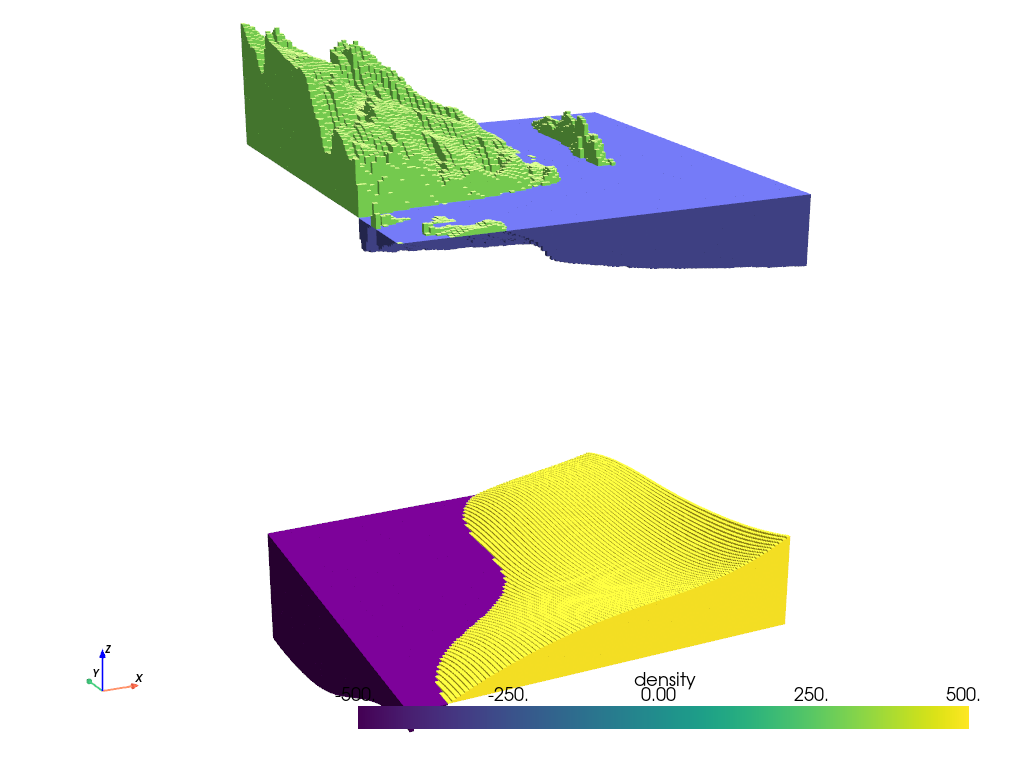

In [3]:
# the density contrast is between basement (~2800 kg/m3) and sediment (~2500 kg/m3)
basement_density_contrast = 2800 - 2500

# prisms are created between the mean topography value and the height of the topography
basement_zref = basement_topo.values.mean()
print(f"true zref: {basement_zref}m")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    basement_topo >= basement_zref,
    basement_density_contrast,
    -basement_density_contrast,
)

# create layer of prisms
basement_prisms = utils.grids_to_prisms(
    basement_topo,
    basement_zref,
    density=density_grid,
)

# the density contrast is between mantle (~3300 kg/m3) and basement rock (~2700 kg/m3)
moho_density_contrast = 3300 - 2800

# prisms are created between the mean topography value and the height of the topography
moho_zref = moho_topo.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    moho_topo >= moho_zref, moho_density_contrast, -moho_density_contrast
)

# create layer of prisms
moho_prisms = utils.grids_to_prisms(
    moho_topo,
    moho_zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [basement_prisms, moho_prisms],
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Forward gravity of prism layers

Calculate the gravity effect of each of these prism layers

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# forward gravity of basement prisms
grav_df["basement_grav"] = basement_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# forward gravity of moho prisms
grav_df["moho_grav"] = moho_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/7650 [00:00<?, ?it/s]

  0%|          | 0/7650 [00:00<?, ?it/s]

northing        easting  upward  basement_grav    moho_grav
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000
mean   340900.000000  191900.000000  1000.0       0.302843     0.854428
std    103923.425856   98149.168359     0.0      23.604988    27.683439
min    162900.000000   23900.000000  1000.0     -33.028677   -62.319646
25%    250900.000000  107900.000000  1000.0     -18.377589   -17.933769
50%    340900.000000  191900.000000  1000.0      -4.927040     9.034686
75%    430900.000000  275900.000000  1000.0      21.431379    23.718316
max    518900.000000  359900.000000  1000.0      58.138421    39.560469

In [5]:
# add offset to the moho gravity
grav_df["moho_grav"] += 100

grav_df["grav"] = grav_df.basement_grav + grav_df.moho_grav
grav_df.describe()

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  
count  7650.000000  
mean    101.157271  
std       9.703771  
min      75.617509  
25%      96.218487  
50%     102.149812  
75%     106.787344  
max     126.329916

In [6]:
# contaminate gravity with 2 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=2,
    percent=False,
    seed=0,
)
grav_df["uncert"] = stddev

# grid the contaminated gravity
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

INFO:invert4geom:Standard deviation used for noise: [2.0]


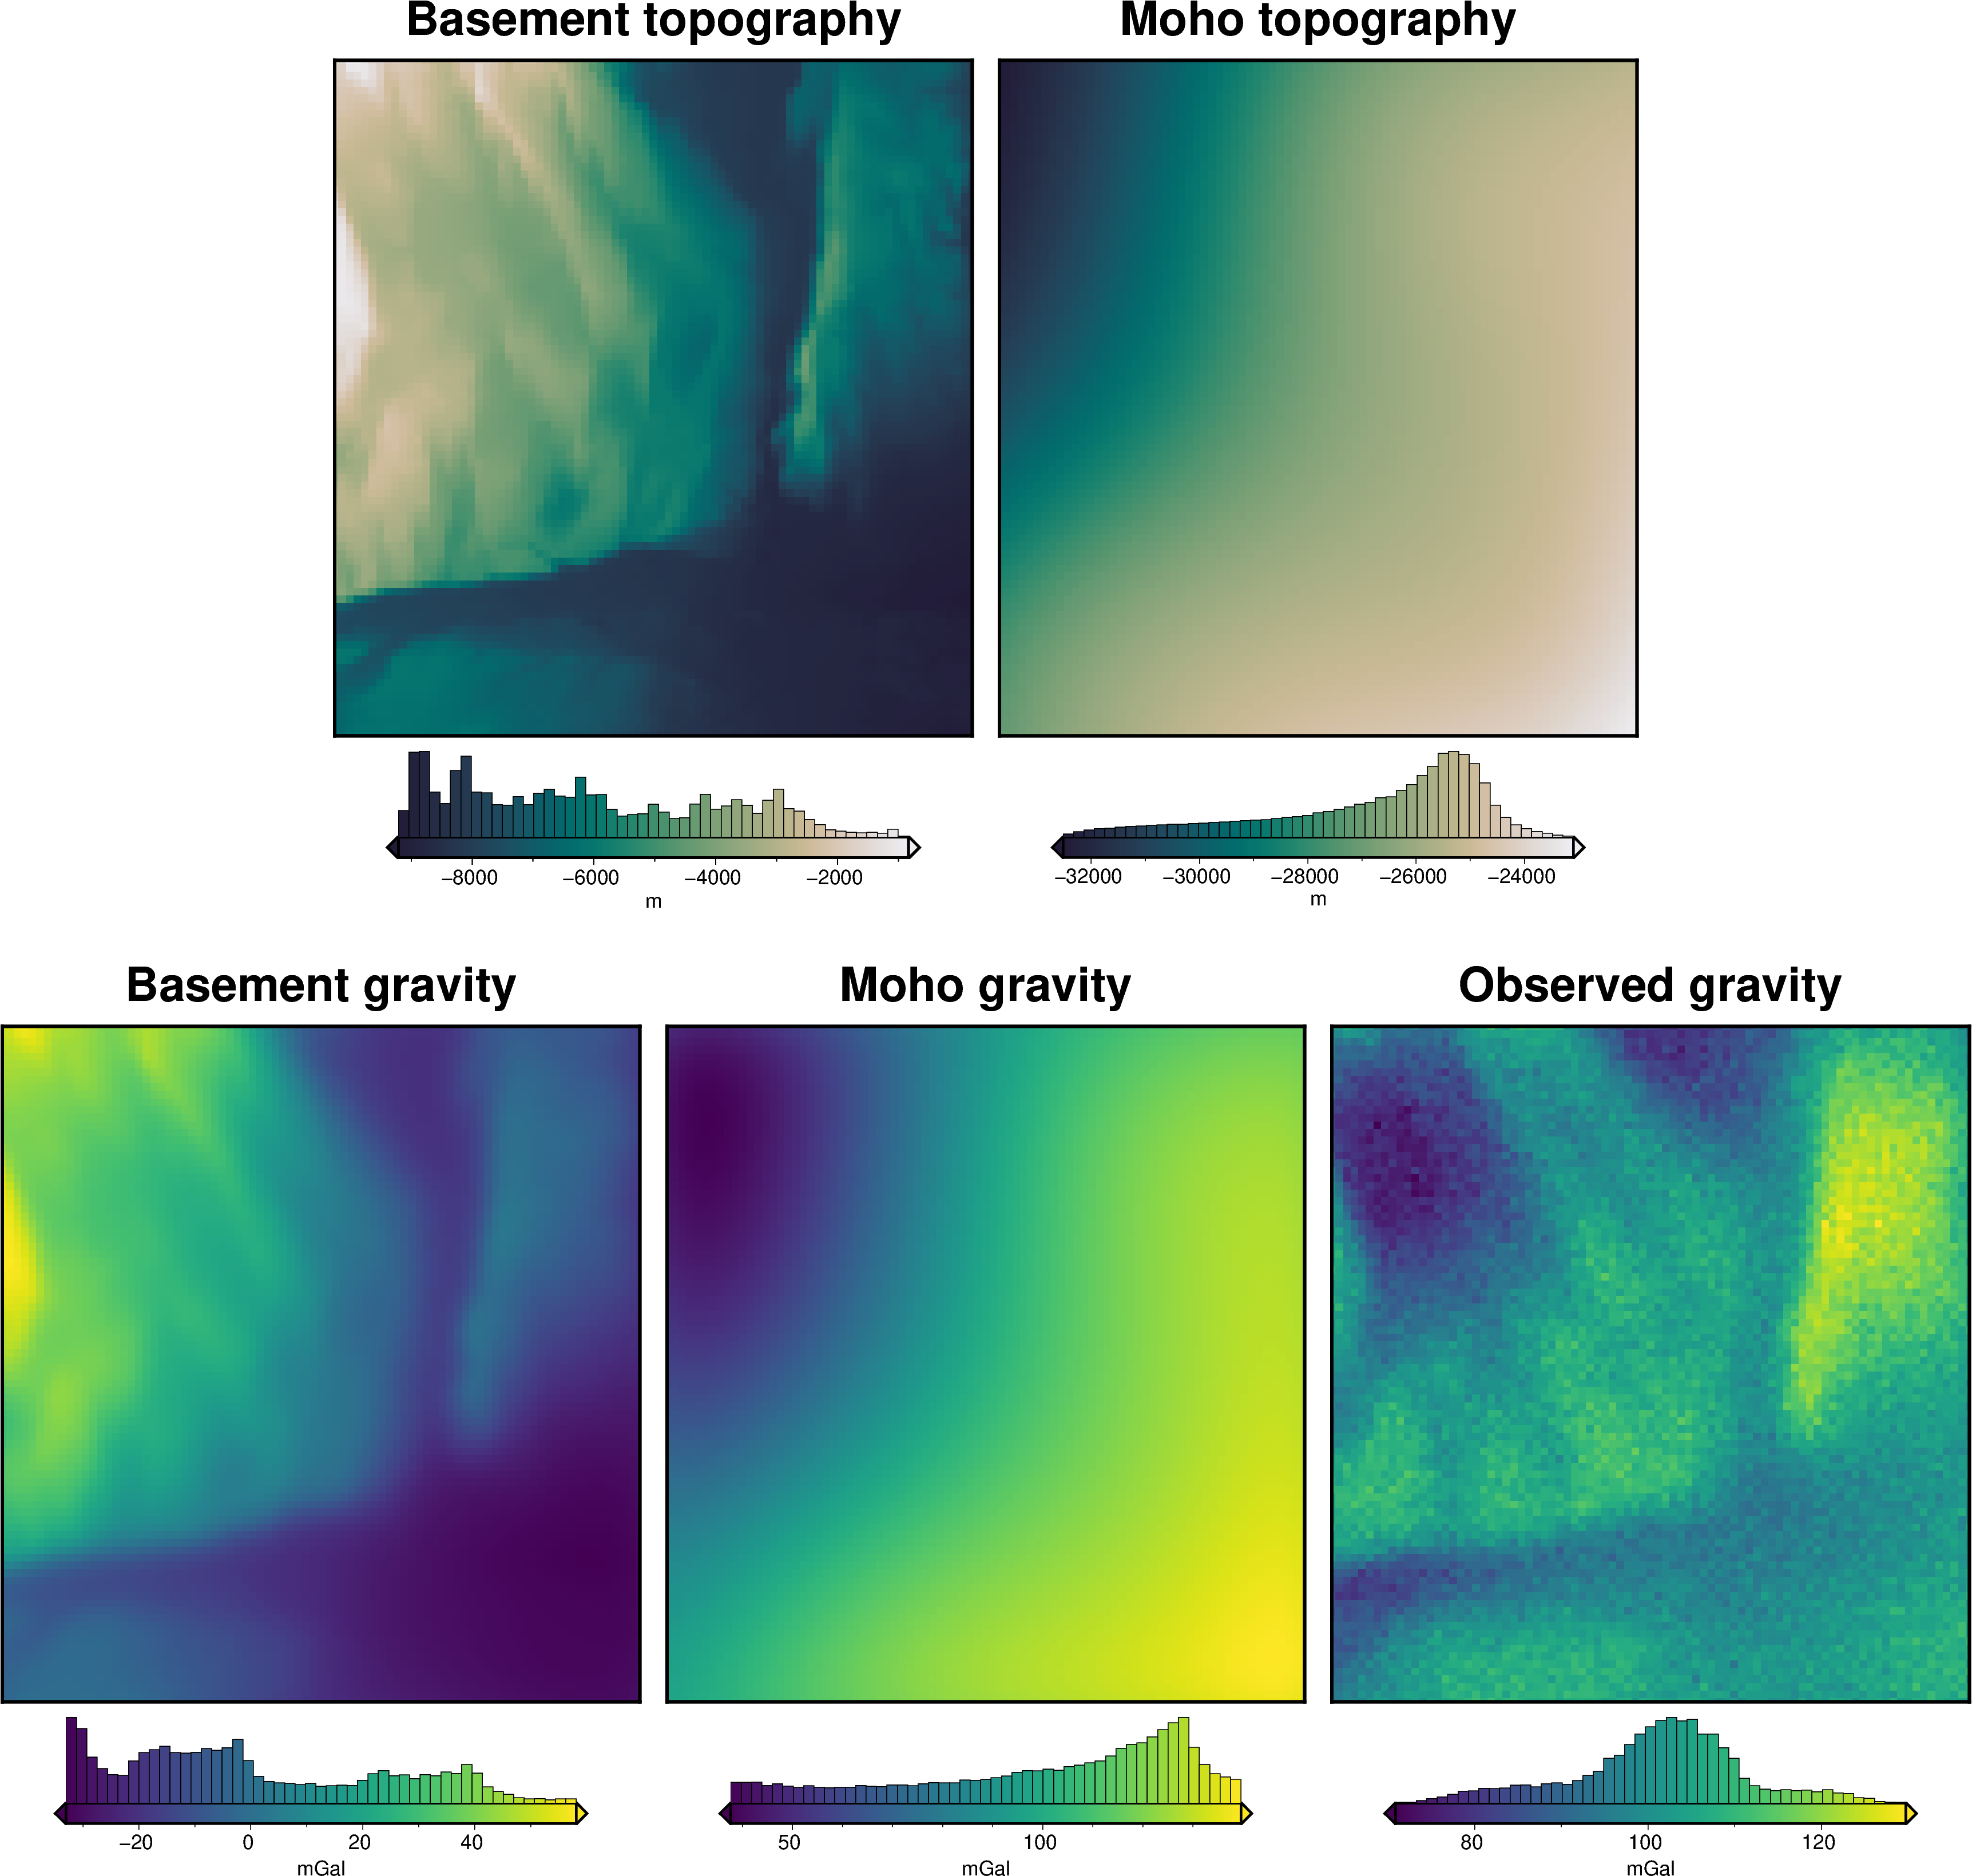

In [7]:
fig = maps.plot_grd(
    basement_topo,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    moho_topo,
    region=region,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.basement_grav,
    fig=fig,
    origin_shift="both",
    xshift_amount=-1.5,
    yshift_amount=-1.1,
    fig_height=10,
    title="Basement gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Moho gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig.show()

## Create "a-priori" basement measurements
These points represent locations where we know the basement elevation, for example from drill holes, seismic surveys, or outcropping basement.

In [8]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    basement_topo,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

easting       northing  true_upward       upward      uncert  \
0   93942.740553  165086.148419 -6166.691339 -6151.184549  123.333827   
1  185744.836752  437747.618234 -5230.910817 -5244.731393  104.618216   
2  165200.779866  503888.251841 -4551.466895 -4493.169645   91.029338   
3  312585.151503  412789.886738 -6178.090981 -6165.129332  123.561820   
4   81410.282014  268837.863004 -4562.000830 -4610.875312   91.240017   

     weight  
0  0.000066  
1  0.000091  
2  0.000121  
3  0.000065  
4  0.000120

## Create starting basement model

Here we interpolate the *a-priori* point measurements to create a starting model of basement topography. We then use this to create a starting prism model.

In [9]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=[*list(np.logspace(-60, 0, 100)), None],
    weights=constraint_points.weight,
)

INFO:invert4geom:Best SplineCV score: 0.4000319169095148
INFO:invert4geom:Best damping: None


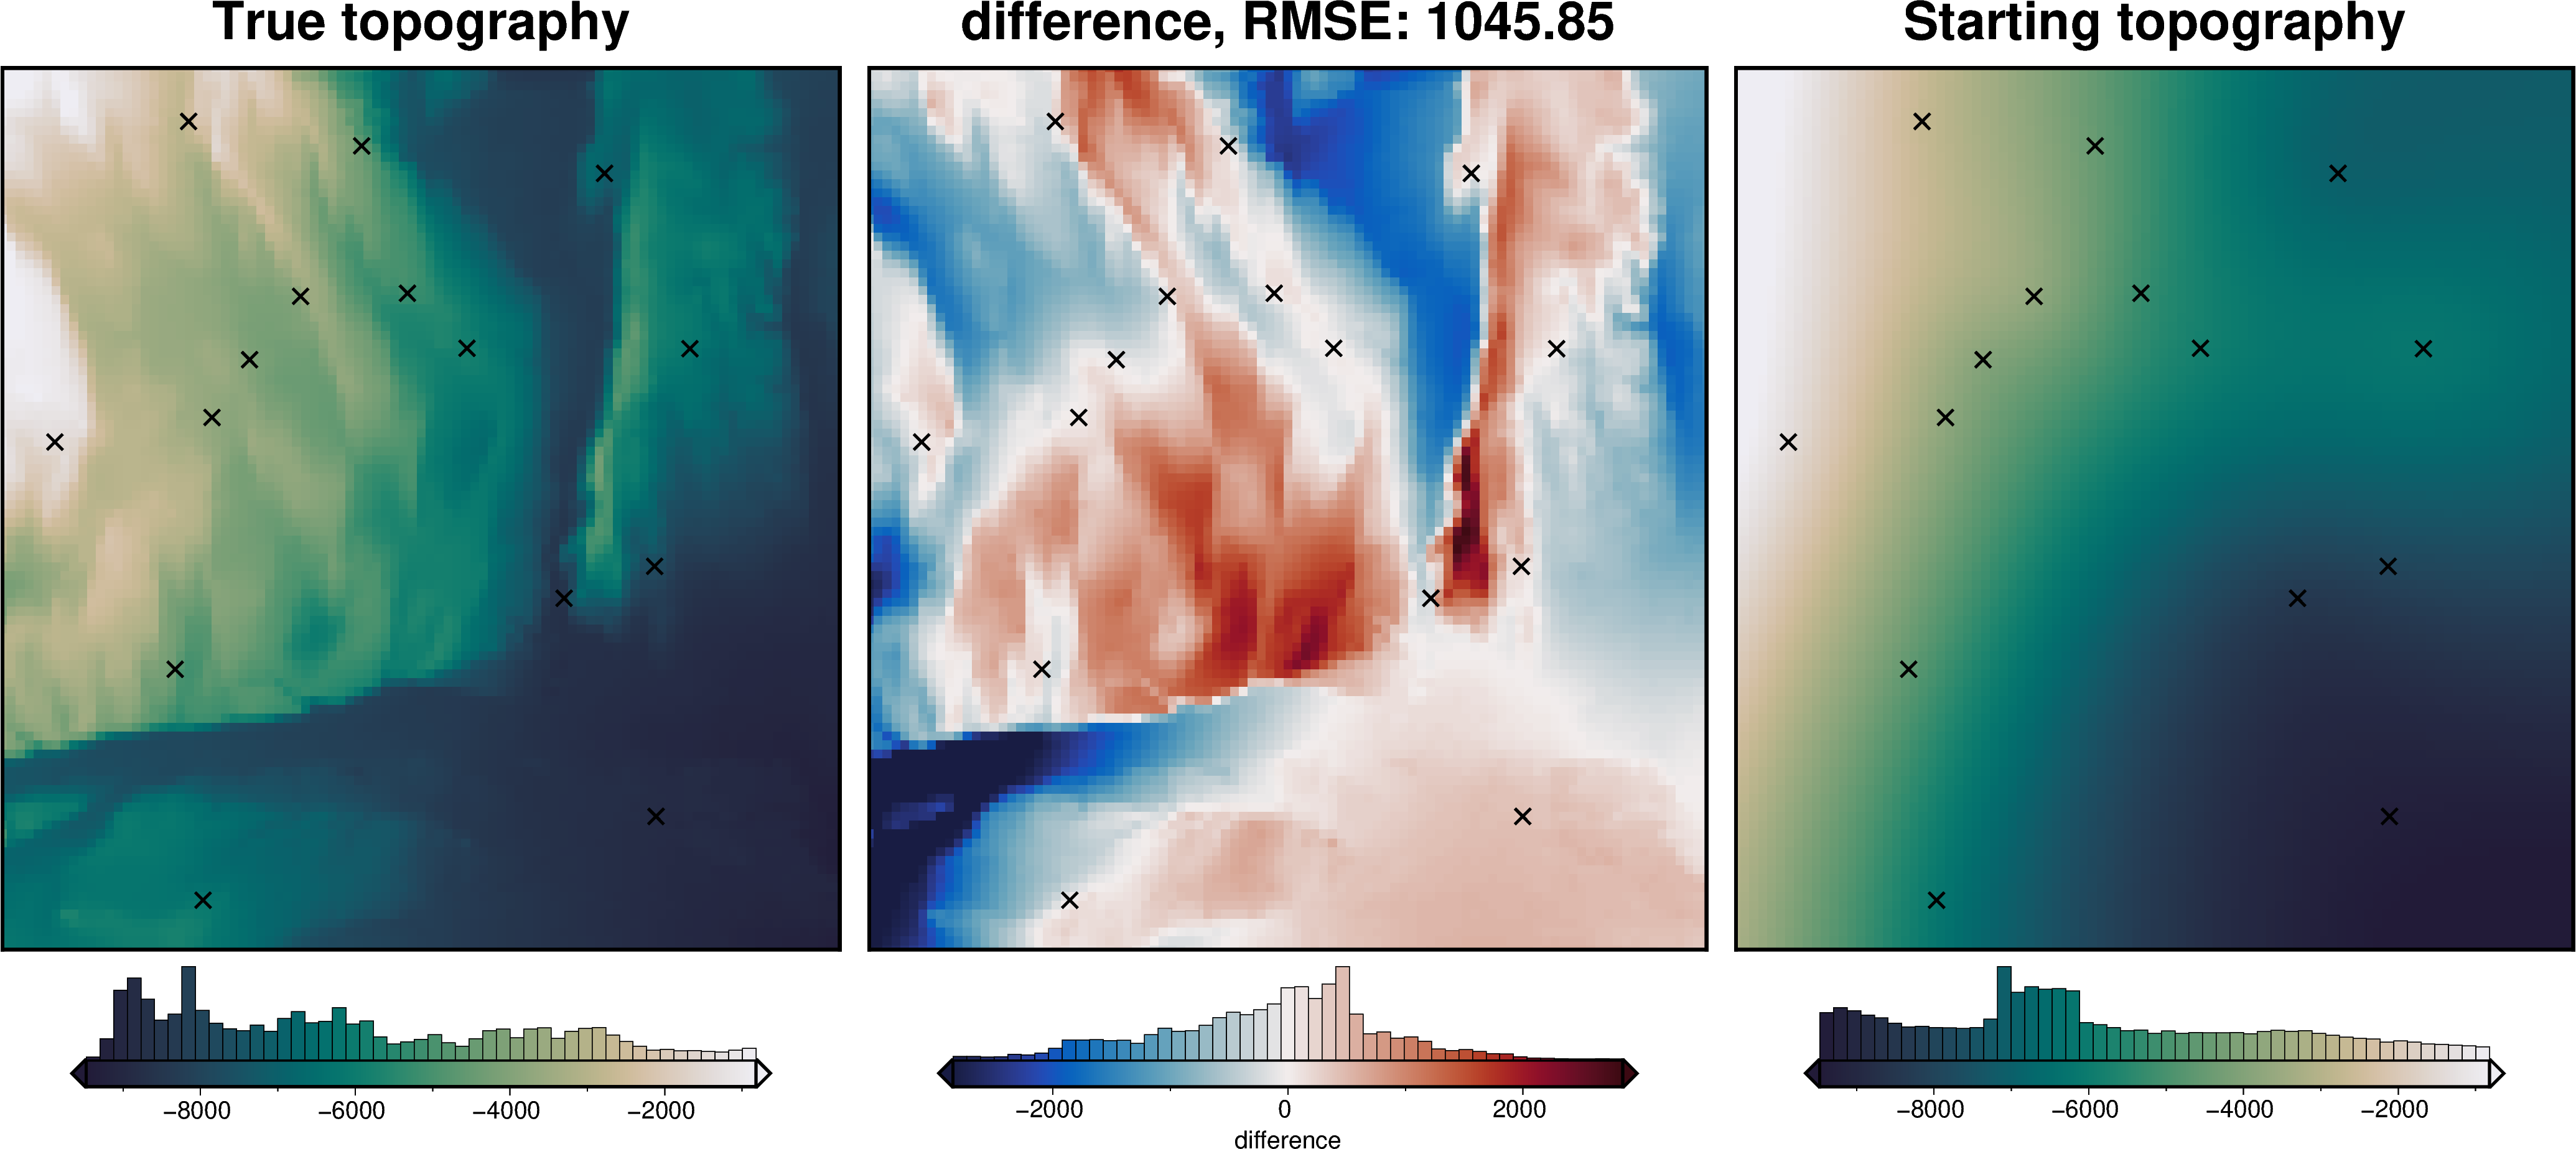

In [10]:
_ = polar_utils.grd_compare(
    basement_topo,
    starting_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [11]:
zref = basement_zref
density_contrast = basement_density_contrast

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

### Forward gravity of starting prism layer

In [12]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.gravity_anomaly - grav_df.starting_gravity - grav_df.moho_grav
)

grav_df.describe()

  0%|          | 0/7650 [00:00<?, ?it/s]

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000  
mean    101.157271       101.157271     2.0          1.548577    -1.245734  
std       9.703771         9.919851     0.0         24.926461     9.334160  
min      75.617509        70.861220     2.0        -36.414267   -39.698170  
25%      96.218487        96.092524     2.0        -17.408451    -6.458428  
50%     102.149812       102.057202     2.0         -3.040309    -0.024210  
75%     106.787344       107.006336     2.0         19.823536     4.763396  
max     126.329916       129.736453     2.0         59.698559    23.115665

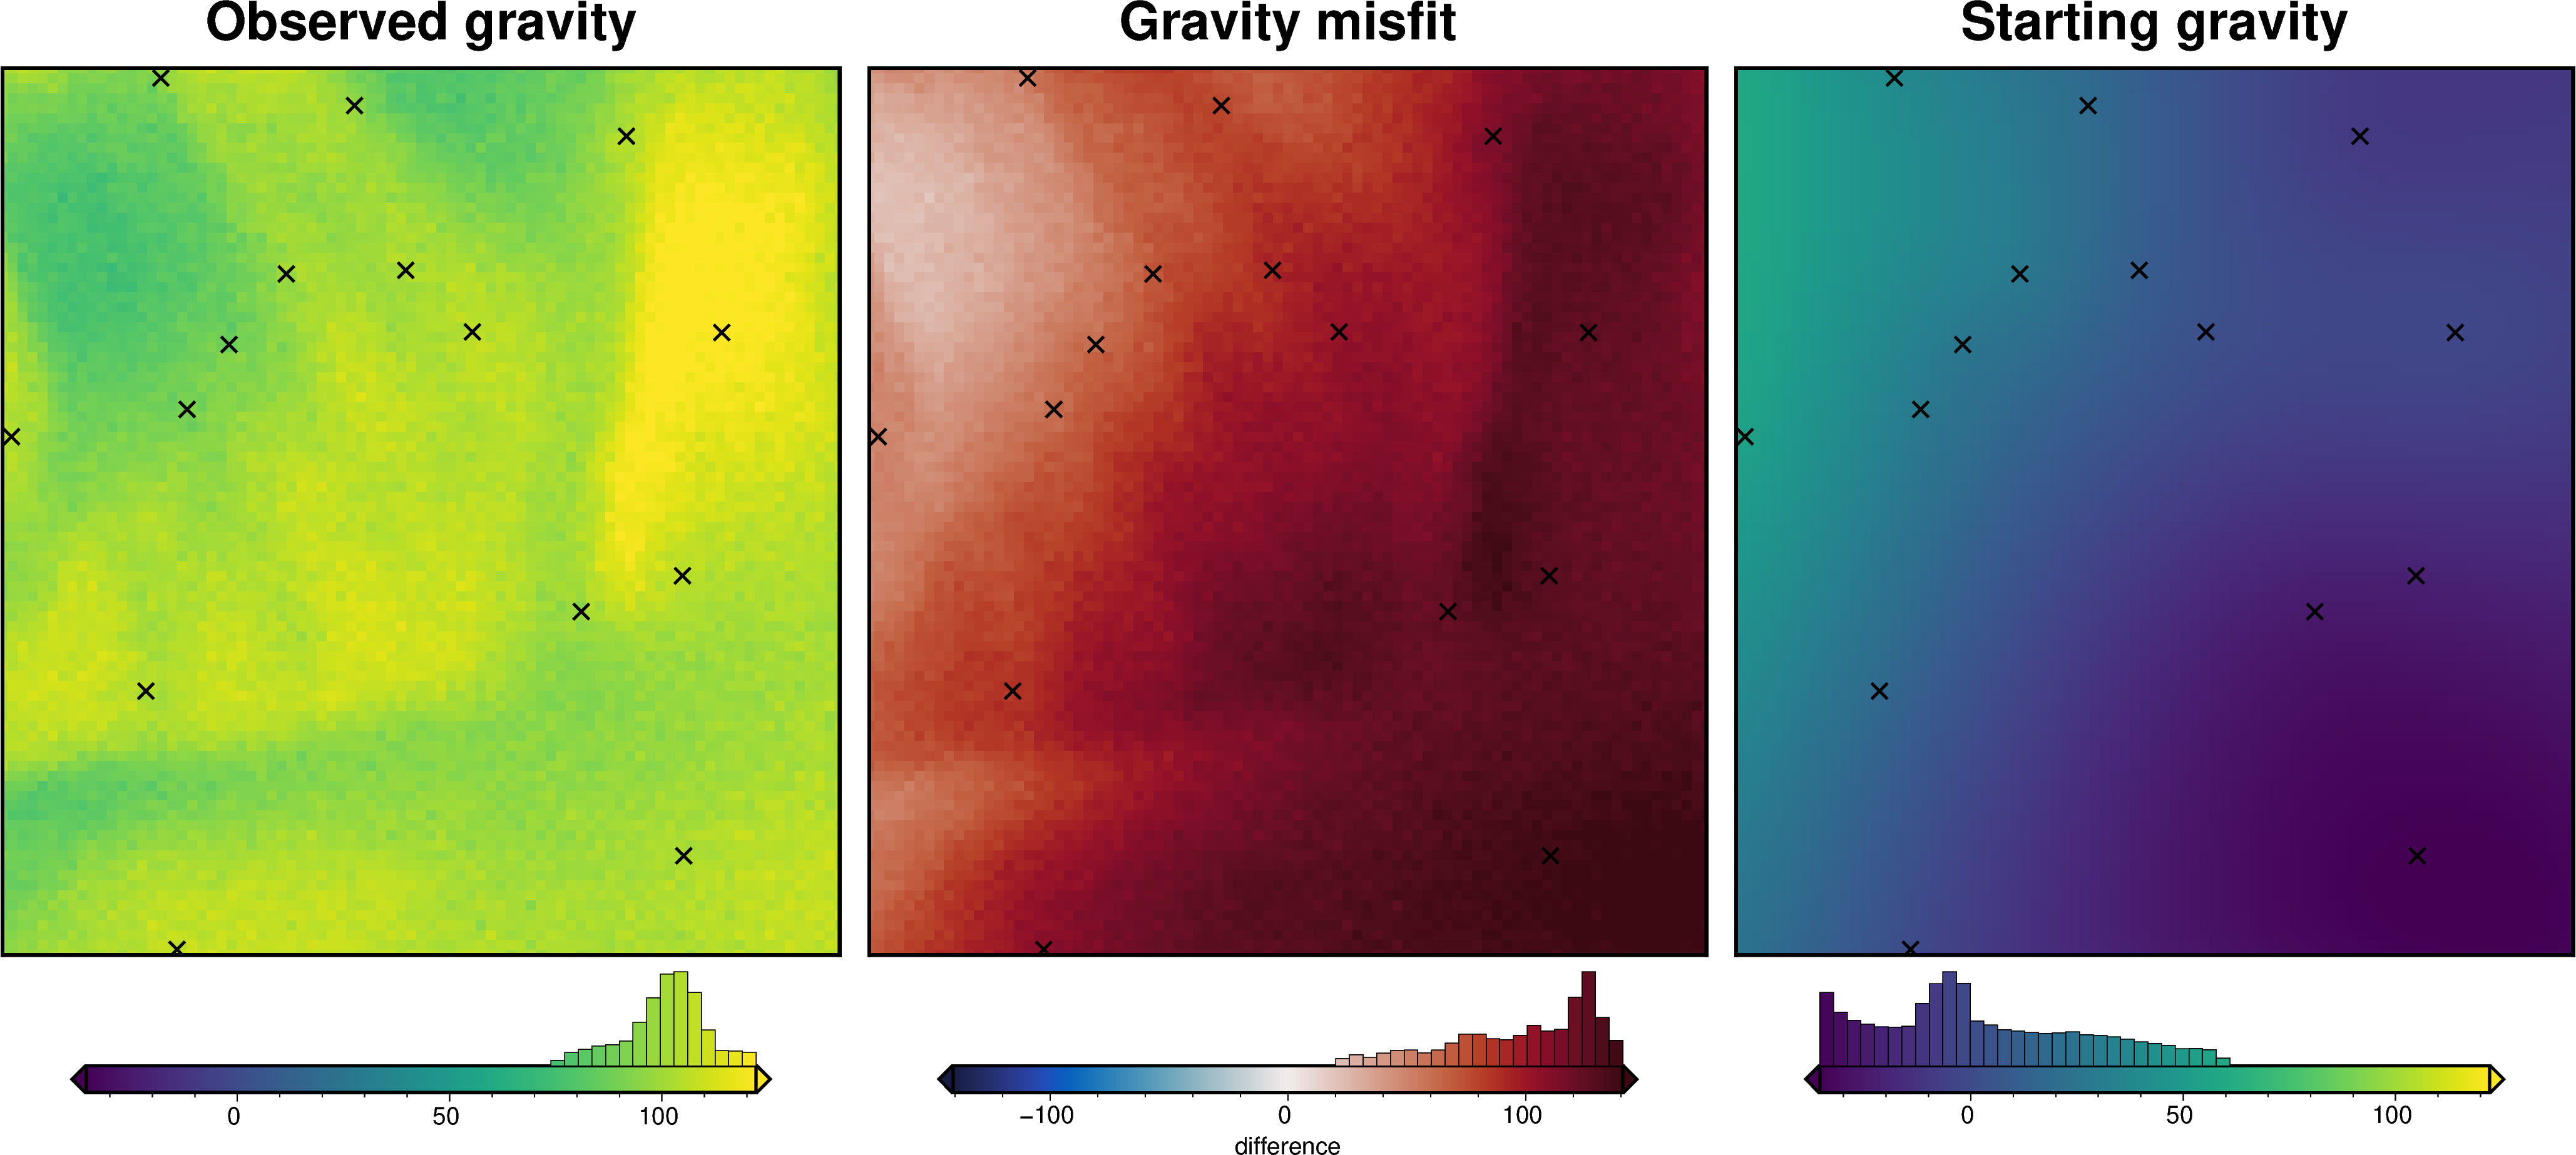

In [13]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

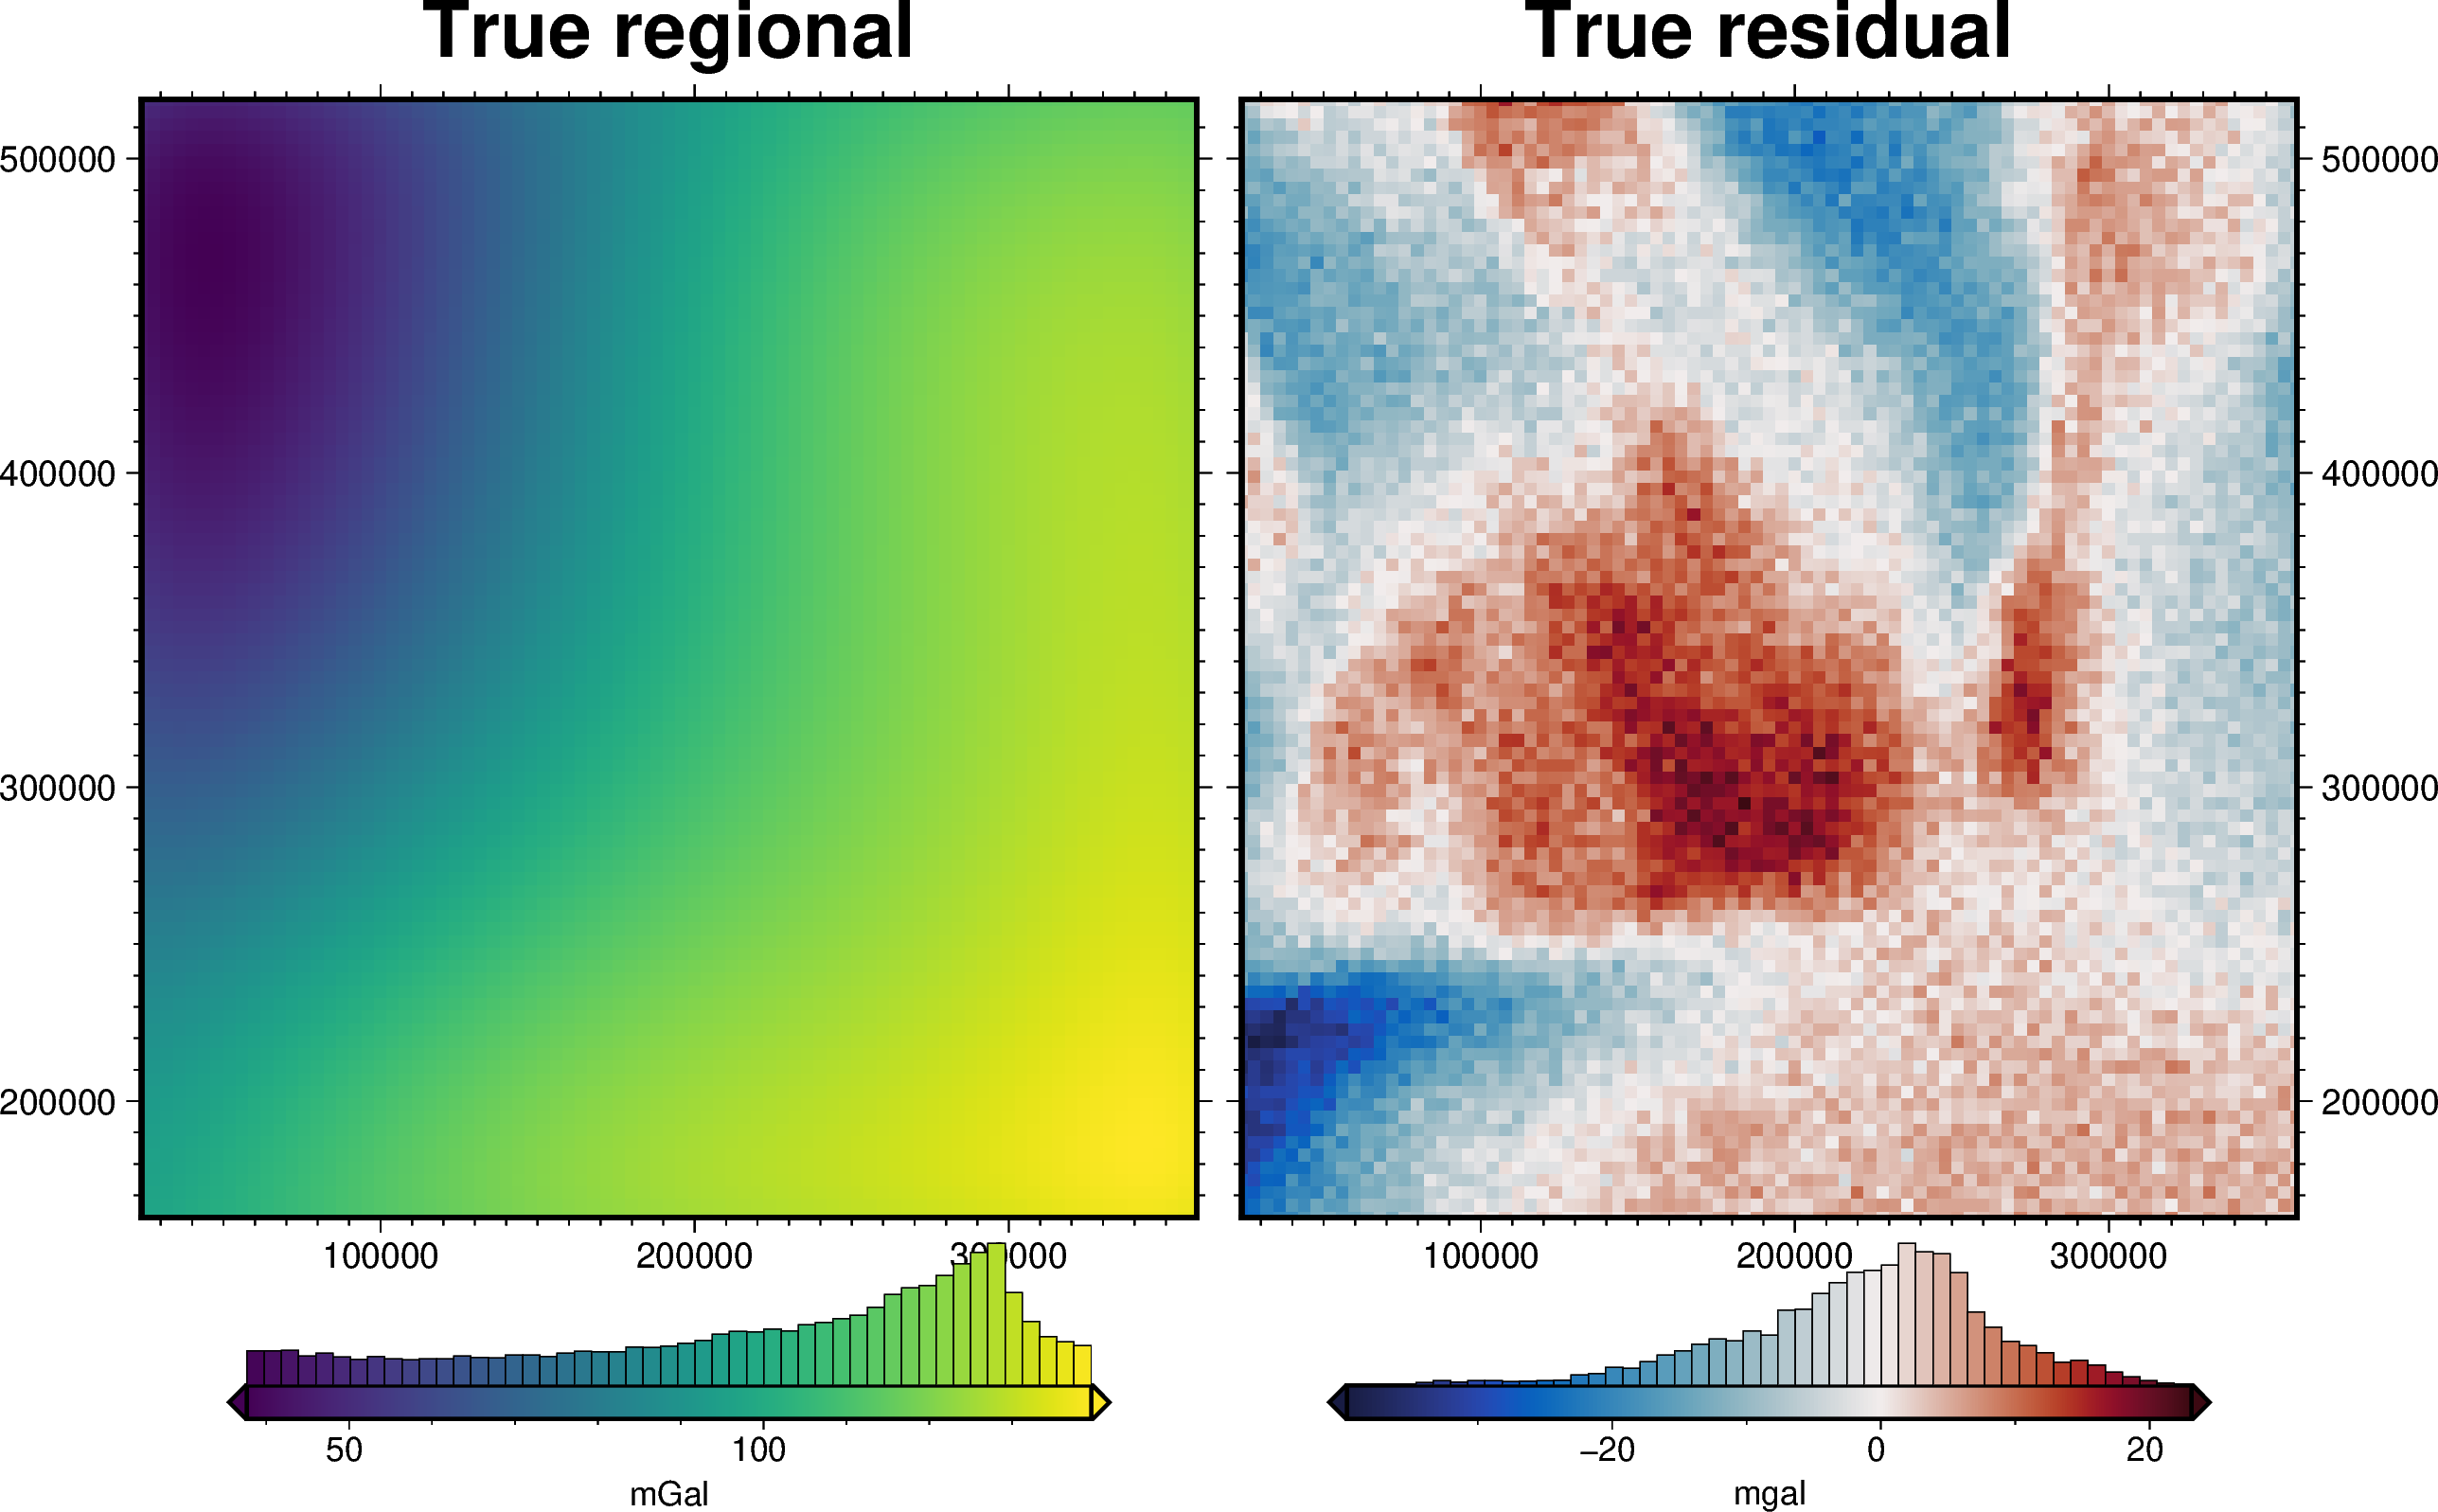

In [14]:
fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig_height=10,
    title="True regional",
    cbar_label="mGal",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.true_res,
    fig=fig,
    cmap="balance+h0",
    origin_shift="x",
    fig_height=10,
    title="True residual",
    cbar_label="mgal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## True-Estimated regional plotting function

In [15]:
def regional_comparison(df, regional_column):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.moho_grav,
        grav_grid[regional_column],
        robust=True,
        plot=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        grav_grid.true_res,
        grav_grid.res,
        cmap="balance+h0",
        robust=True,
        plot=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

## Save data so other notebooks can use it later


In [19]:
# save gravity dataframe
grav_df.to_csv("../tmp/regional_sep_grav_df.csv")

# save constraint points
constraint_points.to_csv("../tmp/regional_sep_constraint_points.csv")

# merge and save grids
ds = xr.merge(
    [
        basement_topo.rename("basement"),
        moho_topo.rename("moho"),
        starting_topography.rename("starting"),
    ]
)
ds.drop_attrs().to_netcdf("../tmp/regional_sep_grids.nc")

starting_prisms.to_netcdf("../tmp/regional_sep_starting_prisms.nc")

## Regional estimation methods

Now that we have a gravity misfit (difference between the true observed gravity and the forward calculated gravity from our knowledge of the topography), we can try and separate out the portion of the misfit not related to our lack of understanding of the topography. This is the **regional misfit** and in this case is resulting from our lower layer of prisms.

There are 4 main techniques: a **constant** value for the regional field, **filtering** the misfit to get the regional, fitting a polynomial **trend** to the misfit to get the regional, calculating the long-wavelength component of the misfit using the **equivalent sources** method, and finding a regional field by using point of known elevation for the layer of interest (**constraint point minimization**).

In [20]:
grav_df.describe()

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000  
mean    101.157271       101.157271     2.0          1.548577    -1.245734  
std       9.703771         9.919851     0.0         24.926461     9.334160  
min      75.617509        70.861220     2.0        -36.414267   -39.698170  
25%      96.218487        96.092524     2.0        -17.408451    -6.458428  
50%     102.149812       102.057202     2.0         -3.040309    -0.024210  
75%     106.787344       107.006336     2.0         19.823536     4.763396  
max     126.329916       129.736453     2.0         59.698559    23.115665

### Constant value

#### 1) Constant value equal to average value of gravity misfit at constraint points

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 91.19169859399041 mGal


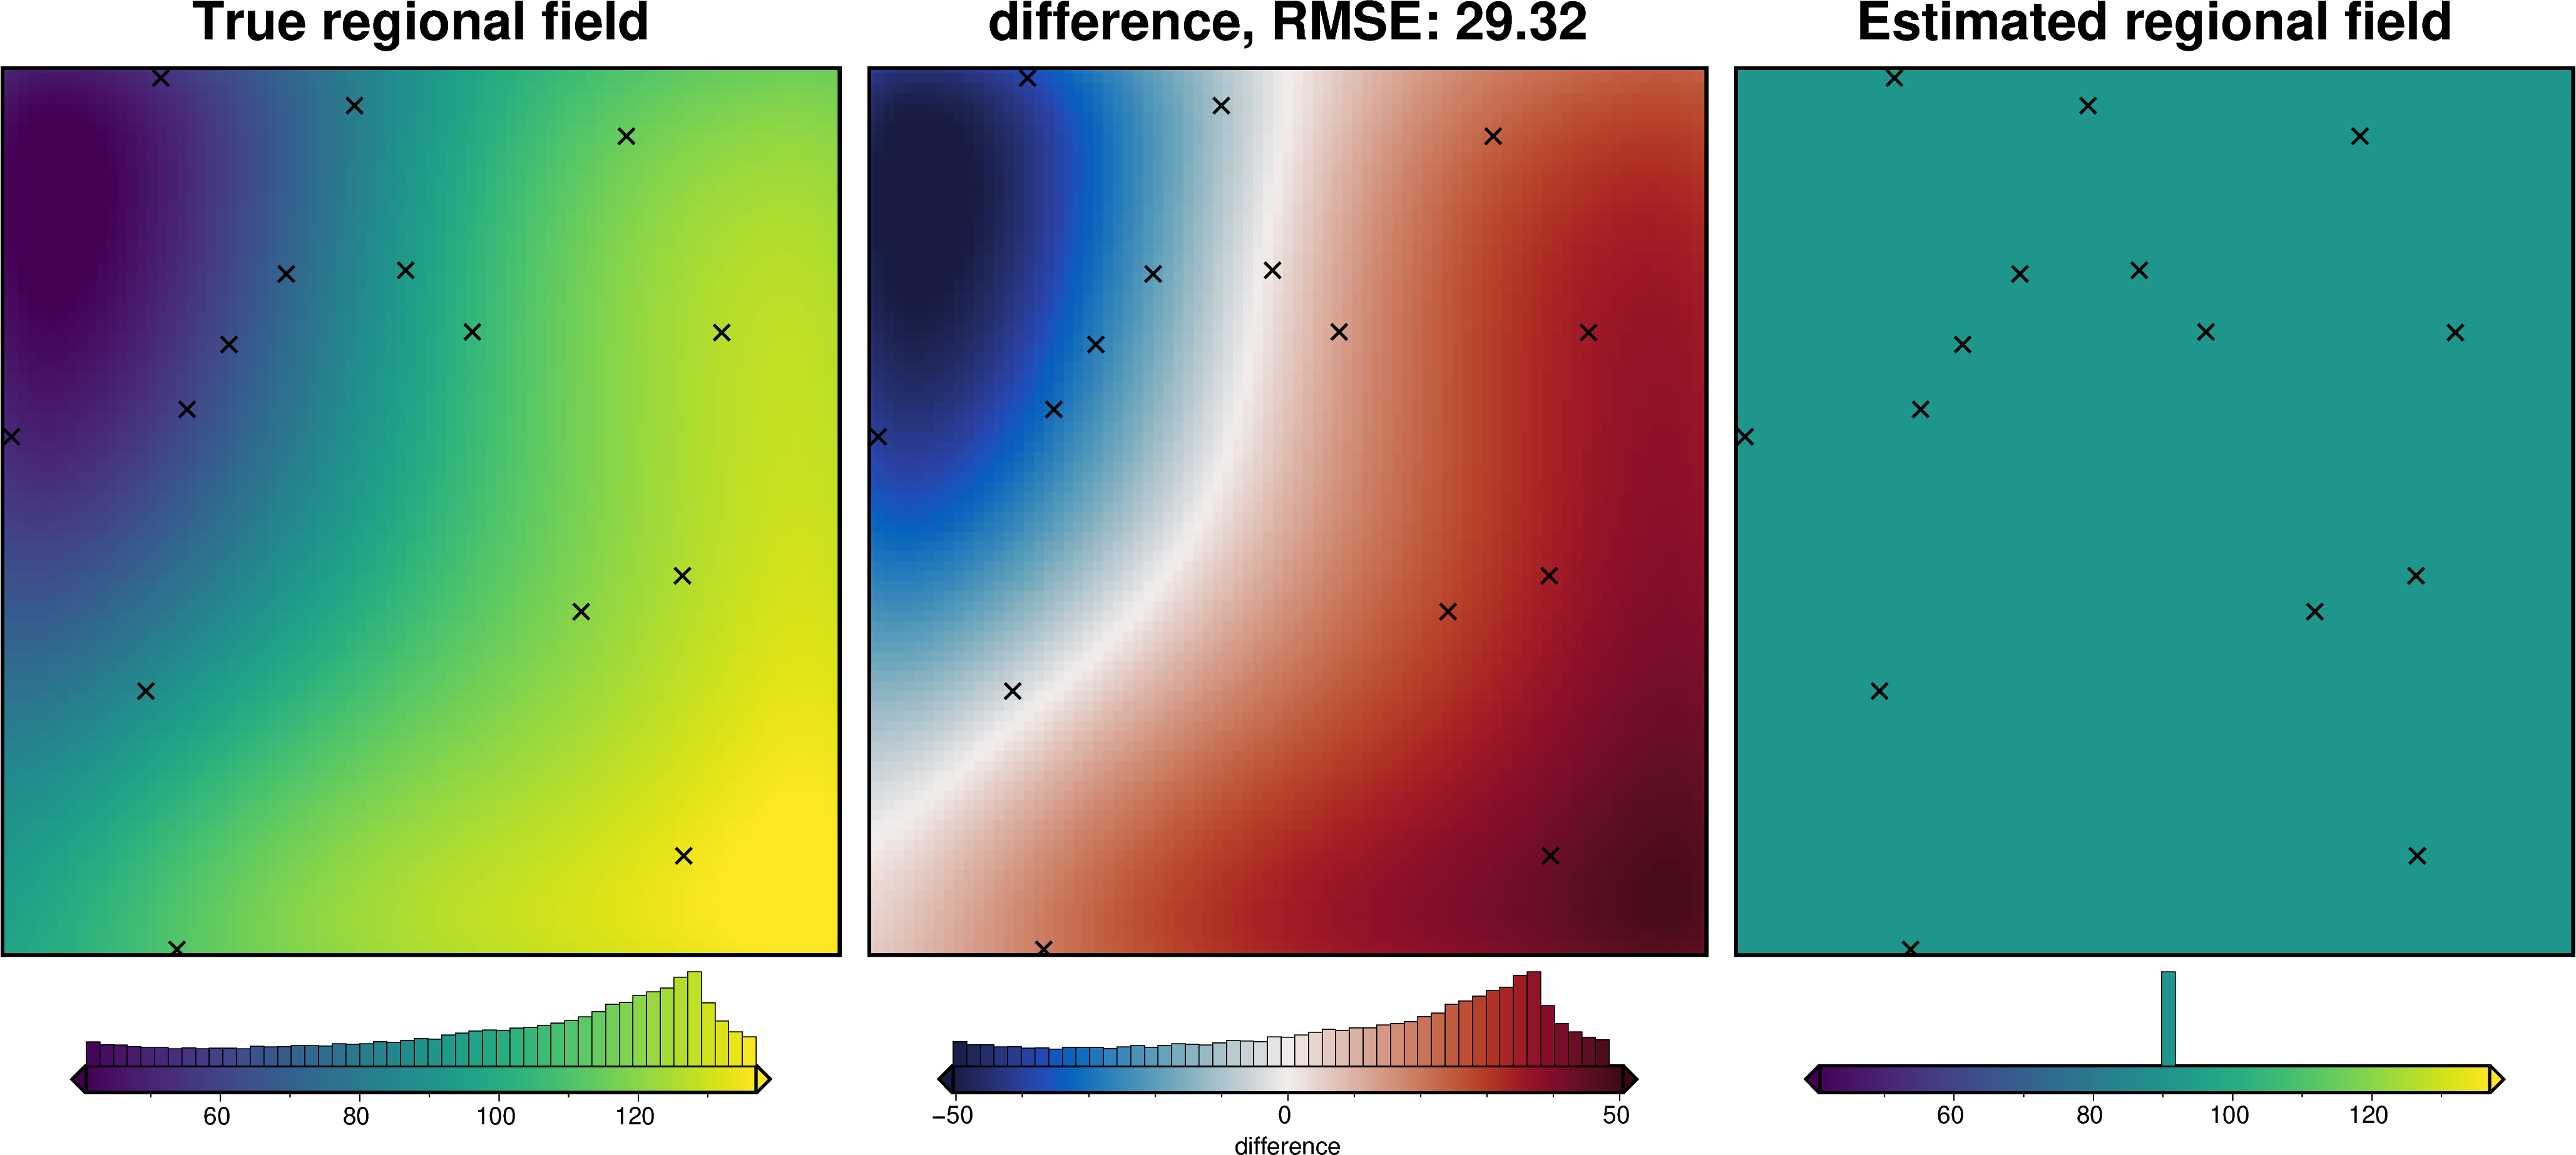

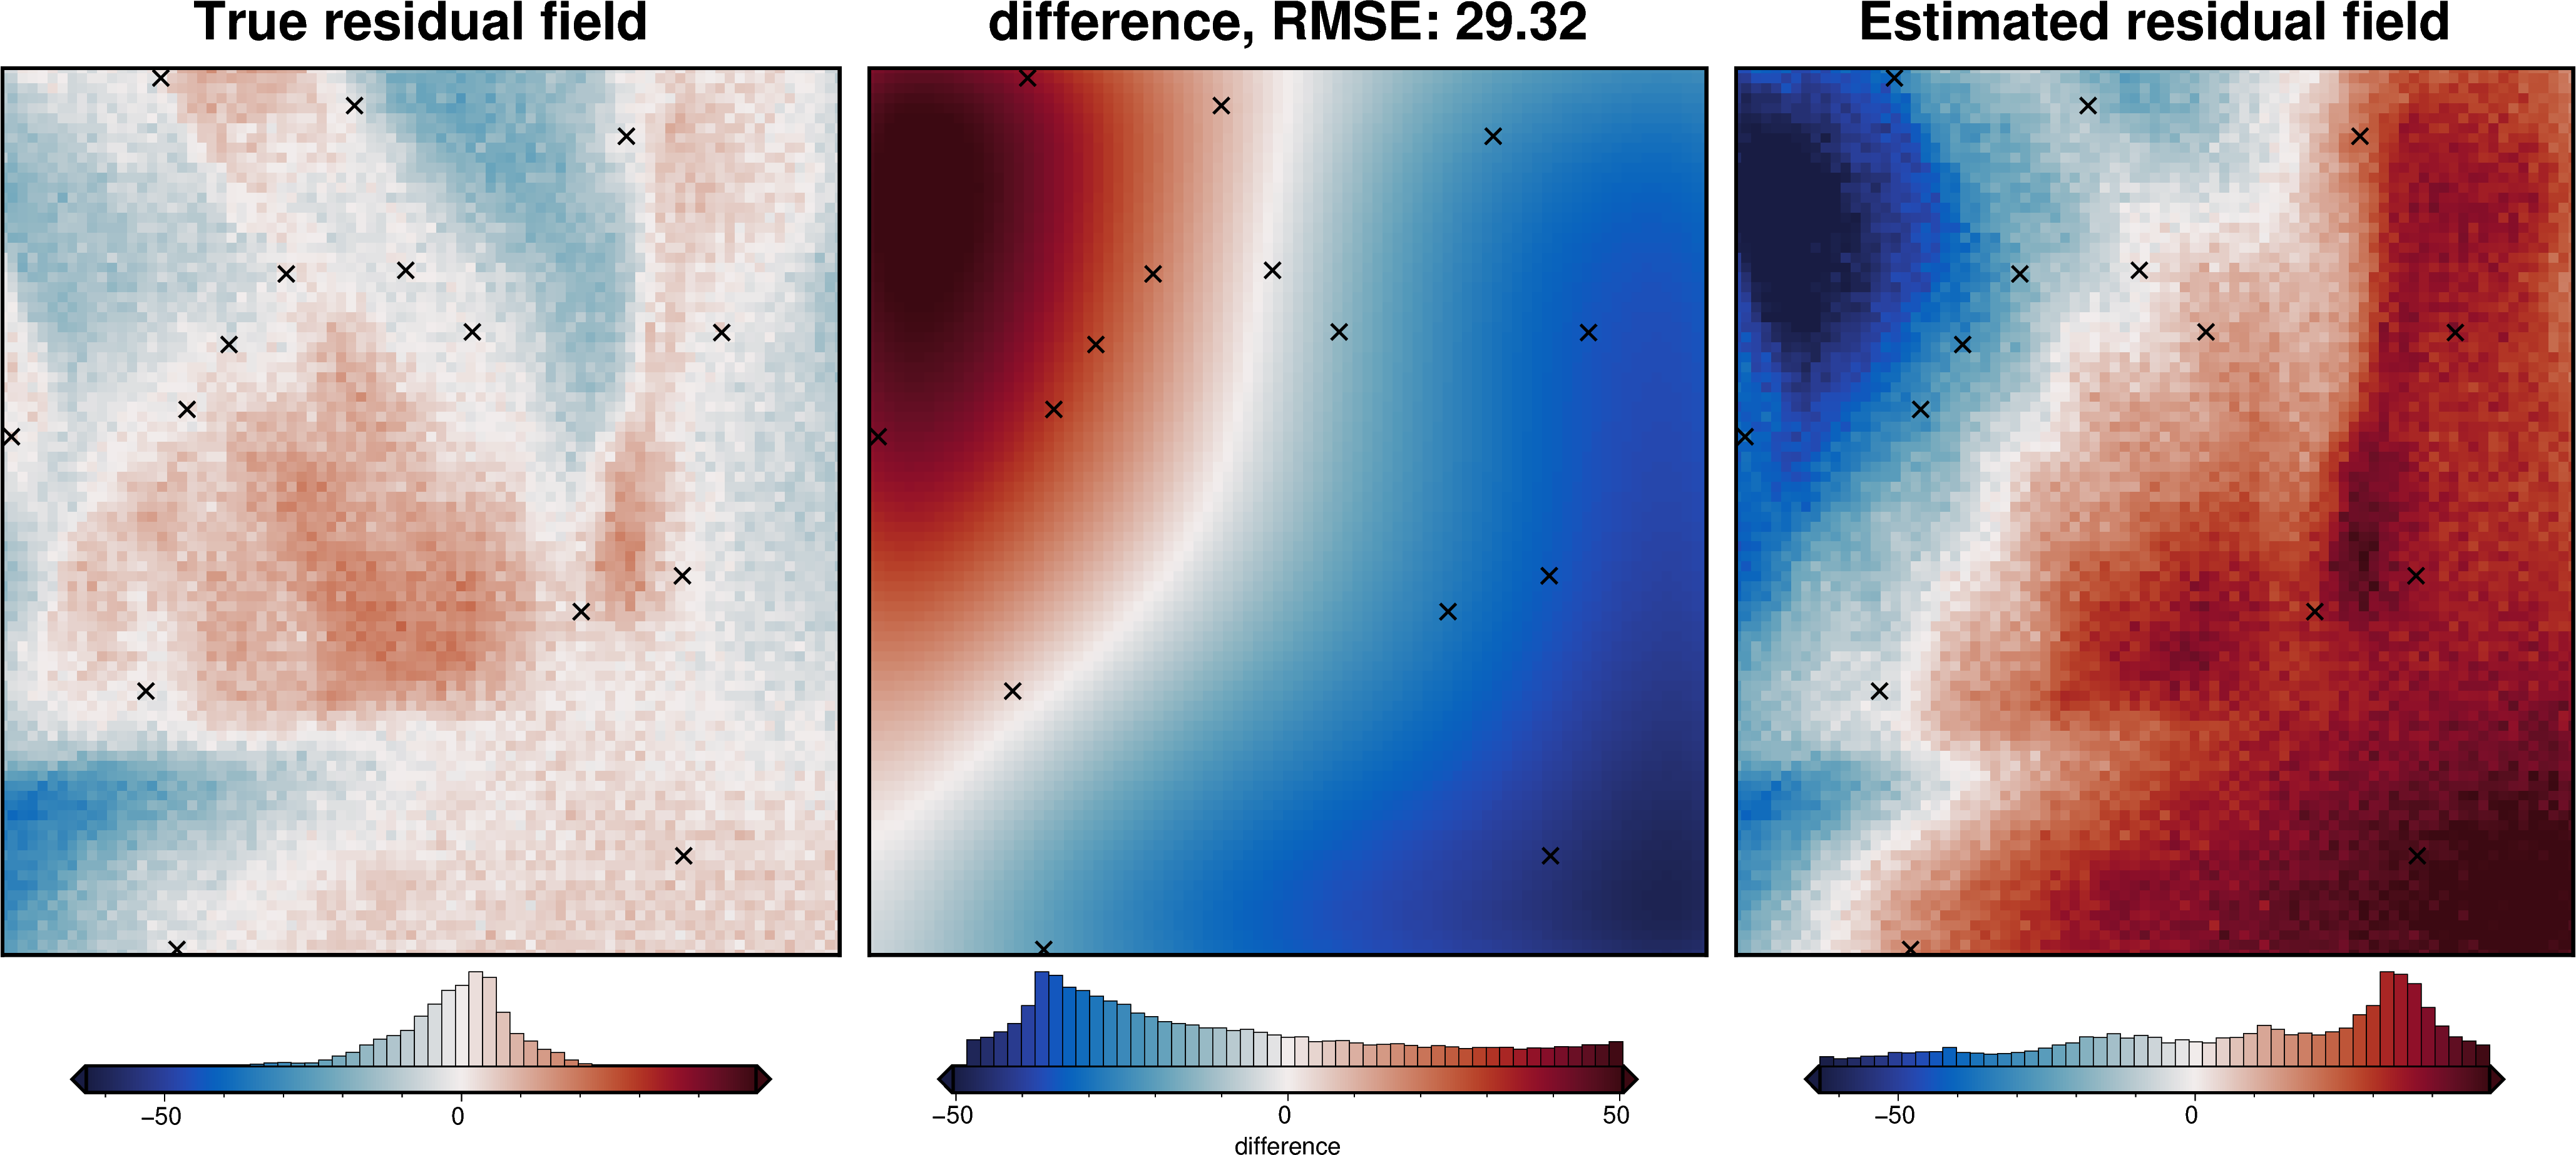

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

            misfit           reg          res  constant_reg  constant_res  
count  7650.000000  7.650000e+03  7650.000000  7.650000e+03   7650.000000  
mean     99.608694  9.119170e+01     8.416995  9.119170e+01      8.416995  
std      30.581609  1.421178e-14    30.581609  1.421178e-14     30.581609  
min      17.942842  9.119170e+01   -73.248856  9.119170e+01    -73.248856  
25%      78.143138  9.119170e+01   -13.048560  9.119170e+01    -13.048560  
50%     107.150139  9.119170e+01    15.958441  9.119170e+01     15.958441  
75%     124.912841  9.119170e+01    33.721142  9.119170e+01     33.721142  
max     148.090389  9.119170e+01    56.898690  9.119170e+01     56.898690

In [21]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constraints_df=constraint_points,
)
grav_df["constant_reg"] = grav_df.reg
grav_df["constant_res"] = grav_df.res

regional_comparison(grav_df, "constant_reg")

grav_df.describe()

#### 2) apply a custom constant value

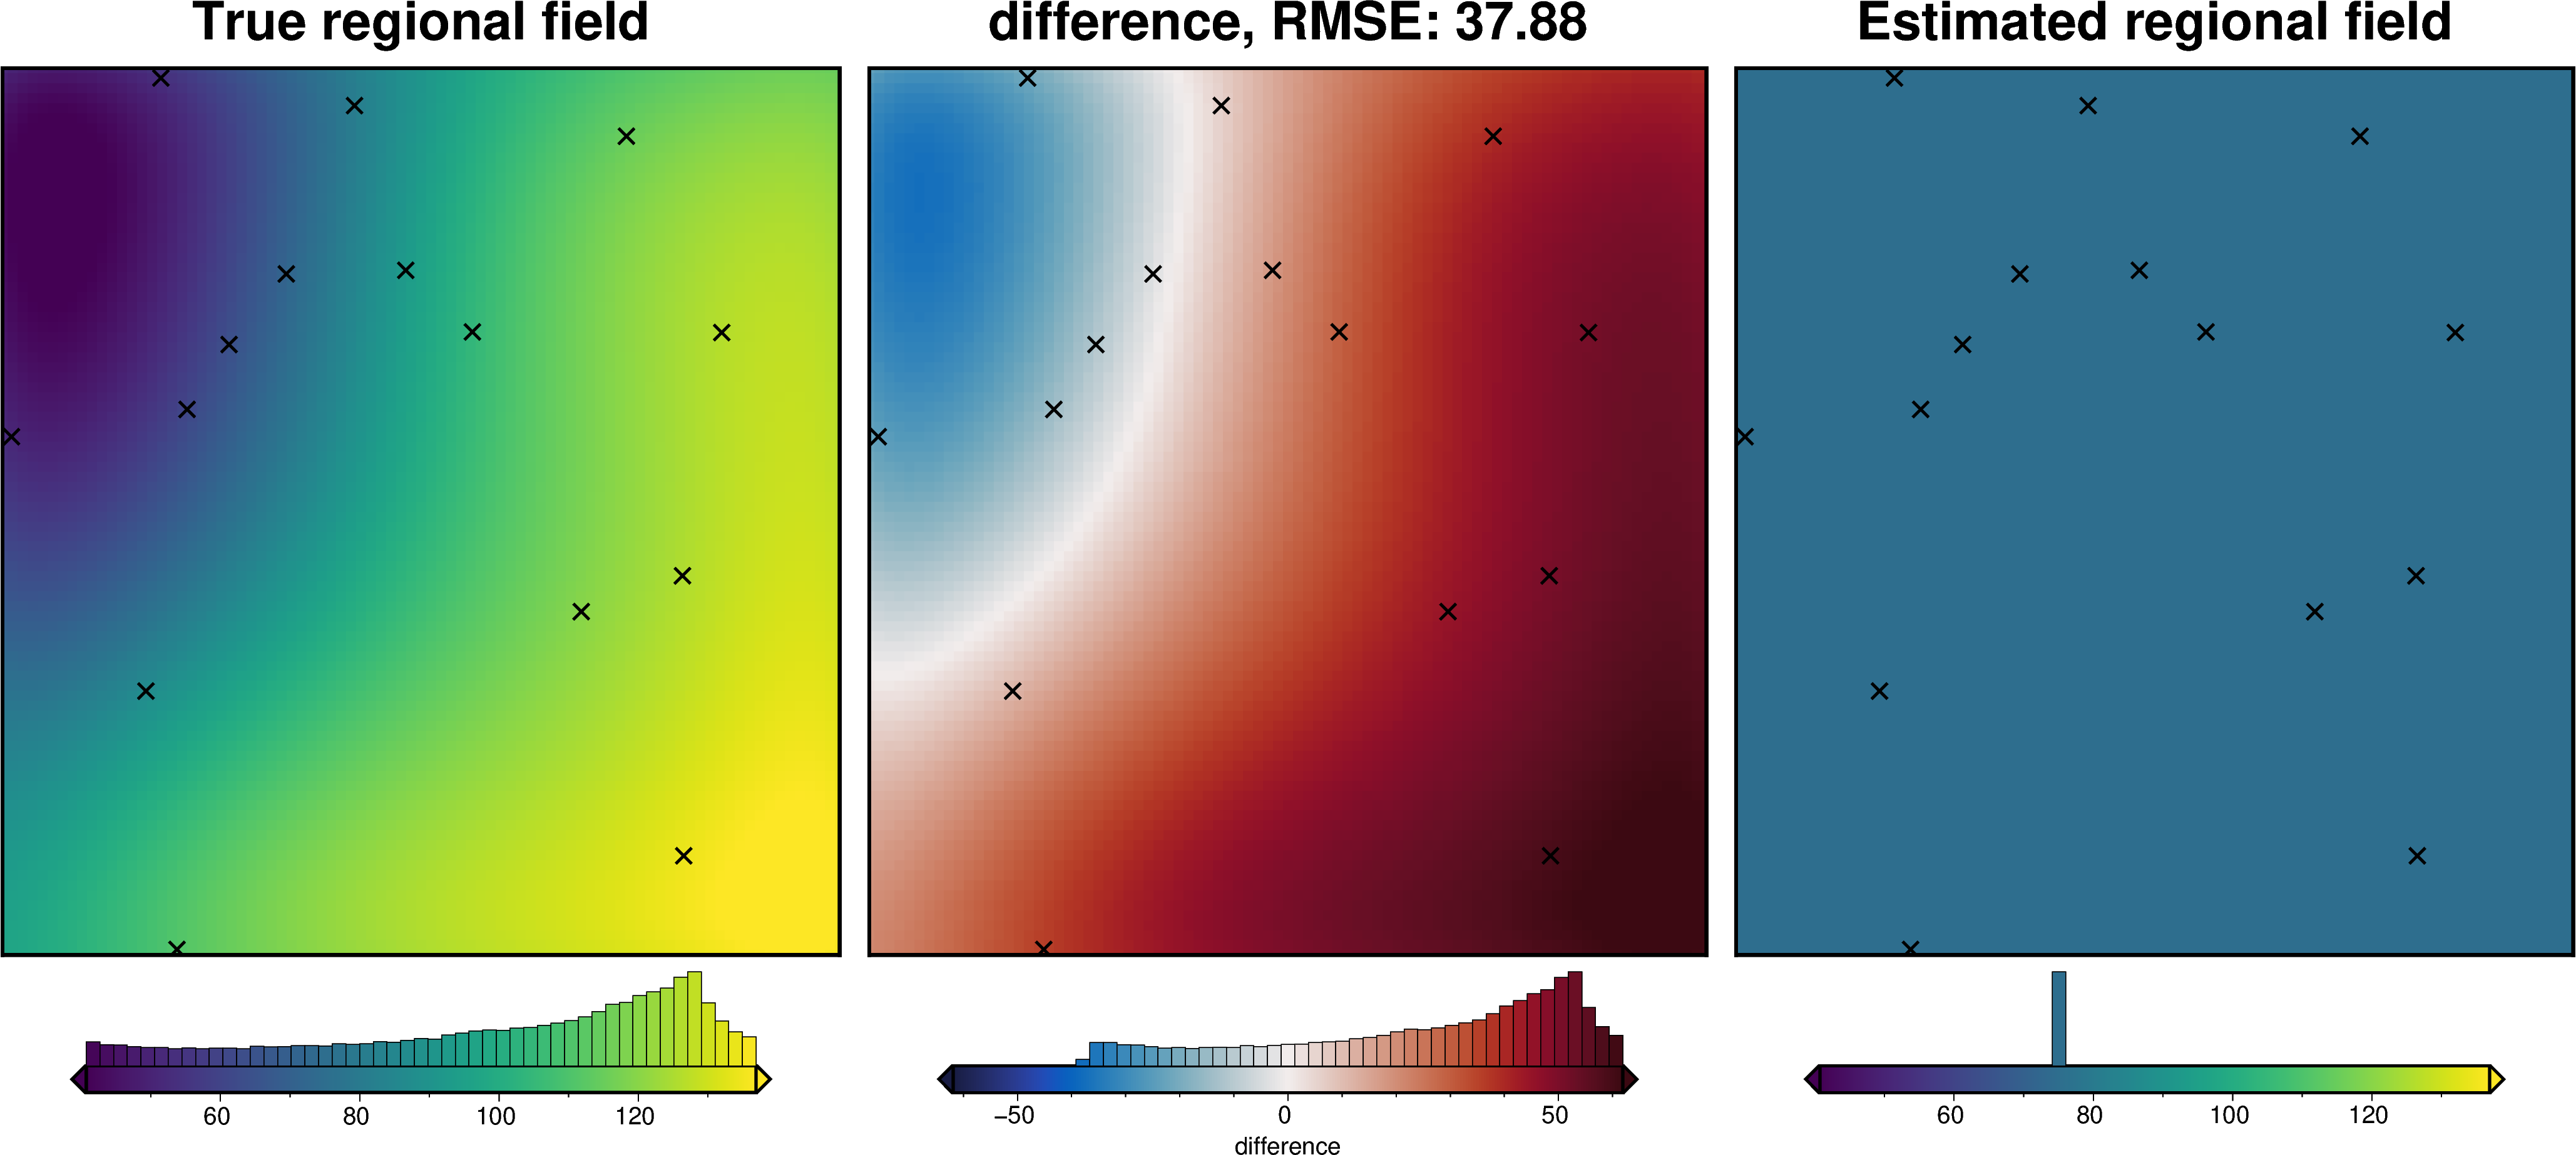

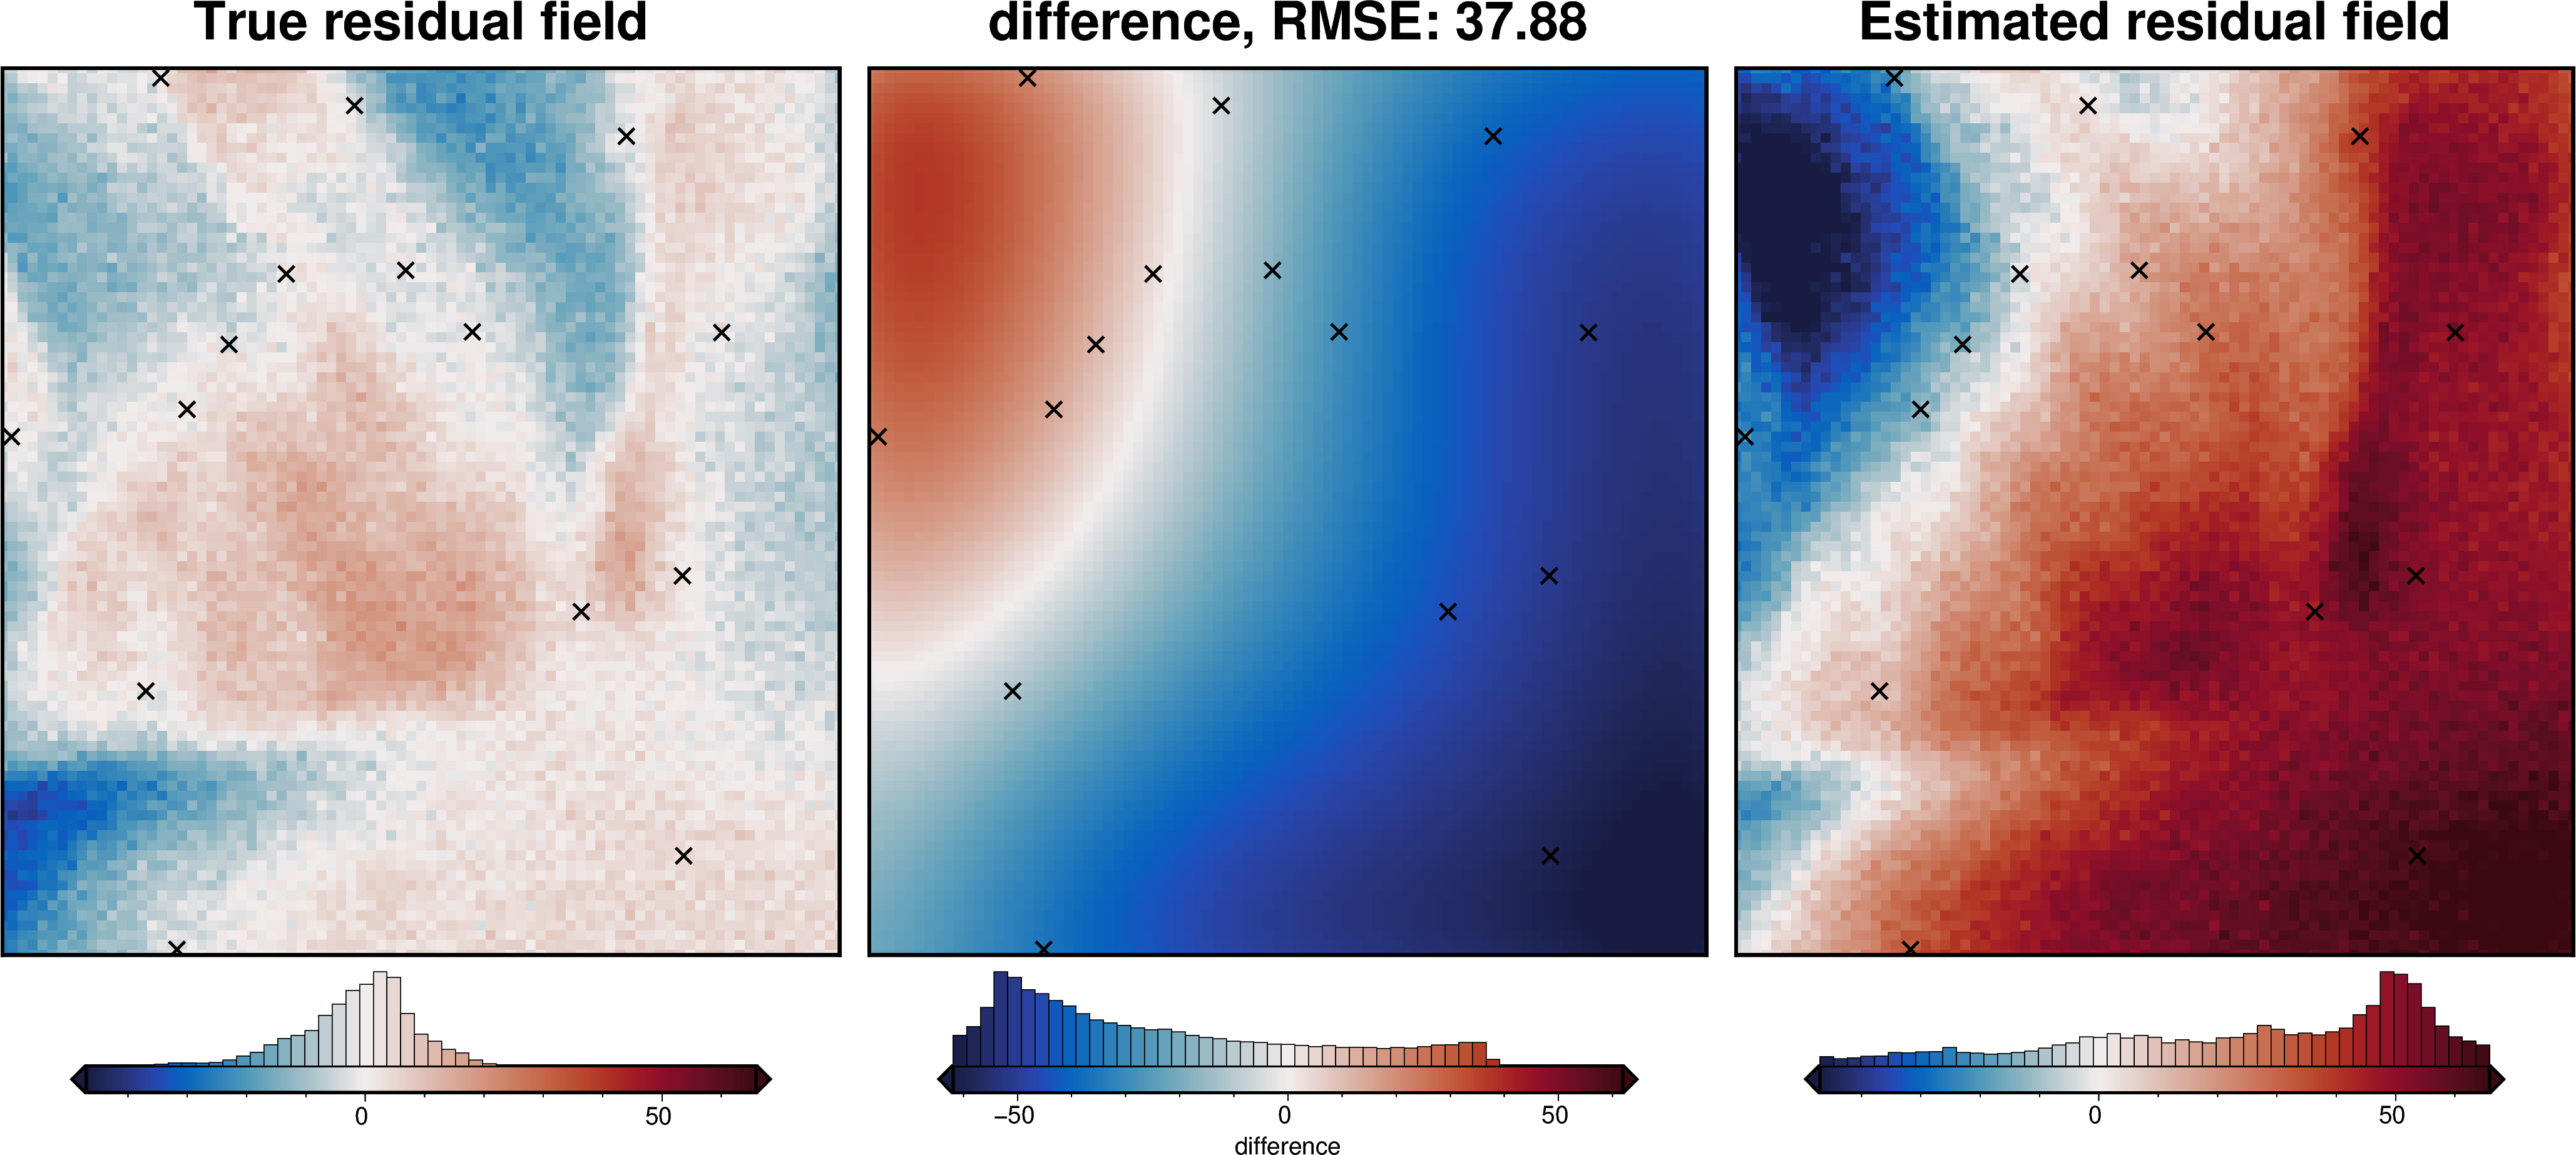

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

            misfit     reg          res  constant_reg  constant_res  \
count  7650.000000  7650.0  7650.000000  7.650000e+03   7650.000000   
mean     99.608694    75.0    24.608694  9.119170e+01      8.416995   
std      30.581609     0.0    30.581609  1.421178e-14     30.581609   
min      17.942842    75.0   -57.057158  9.119170e+01    -73.248856   
25%      78.143138    75.0     3.143138  9.119170e+01    -13.048560   
50%     107.150139    75.0    32.150139  9.119170e+01     15.958441   
75%     124.912841    75.0    49.912841  9.119170e+01     33.721142   
max     148.090389    75.0    73.090389  9.119170e+01     56.898690   

       constant_custom_reg  constant_custom_res  
count               7650.0          7650.000000  
mean                  75.0            24.608694  
std                    0.0            30.581609  
min                   75.0           -57.057158  
25%                   75.0             3.143138  
50%                   75.0            32.150139  
75%                   75.0            49.912841  
max                   75.0            73.090389

In [22]:
# estimate regional with the custom constant value
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constant=75,
)
grav_df["constant_custom_reg"] = grav_df.reg
grav_df["constant_custom_res"] = grav_df.res

regional_comparison(grav_df, "constant_custom_reg")

grav_df.describe()

### Filter

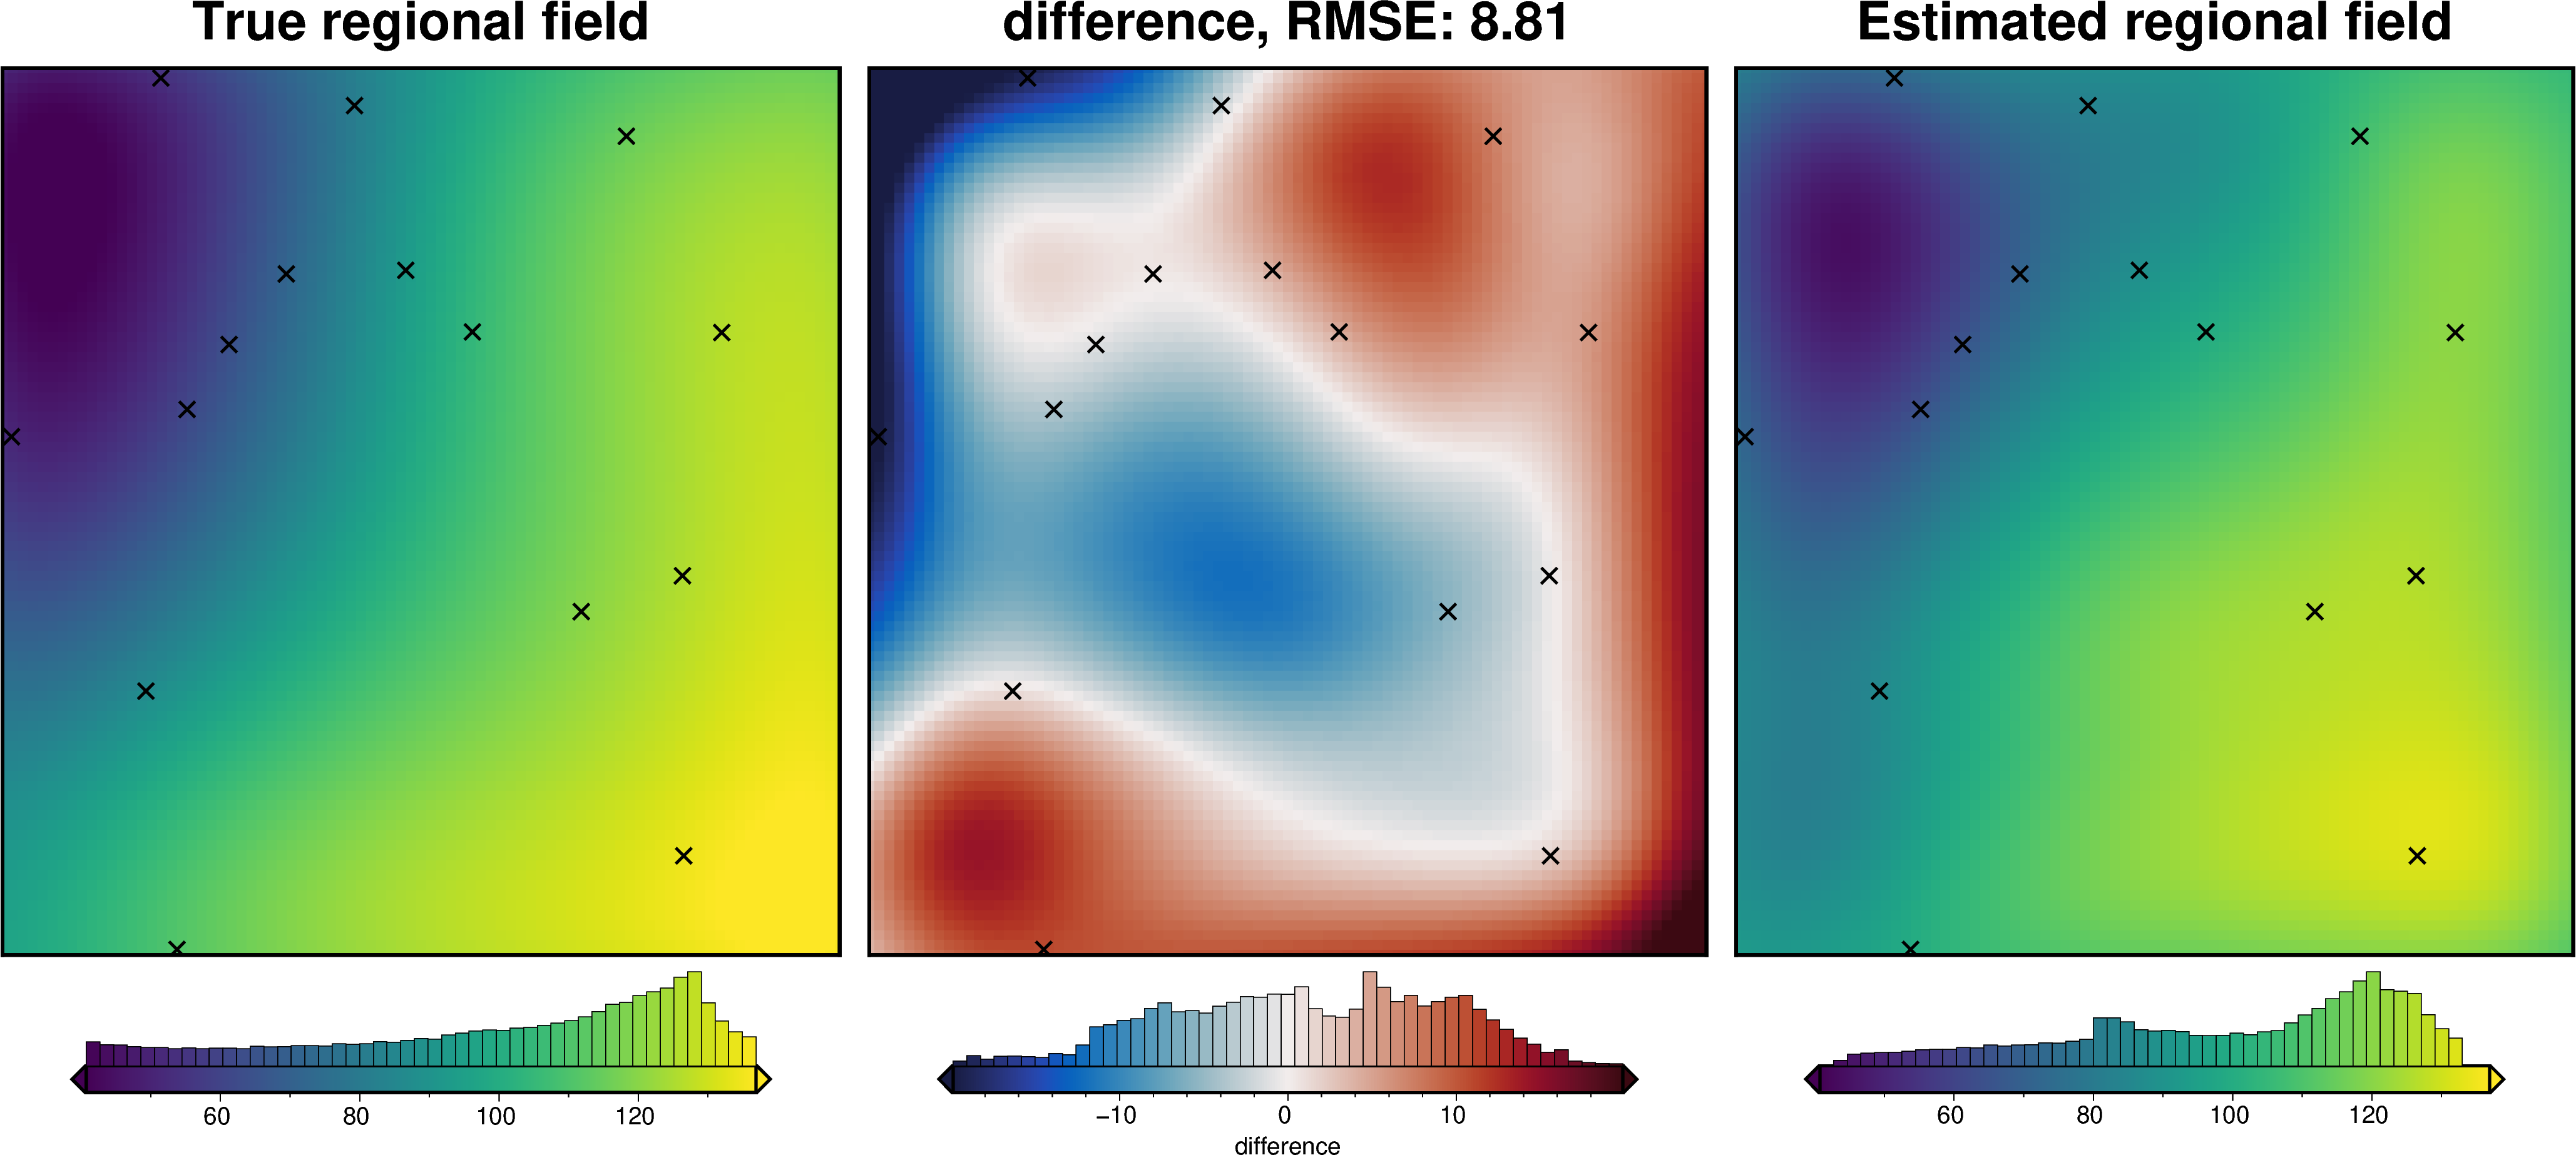

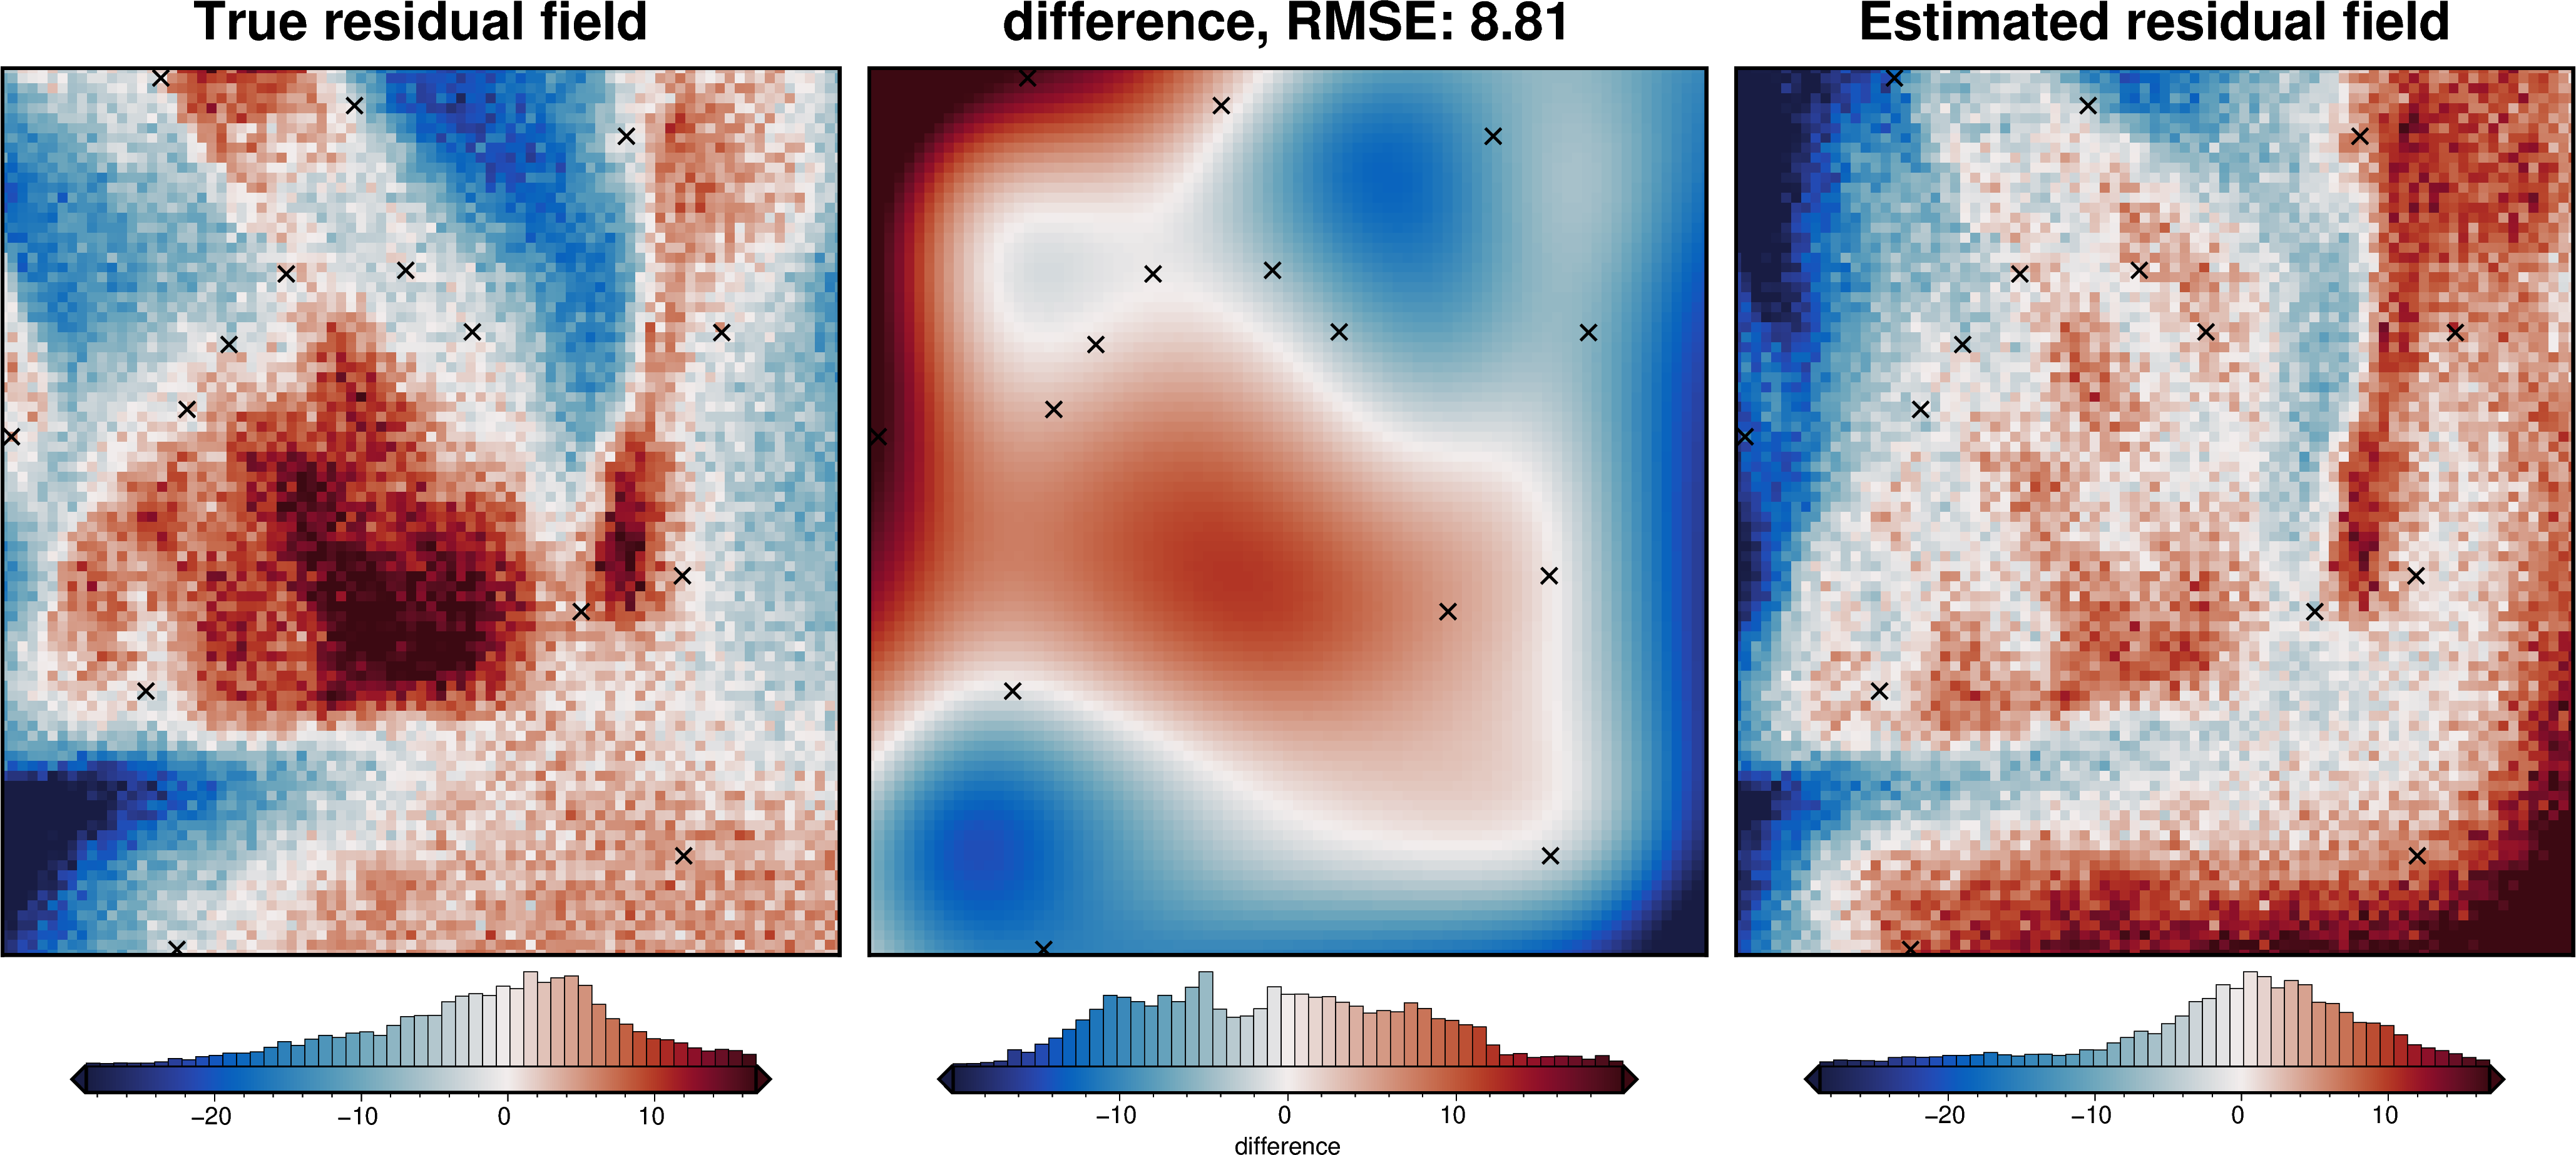

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

            misfit          res  constant_reg  constant_res  \
count  7650.000000  7650.000000  7.650000e+03   7650.000000   
mean     99.608694    -0.617067  9.119170e+01      8.416995   
std      30.581609    10.195258  1.421178e-14     30.581609   
min      17.942842   -44.353371  9.119170e+01    -73.248856   
25%      78.143138    -4.395639  9.119170e+01    -13.048560   
50%     107.150139     0.806163  9.119170e+01     15.958441   
75%     124.912841     5.440691  9.119170e+01     33.721142   
max     148.090389    31.290230  9.119170e+01     56.898690   

       constant_custom_reg  constant_custom_res          reg   filter_reg  \
count               7650.0          7650.000000  7650.000000  7650.000000   
mean                  75.0            24.608694   100.225760   100.225760   
std                    0.0            30.581609    23.005264    23.005264   
min                   75.0           -57.057158    43.862171    43.862171   
25%                   75.0             3.143138    83.128181    83.128181   
50%                   75.0            32.150139   106.625721   106.625721   
75%                   75.0            49.912841   119.665783   119.665783   
max                   75.0            73.090389   132.919464   132.919464   

        filter_res  
count  7650.000000  
mean     -0.617067  
std      10.195258  
min     -44.353371  
25%      -4.395639  
50%       0.806163  
75%       5.440691  
max      31.290230

In [23]:
# estimate regional with a 200km low pass filter
grav_df = regional.regional_filter(
    grav_df=grav_df,
    filter_width=200e3,
)
grav_df["filter_reg"] = grav_df.reg
grav_df["filter_res"] = grav_df.res

regional_comparison(grav_df, "filter_reg")

grav_df.describe()

### Trend

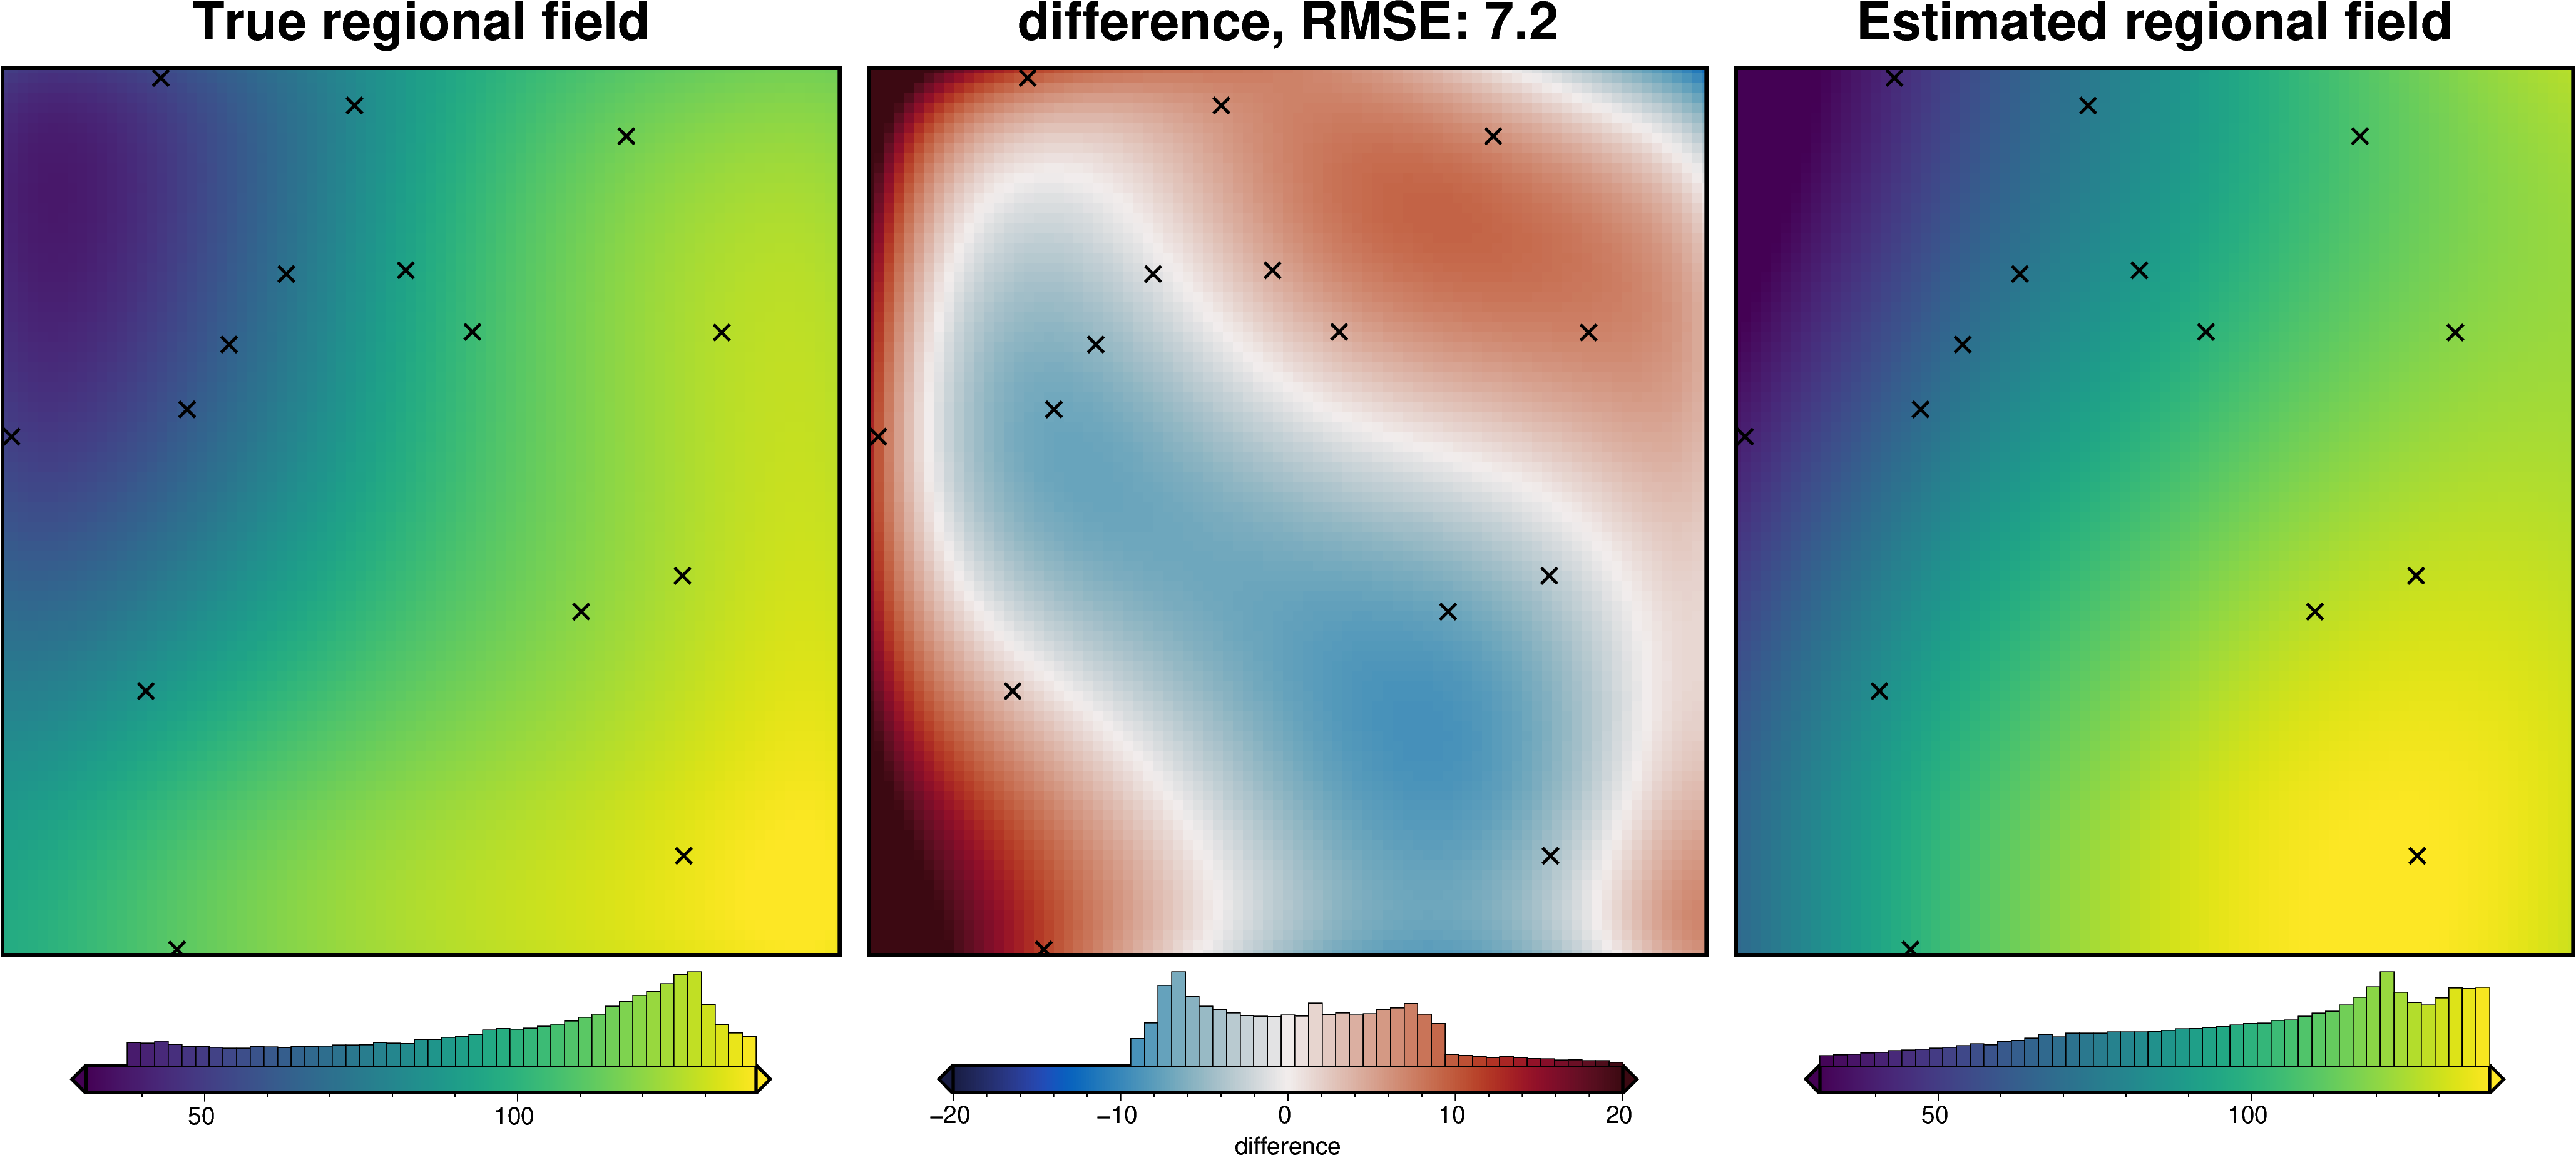

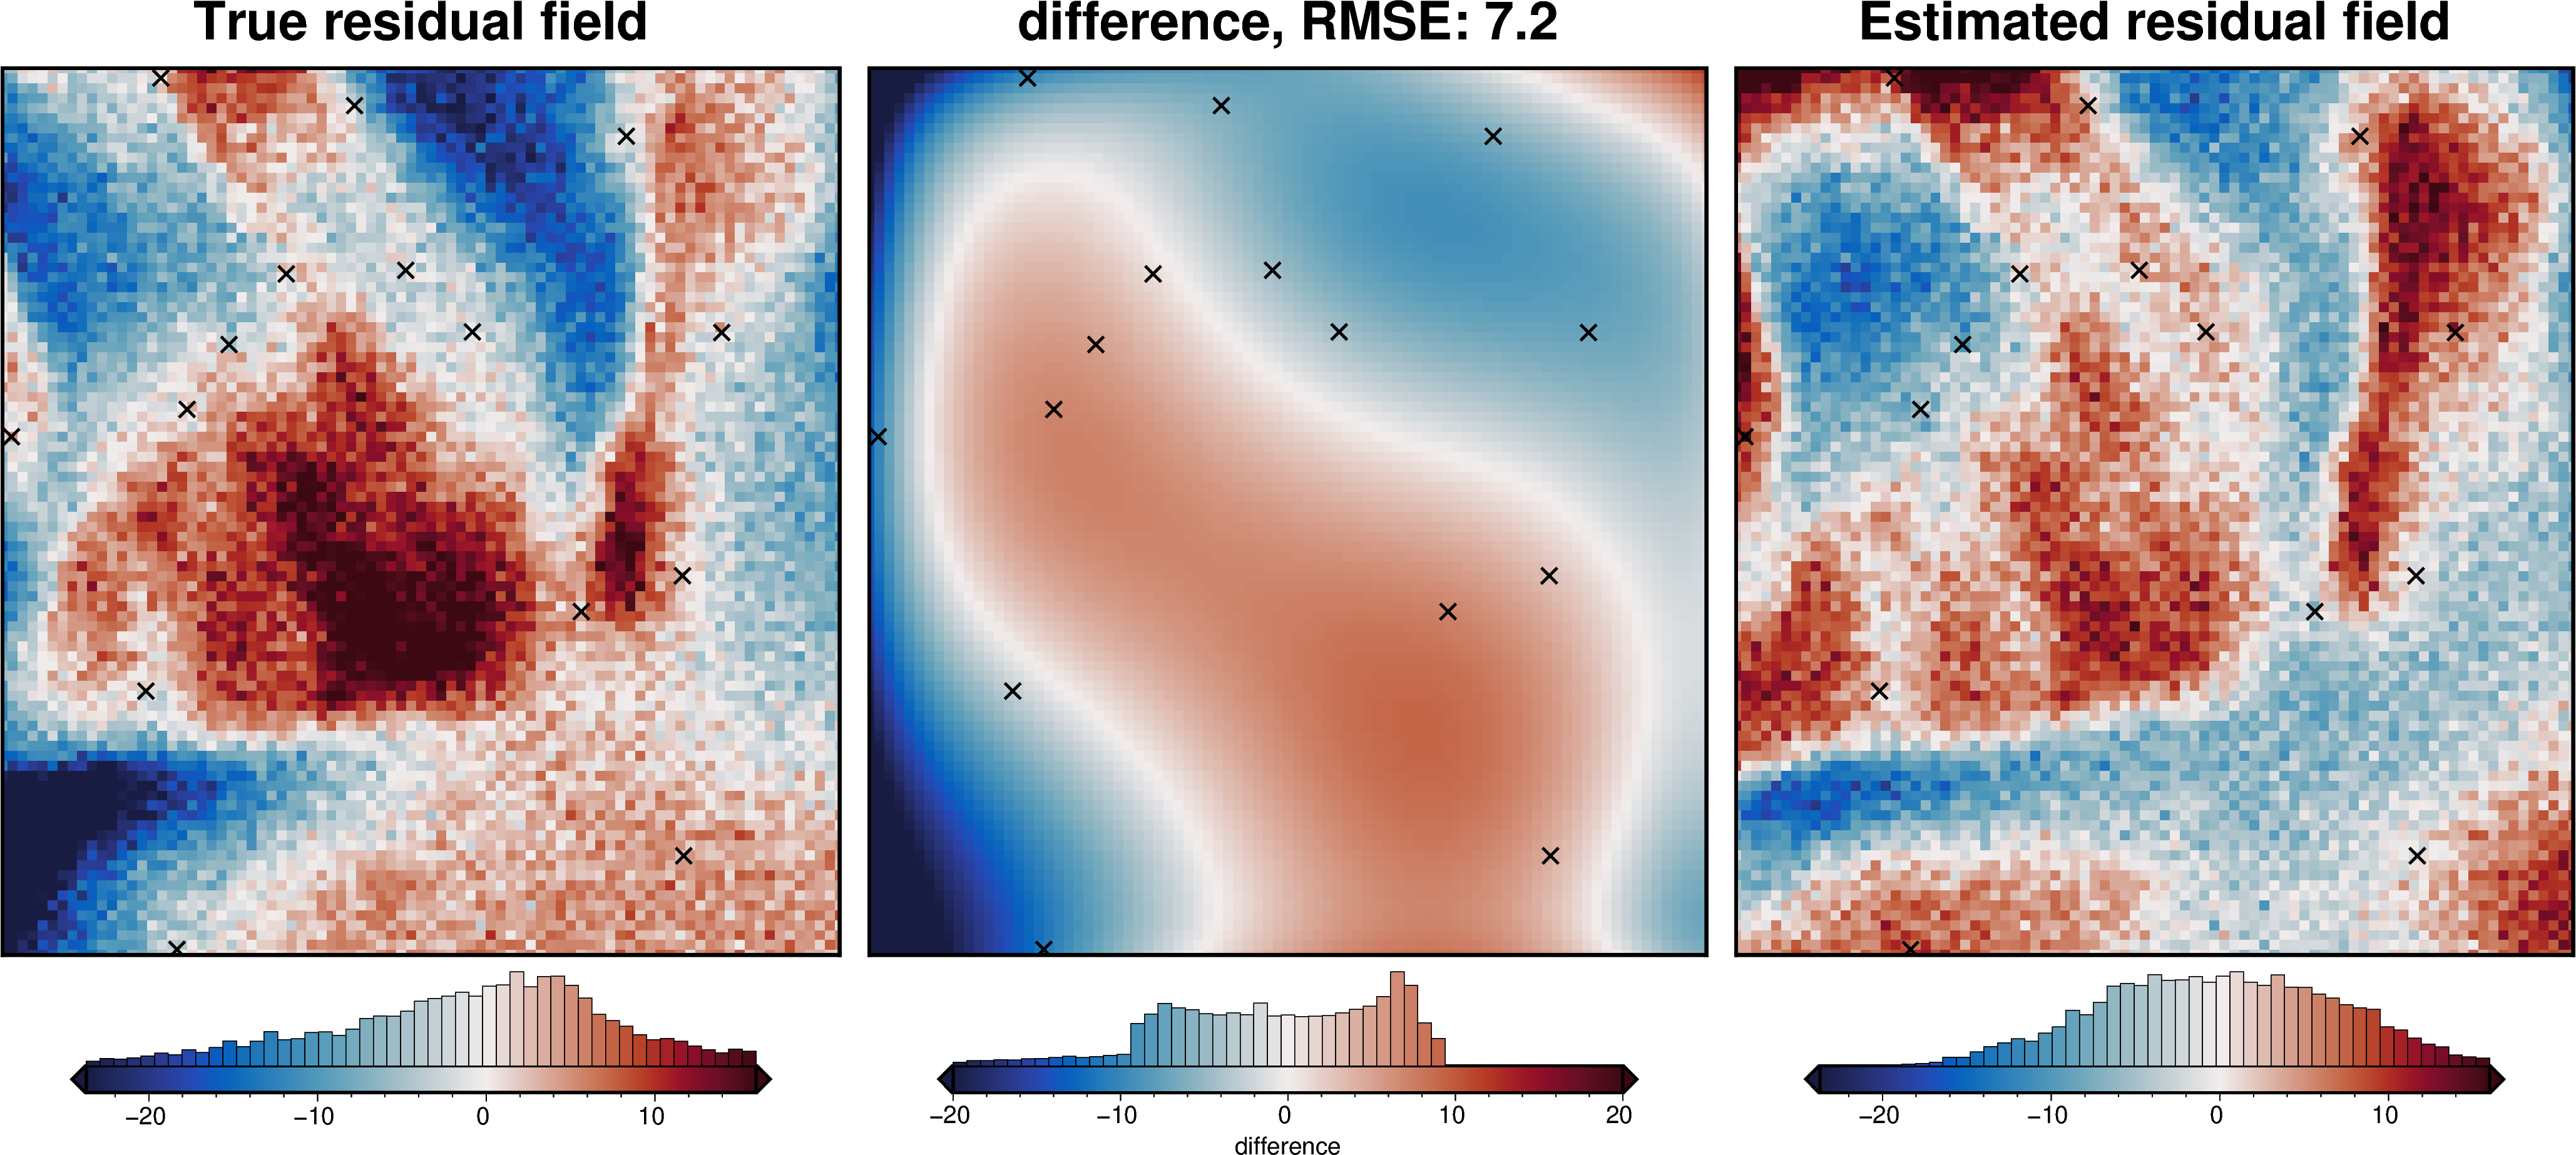

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...           res  constant_reg  constant_res  constant_custom_reg  \
count  ...  7.650000e+03  7.650000e+03   7650.000000               7650.0   
mean   ... -7.513734e-13  9.119170e+01      8.416995                 75.0   
std    ...  7.005950e+00  1.421178e-14     30.581609                  0.0   
min    ... -2.015606e+01  9.119170e+01    -73.248856                 75.0   
25%    ... -5.089756e+00  9.119170e+01    -13.048560                 75.0   
50%    ... -3.247819e-02  9.119170e+01     15.958441                 75.0   
75%    ...  5.122518e+00  9.119170e+01     33.721142                 75.0   
max    ...  3.065616e+01  9.119170e+01     56.898690                 75.0   

       constant_custom_res          reg   filter_reg   filter_res  \
count          7650.000000  7650.000000  7650.000000  7650.000000   
mean             24.608694    99.608694   100.225760    -0.617067   
std              30.581609    29.768297    23.005264    10.195258   
min             -57.057158    16.420129    43.862171   -44.353371   
25%               3.143138    78.401816    83.128181    -4.395639   
50%              32.150139   106.923096   106.625721     0.806163   
75%              49.912841   123.773507   119.665783     5.440691   
max              73.090389   138.964569   132.919464    31.290230   

         trend_reg     trend_res  
count  7650.000000  7.650000e+03  
mean     99.608694 -7.513734e-13  
std      29.768297  7.005950e+00  
min      16.420129 -2.015606e+01  
25%      78.401816 -5.089756e+00  
50%     106.923096 -3.247819e-02  
75%     123.773507  5.122518e+00  
max     138.964569  3.065616e+01  

[8 rows x 21 columns]

In [24]:
# estimate regional with fitting a 3rd order trend
grav_df = regional.regional_trend(
    grav_df=grav_df,
    trend=3,
)
grav_df["trend_reg"] = grav_df.reg
grav_df["trend_res"] = grav_df.res

regional_comparison(grav_df, "trend_reg")

grav_df.describe()

### Equivalent Sources

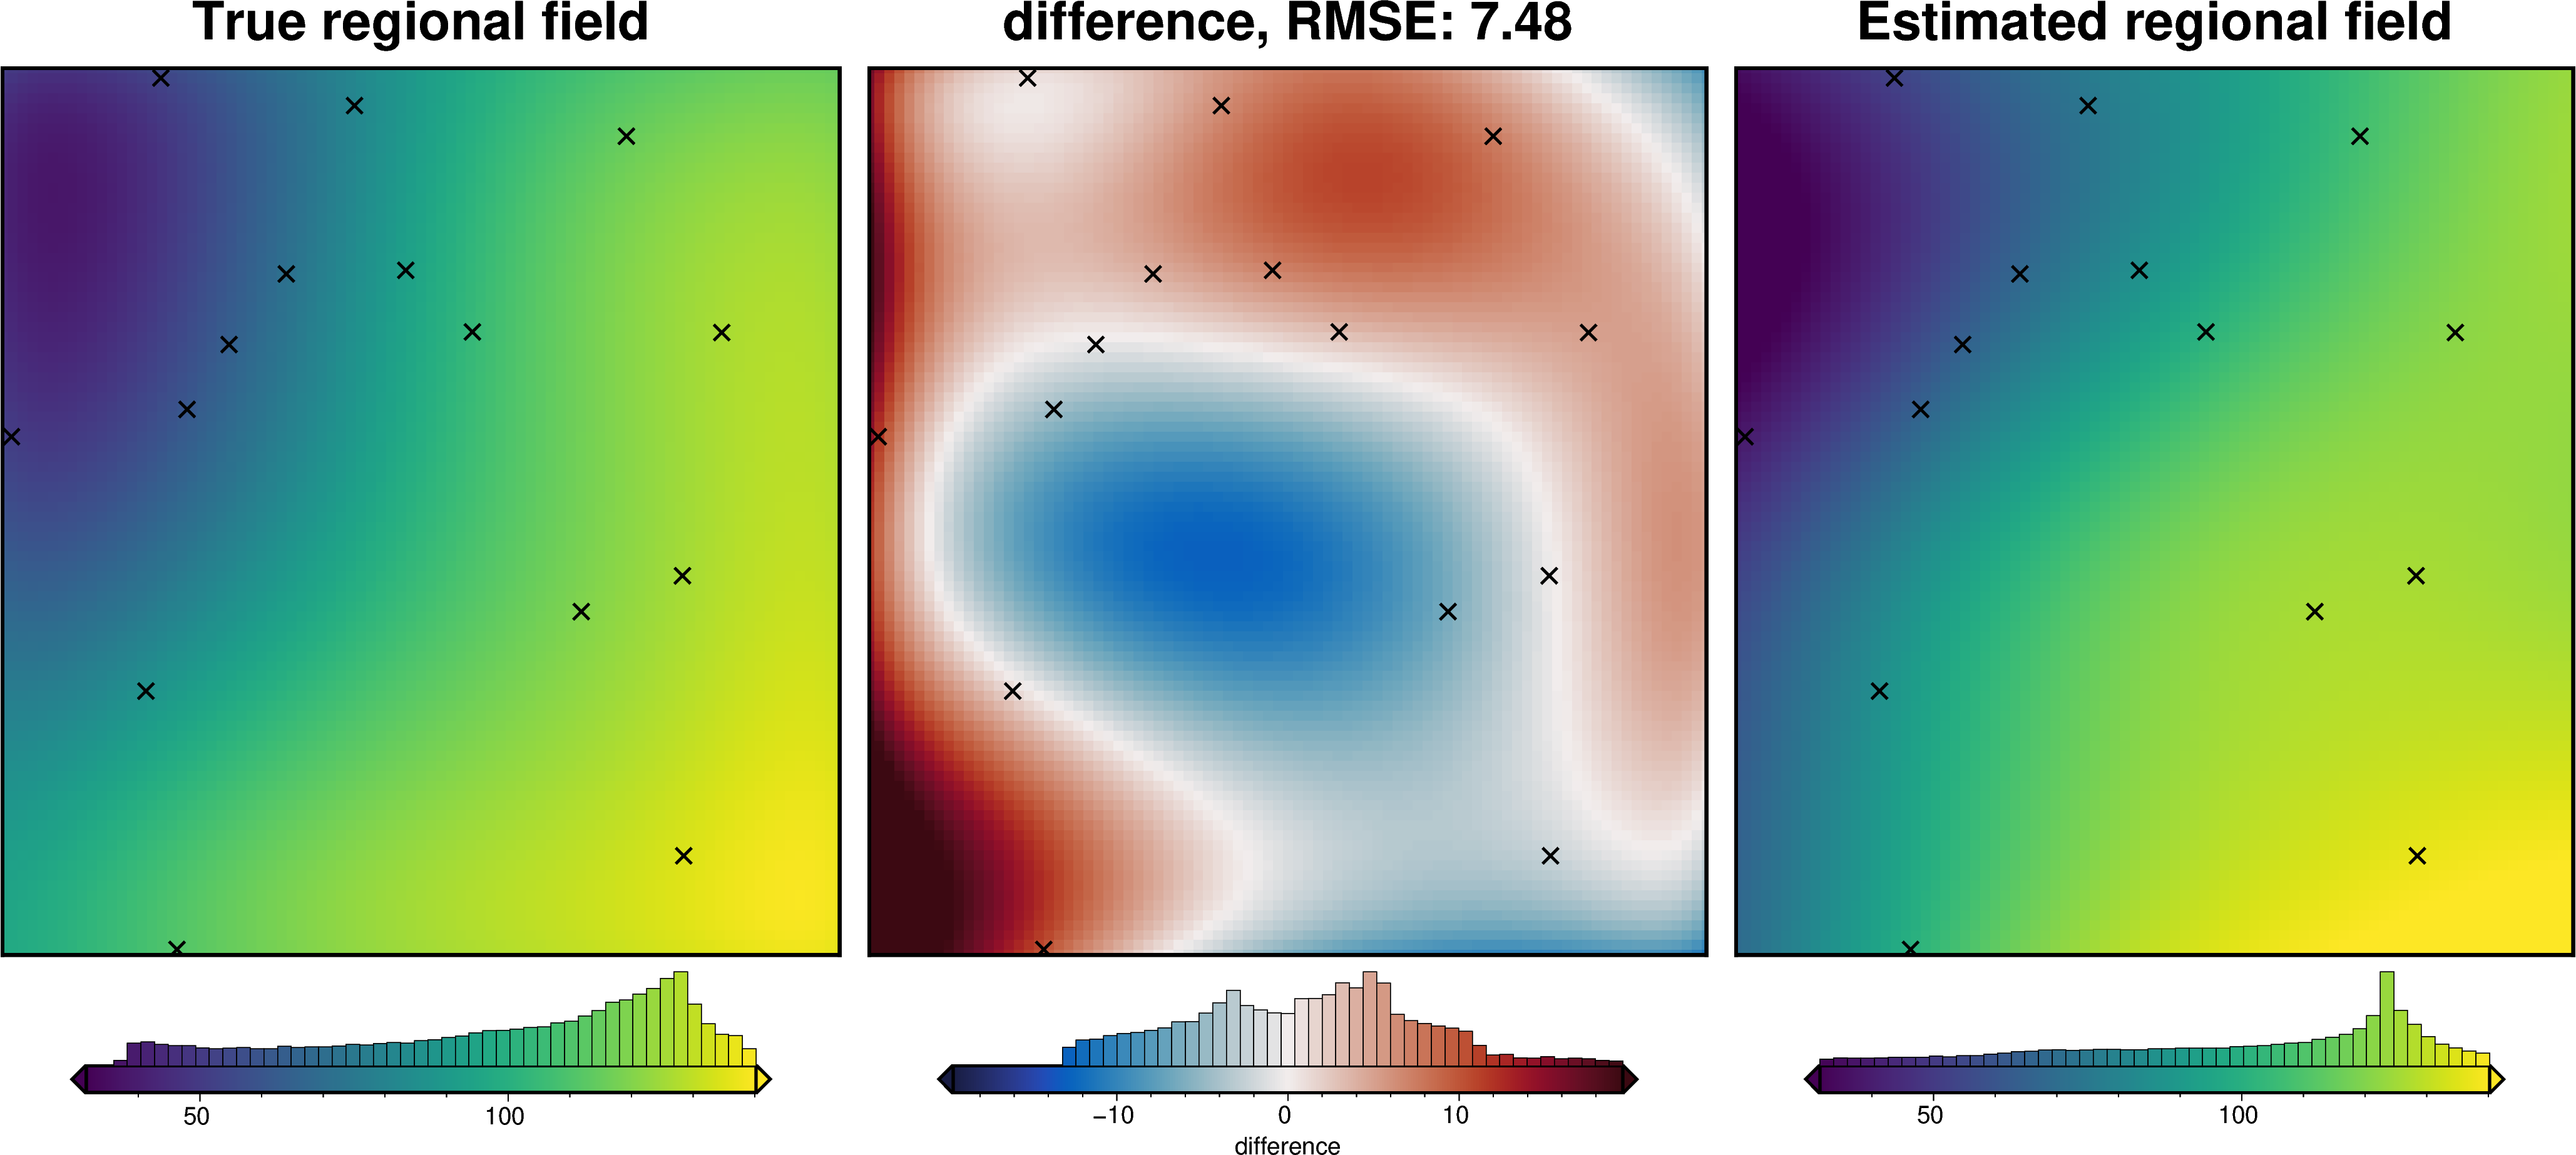

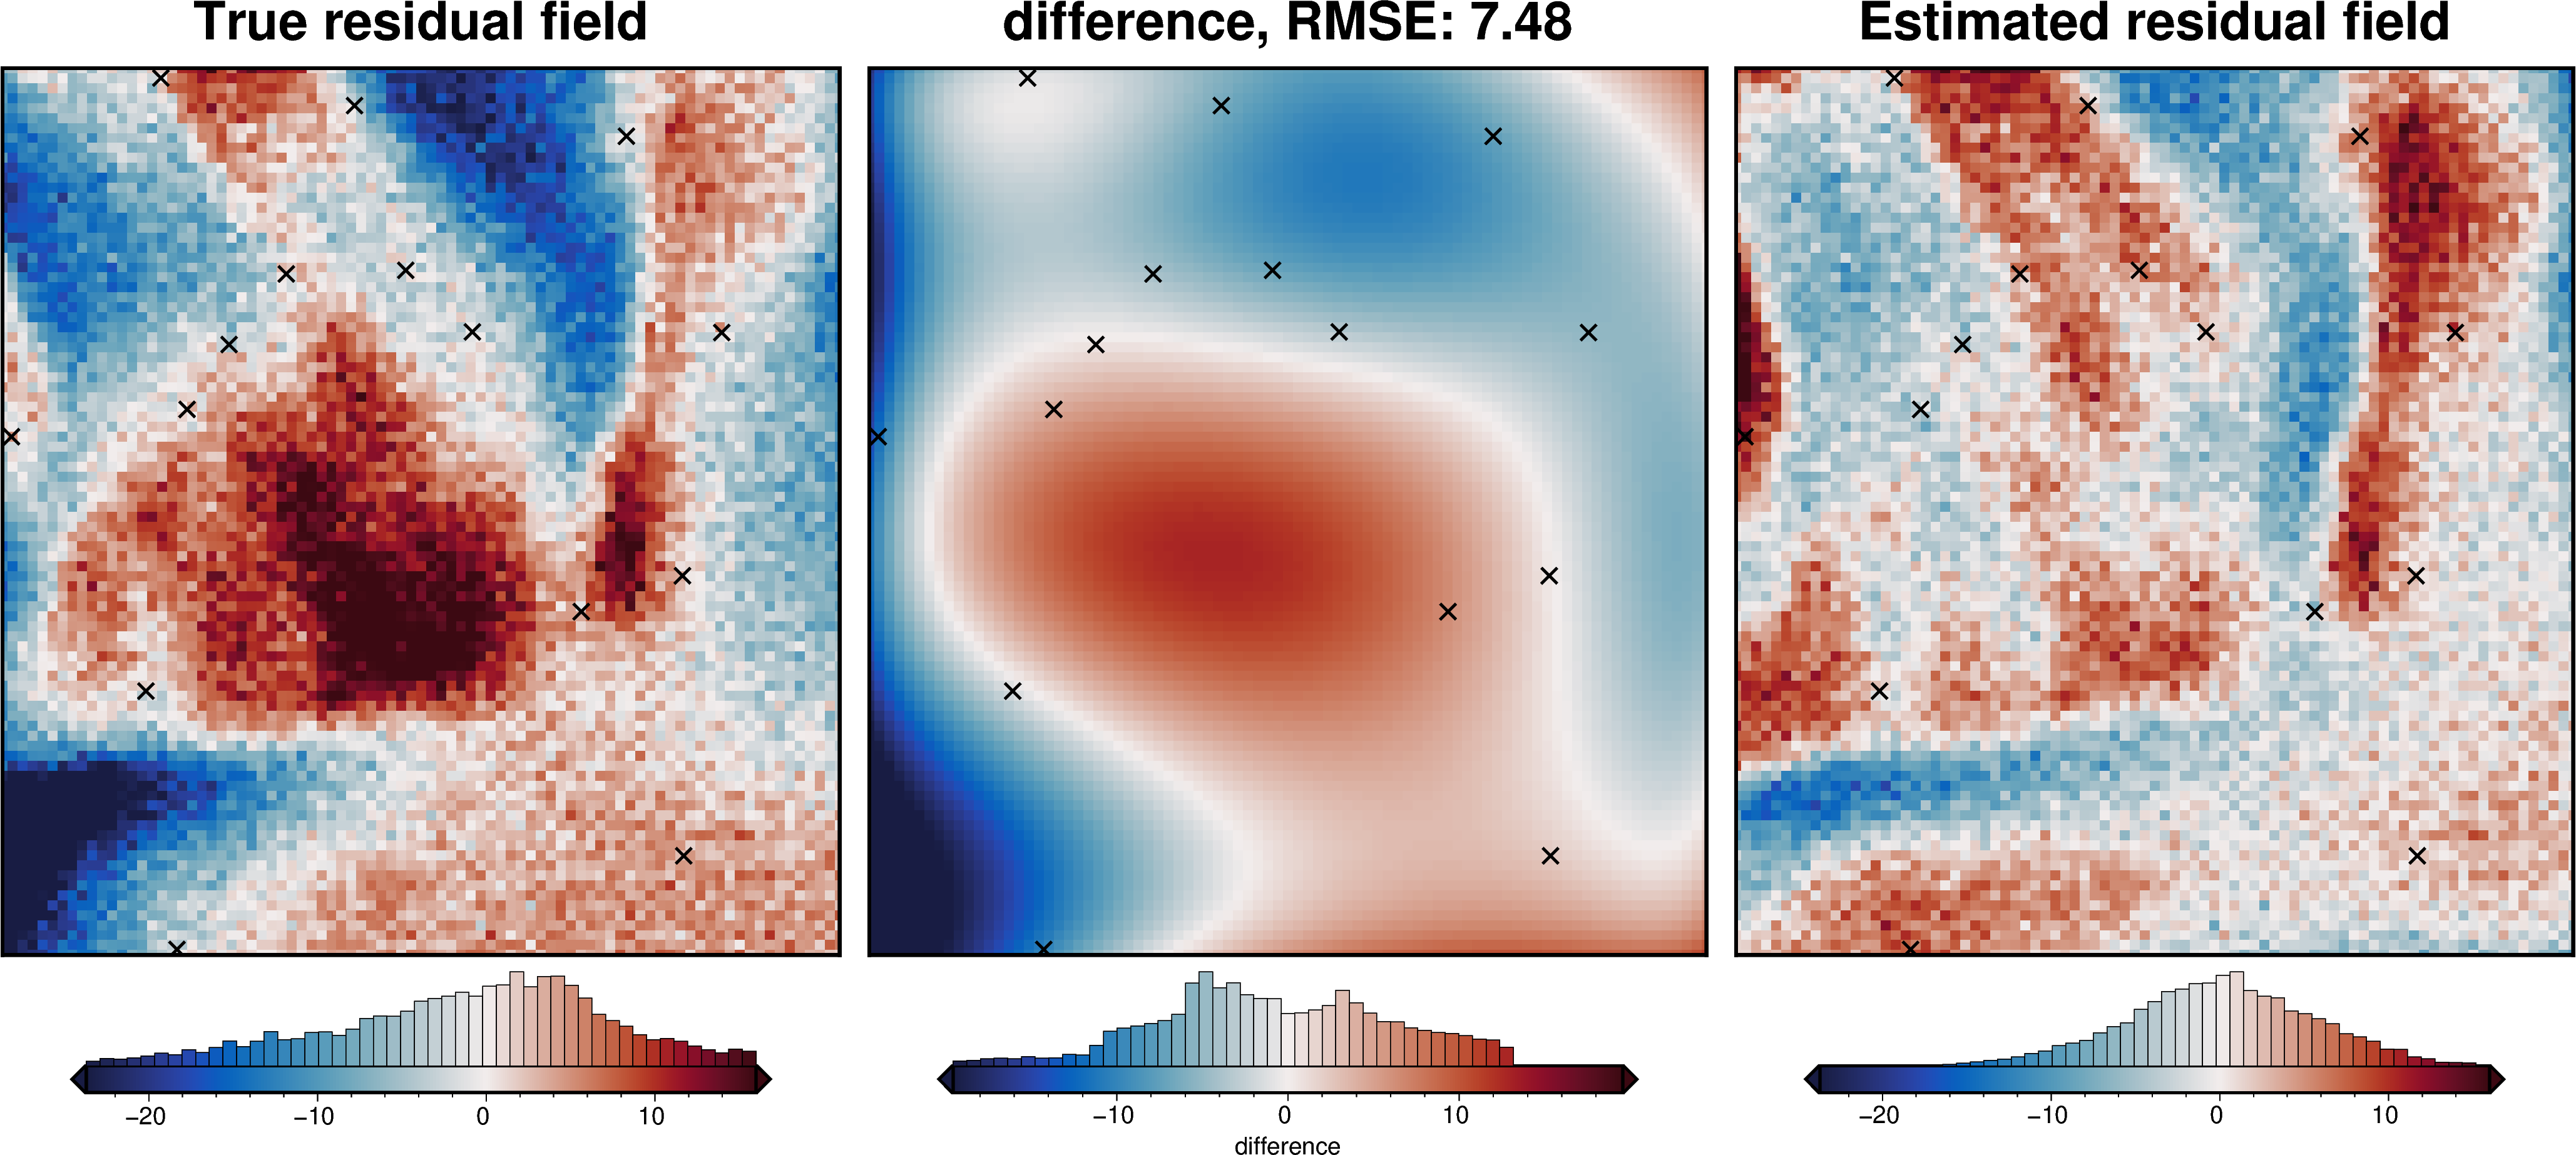

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...  constant_res  constant_custom_reg  constant_custom_res  \
count  ...   7650.000000               7650.0          7650.000000   
mean   ...      8.416995                 75.0            24.608694   
std    ...     30.581609                  0.0            30.581609   
min    ...    -73.248856                 75.0           -57.057158   
25%    ...    -13.048560                 75.0             3.143138   
50%    ...     15.958441                 75.0            32.150139   
75%    ...     33.721142                 75.0            49.912841   
max    ...     56.898690                 75.0            73.090389   

               reg   filter_reg   filter_res    trend_reg     trend_res  \
count  7650.000000  7650.000000  7650.000000  7650.000000  7.650000e+03   
mean     99.529885   100.225760    -0.617067    99.608694 -7.513734e-13   
std      29.887298    23.005264    10.195258    29.768297  7.005950e+00   
min      22.406783    43.862171   -44.353371    16.420129 -2.015606e+01   
25%      77.708304    83.128181    -4.395639    78.401816 -5.089756e+00   
50%     108.694621   106.625721     0.806163   106.923096 -3.247819e-02   
75%     123.546778   119.665783     5.440691   123.773507  5.122518e+00   
max     146.611638   132.919464    31.290230   138.964569  3.065616e+01   

       eq_sources_reg  eq_sources_res  
count     7650.000000     7650.000000  
mean        99.529885        0.078809  
std         29.887298        5.608333  
min         22.406783      -18.294135  
25%         77.708304       -3.555612  
50%        108.694621        0.084550  
75%        123.546778        3.731717  
max        146.611638       22.281547  

[8 rows x 23 columns]

In [25]:
# estimate regional with equivalent sources. This estimates the longwavlength component
# by either
# 1) using deep sources (`depth` parameter)
# 2) upwards continuing the fitted data (`grav_obs_height` parameter)
# 3) apply damping to the fitting (`damping` parameter)
grav_df = regional.regional_eq_sources(
    grav_df=grav_df,
    depth=300e3,
    damping=0.1,
    grav_obs_height=1.5e3,
    block_size=spacing * 10,
)
grav_df["eq_sources_reg"] = grav_df.reg
grav_df["eq_sources_res"] = grav_df.res

regional_comparison(grav_df, "eq_sources_reg")

grav_df.describe()

### Constraint point minimization

#### gridding with PyGMT and tension factors

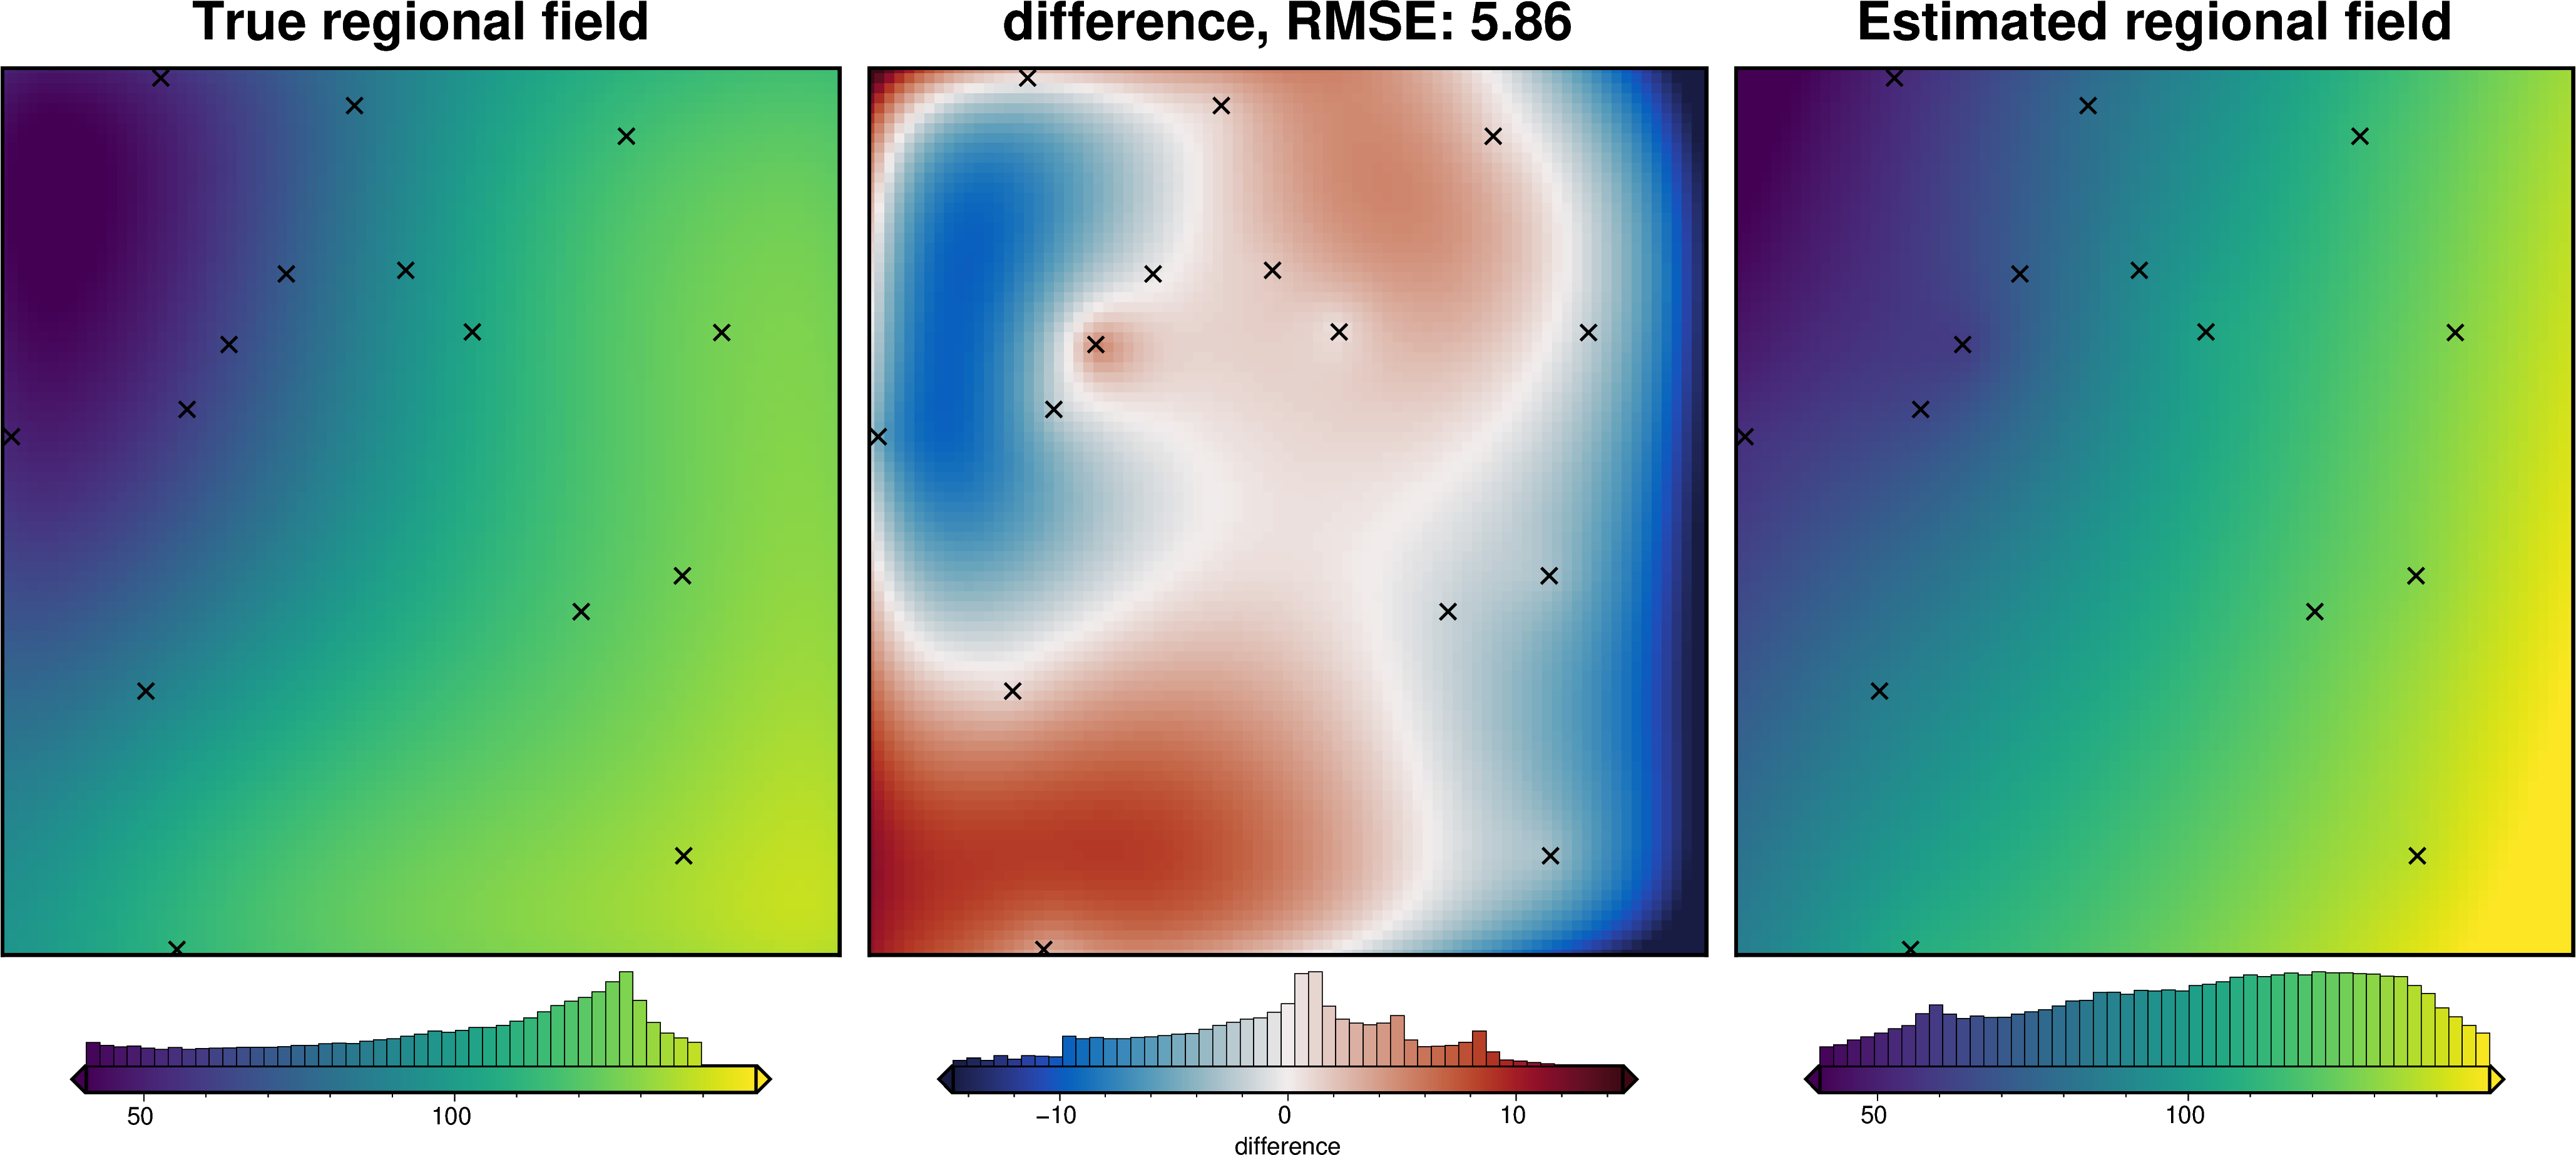

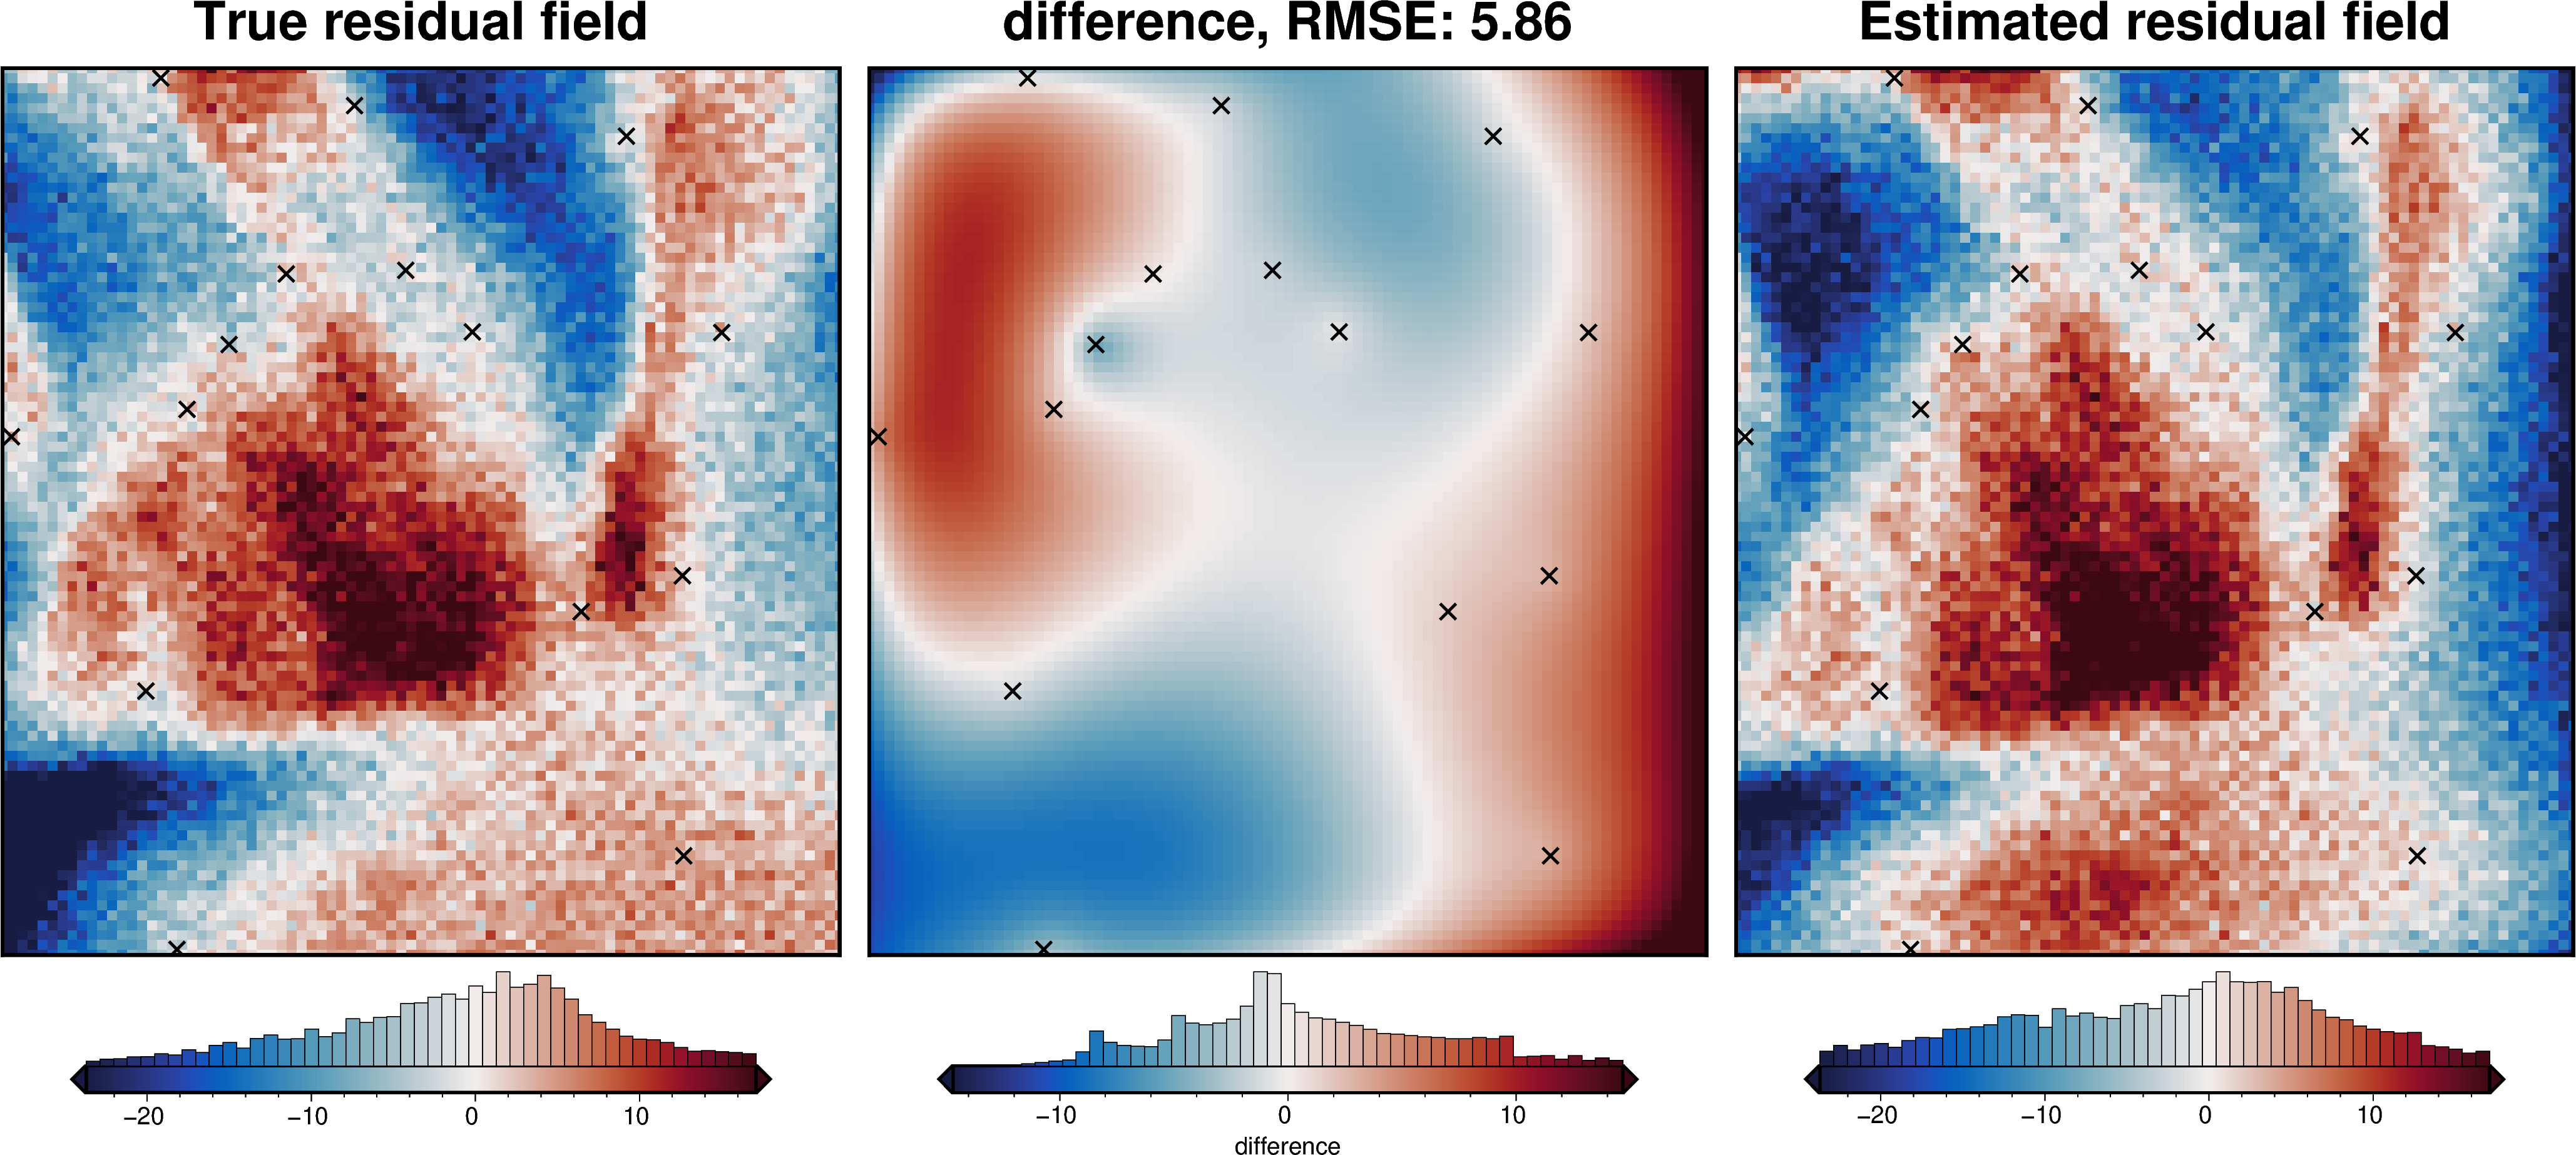

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...  constant_custom_res   filter_reg   filter_res    trend_reg  \
count  ...          7650.000000  7650.000000  7650.000000  7650.000000   
mean   ...            24.608694   100.225760    -0.617067    99.608694   
std    ...            30.581609    23.005264    10.195258    29.768297   
min    ...           -57.057158    43.862171   -44.353371    16.420129   
25%    ...             3.143138    83.128181    -4.395639    78.401816   
50%    ...            32.150139   106.625721     0.806163   106.923096   
75%    ...            49.912841   119.665783     5.440691   123.773507   
max    ...            73.090389   132.919464    31.290230   138.964569   

          trend_res  eq_sources_reg  eq_sources_res          reg  \
count  7.650000e+03     7650.000000     7650.000000  7650.000000   
mean  -7.513734e-13       99.529885        0.078809   101.843470   
std    7.005950e+00       29.887298        5.608333    28.443087   
min   -2.015606e+01       22.406783      -18.294135    33.253517   
25%   -5.089756e+00       77.708304       -3.555612    80.630211   
50%   -3.247819e-02      108.694621        0.084550   105.069168   
75%    5.122518e+00      123.546778        3.731717   125.050148   
max    3.065616e+01      146.611638       22.281547   159.096756   

       constraints_pygmt_reg  constraints_pygmt_res  
count            7650.000000            7650.000000  
mean              101.843470              -2.234777  
std                28.443087              10.085719  
min                33.253517             -30.545652  
25%                80.630211              -9.449601  
50%               105.069168              -1.090657  
75%               125.050148               4.841547  
max               159.096756              24.801272  

[8 rows x 25 columns]

In [26]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="pygmt",
    tension_factor=0.3,
)
grav_df["constraints_pygmt_reg"] = grav_df.reg
grav_df["constraints_pygmt_res"] = grav_df.res

regional_comparison(grav_df, "constraints_pygmt_reg")

grav_df.describe()

#### gridding with Verde and biharmonic splines

INFO:invert4geom:Best SplineCV score: 0.9271063746181429
INFO:invert4geom:Best damping: 1.2915496650148826e-09


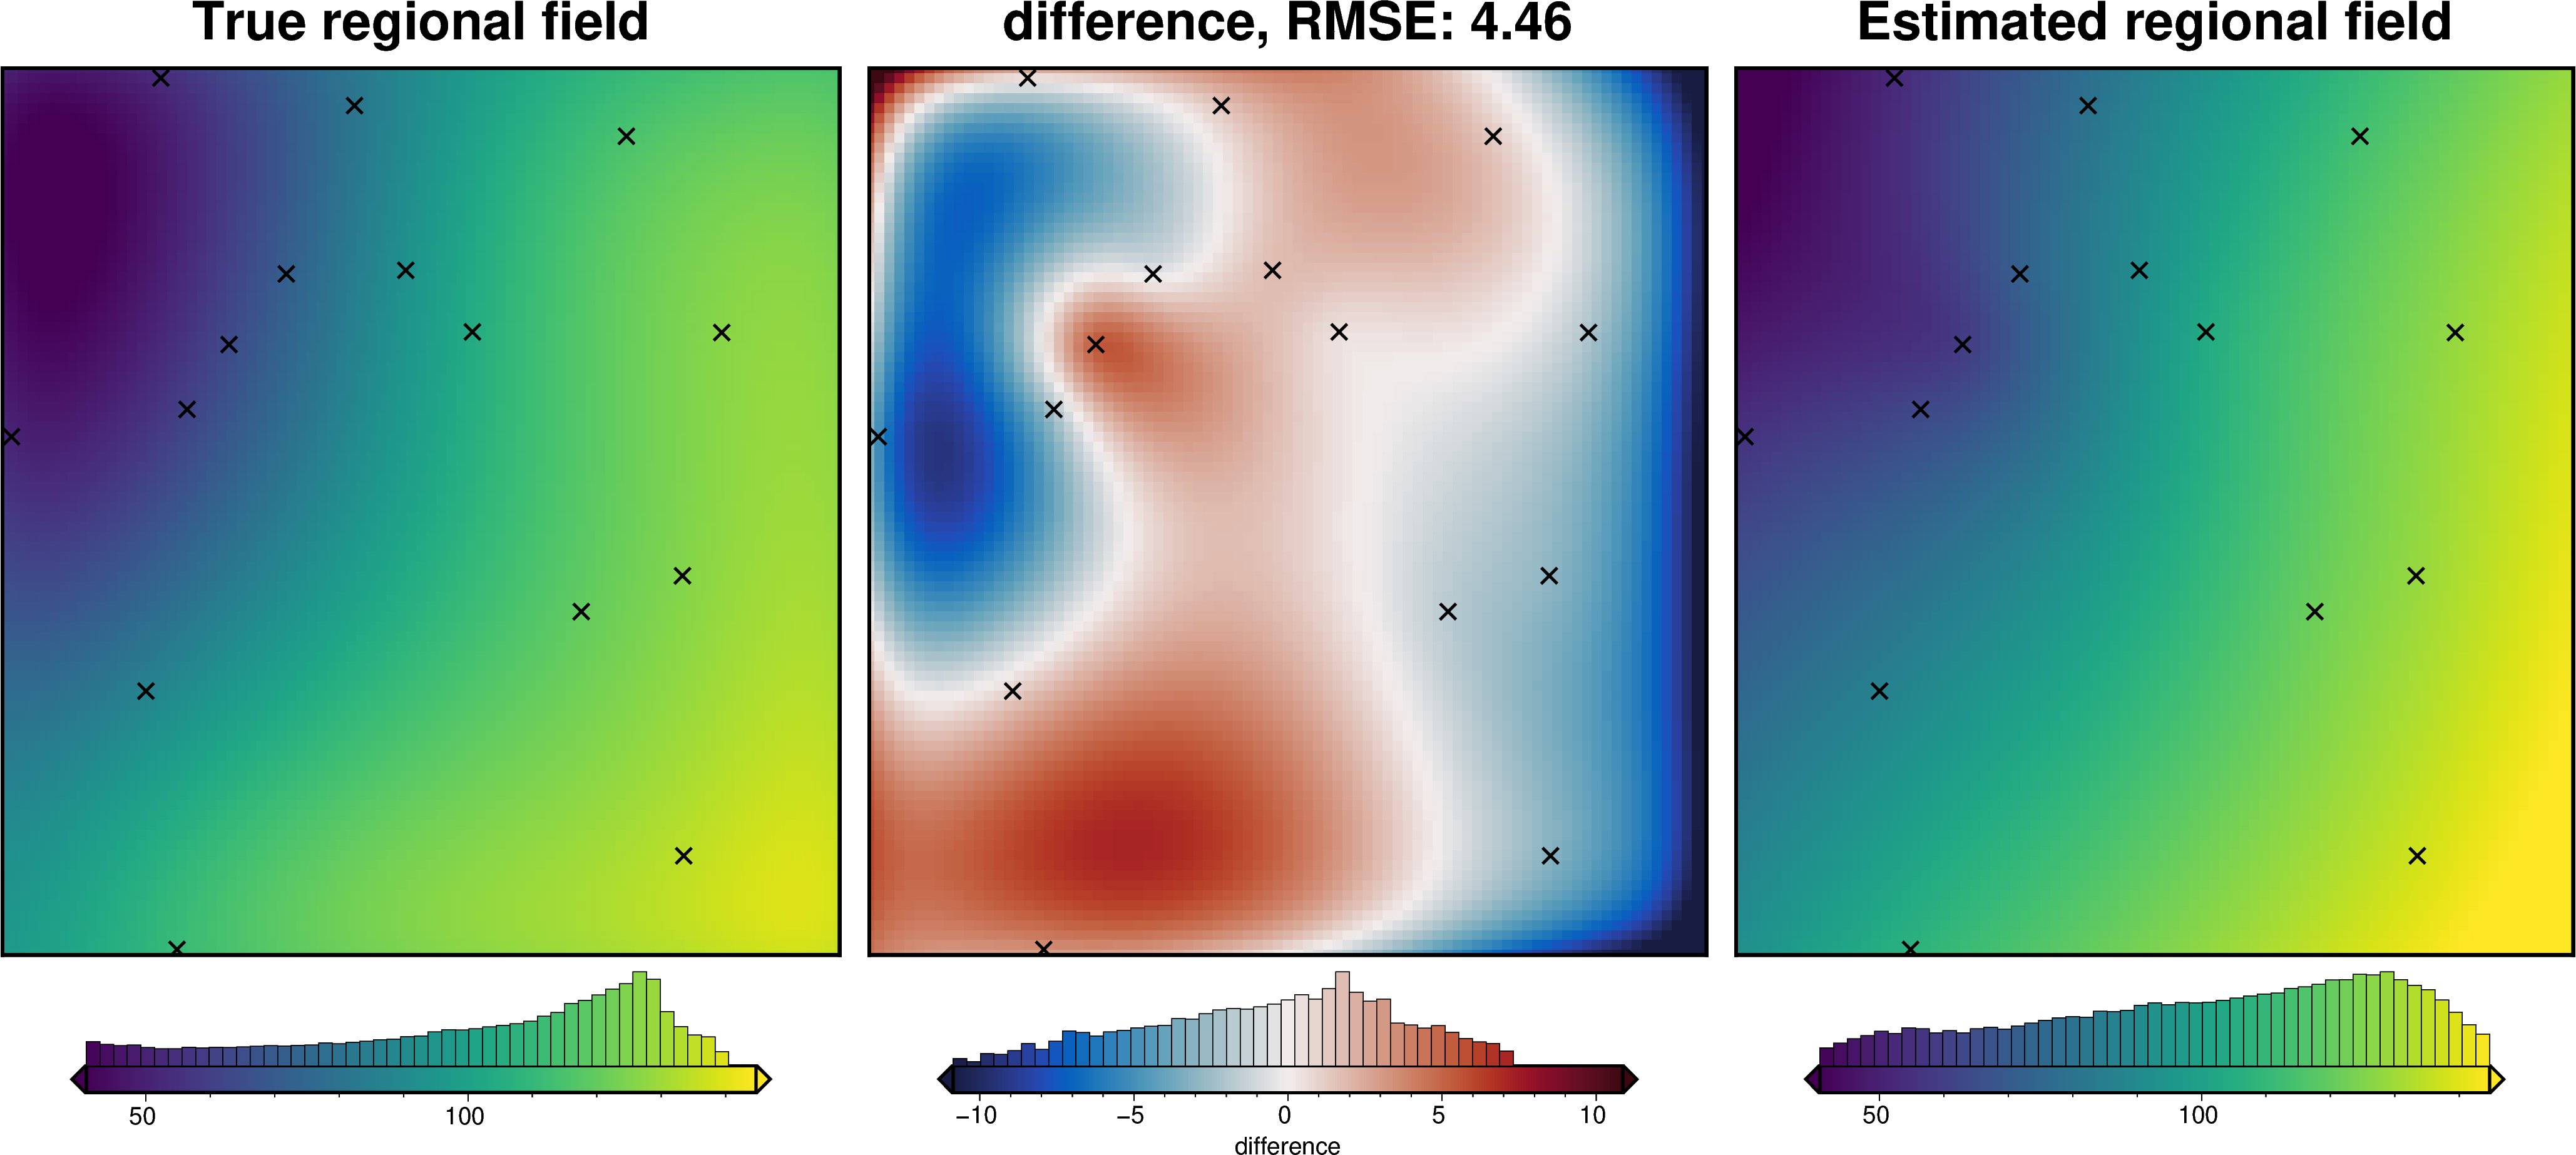

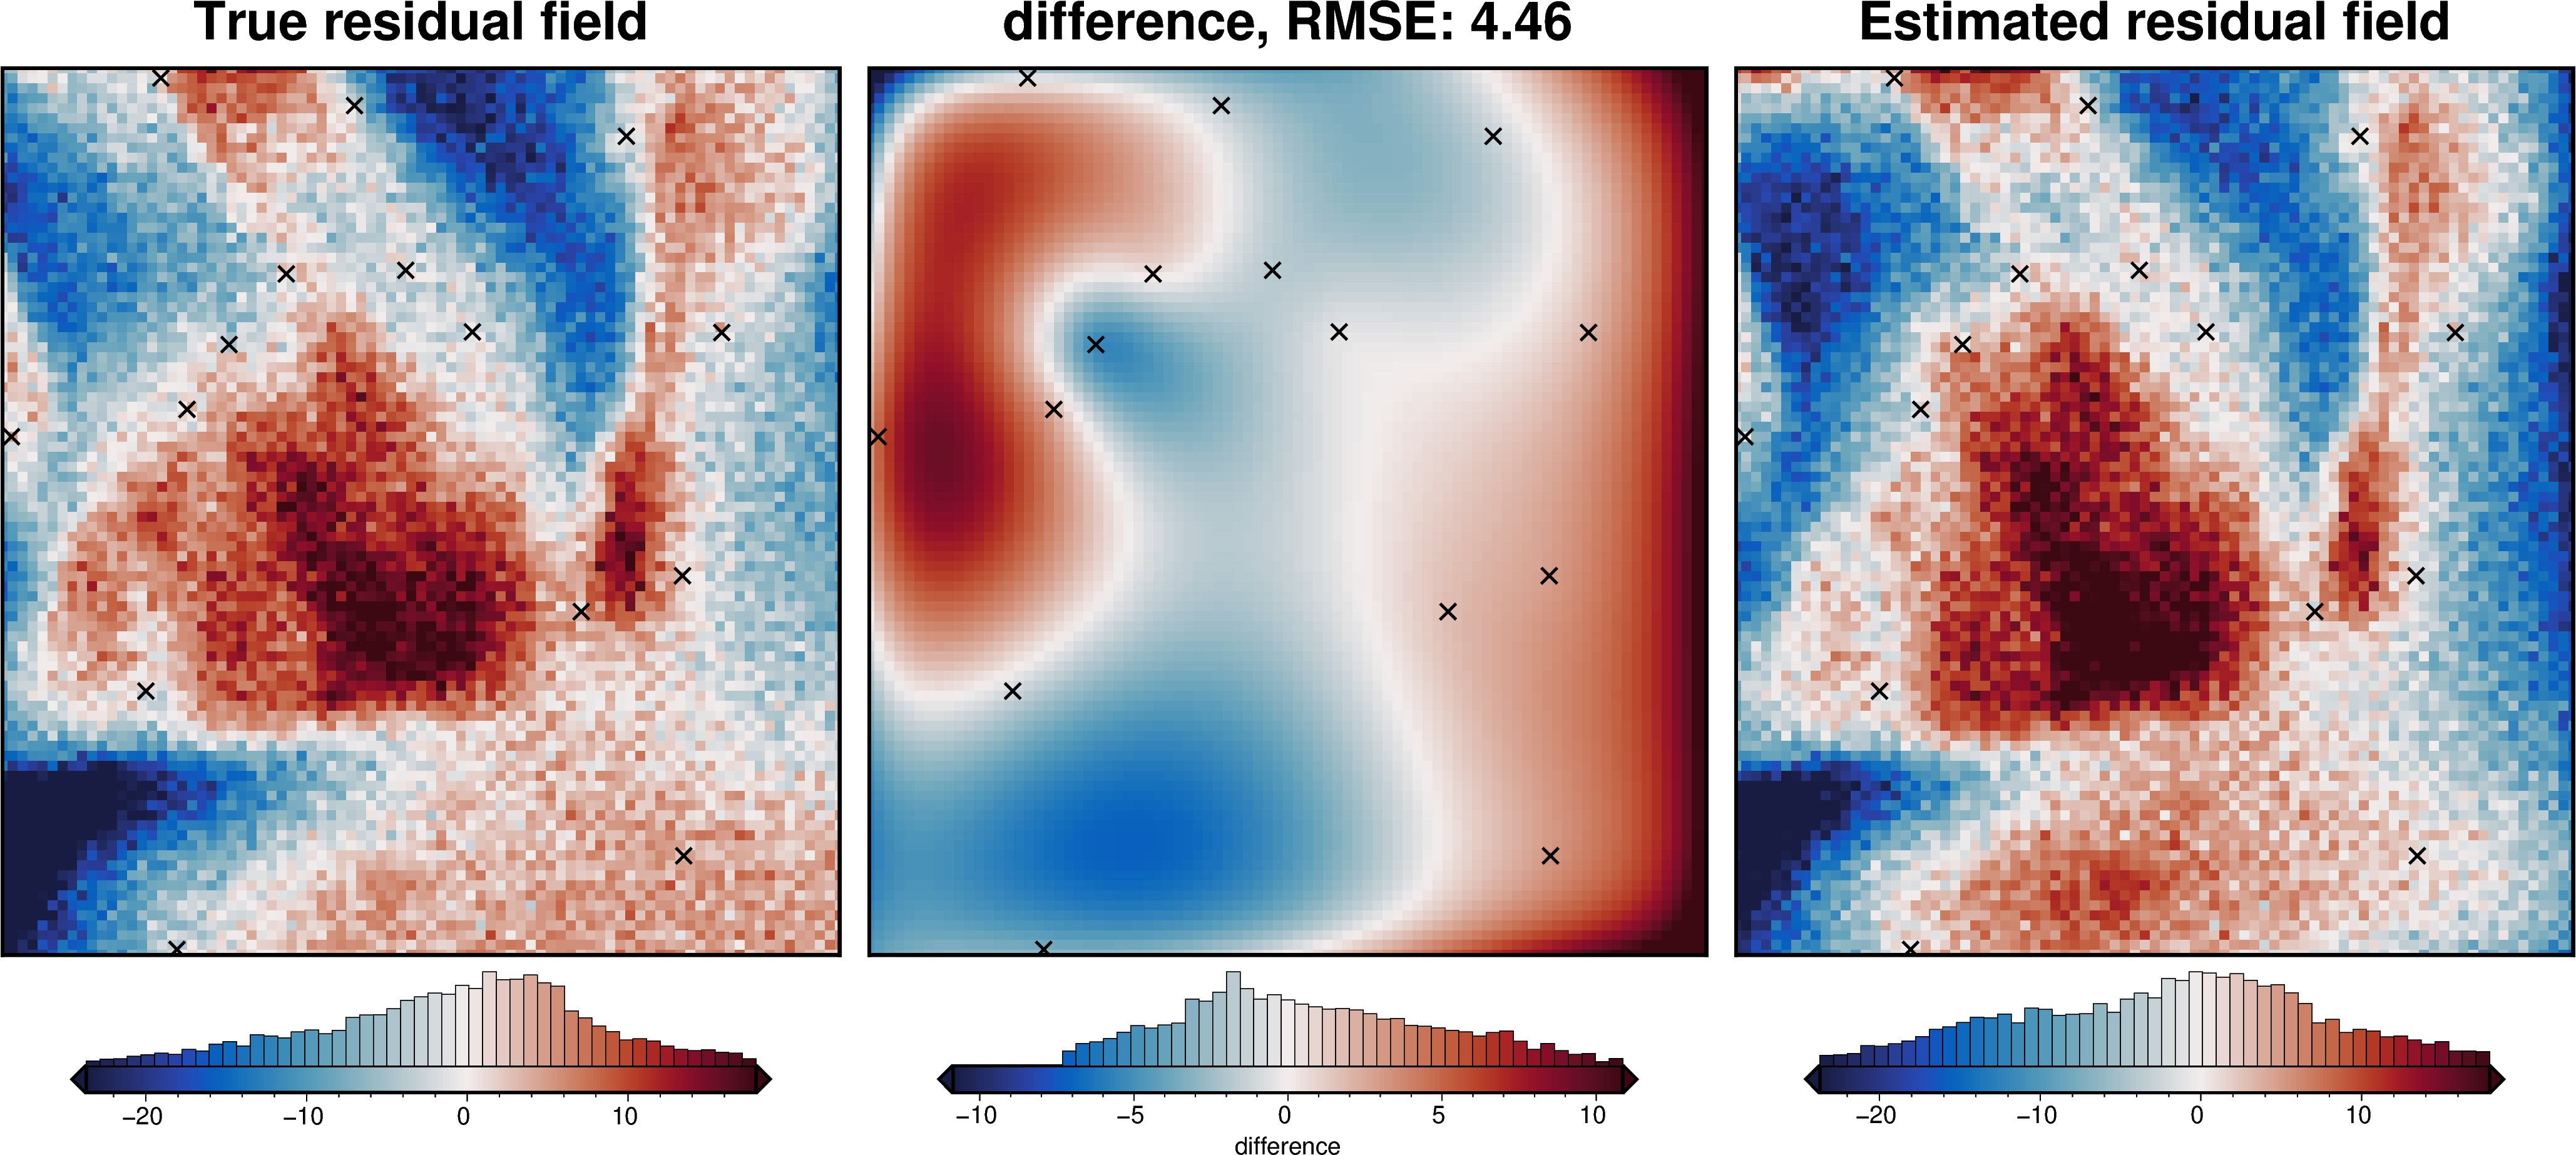

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...   filter_res    trend_reg     trend_res  eq_sources_reg  \
count  ...  7650.000000  7650.000000  7.650000e+03     7650.000000   
mean   ...    -0.617067    99.608694 -7.513734e-13       99.529885   
std    ...    10.195258    29.768297  7.005950e+00       29.887298   
min    ...   -44.353371    16.420129 -2.015606e+01       22.406783   
25%    ...    -4.395639    78.401816 -5.089756e+00       77.708304   
50%    ...     0.806163   106.923096 -3.247819e-02      108.694621   
75%    ...     5.440691   123.773507  5.122518e+00      123.546778   
max    ...    31.290230   138.964569  3.065616e+01      146.611638   

       eq_sources_res          reg  constraints_pygmt_reg  \
count     7650.000000  7650.000000            7650.000000   
mean         0.078809   101.688063             101.843470   
std          5.608333    28.039639              28.443087   
min        -18.294135    34.975867              33.253517   
25%         -3.555612    81.053890              80.630211   
50%          0.084550   106.005007             105.069168   
75%          3.731717   124.994716             125.050148   
max         22.281547   153.796027             159.096756   

       constraints_pygmt_res  constraints_verde_reg  constraints_verde_res  
count            7650.000000            7650.000000            7650.000000  
mean               -2.234777             101.688063              -2.079369  
std                10.085719              28.039639              10.010793  
min               -30.545652              34.975867             -34.421193  
25%                -9.449601              81.053890              -9.317515  
50%                -1.090657             106.005007              -1.220205  
75%                 4.841547             124.994716               4.661532  
max                24.801272             153.796027              25.245437  

[8 rows x 27 columns]

In [27]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="verde",
    spline_dampings=np.logspace(-20, 0, 10),
)
grav_df["constraints_verde_reg"] = grav_df.reg
grav_df["constraints_verde_res"] = grav_df.res

regional_comparison(grav_df, "constraints_verde_reg")

grav_df.describe()

#### gridding with Equivalent sources

INFO:invert4geom:using 5 startup trials


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 19
INFO:invert4geom:	parameter: {'damping': 0.0002022812045753343}
INFO:invert4geom:	scores: [0.9002016641168202]


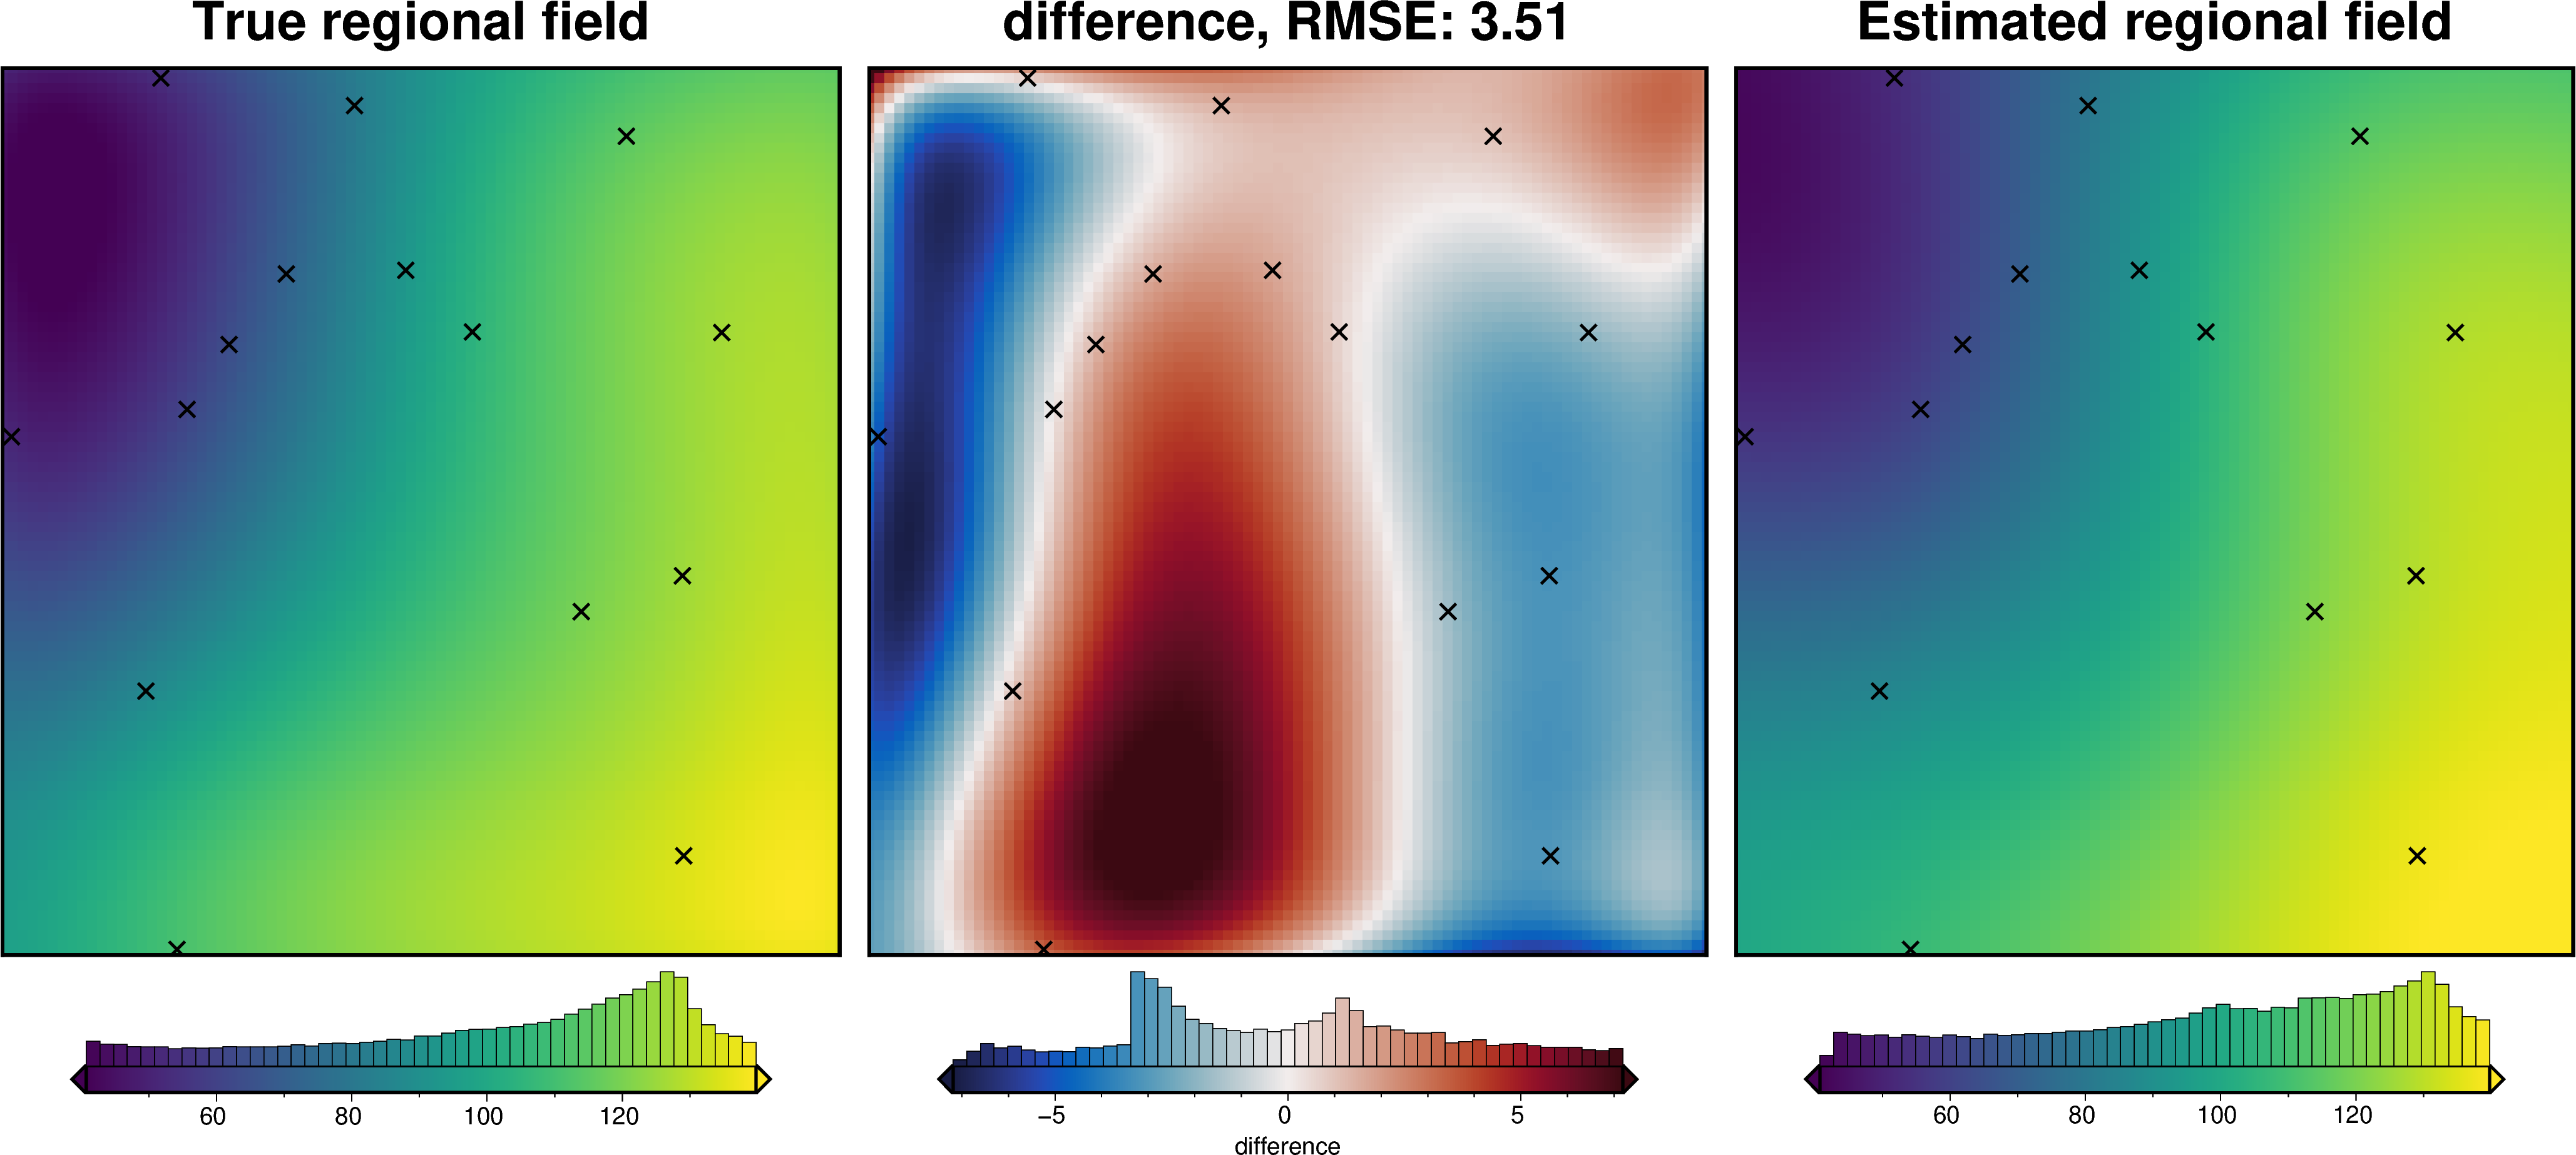

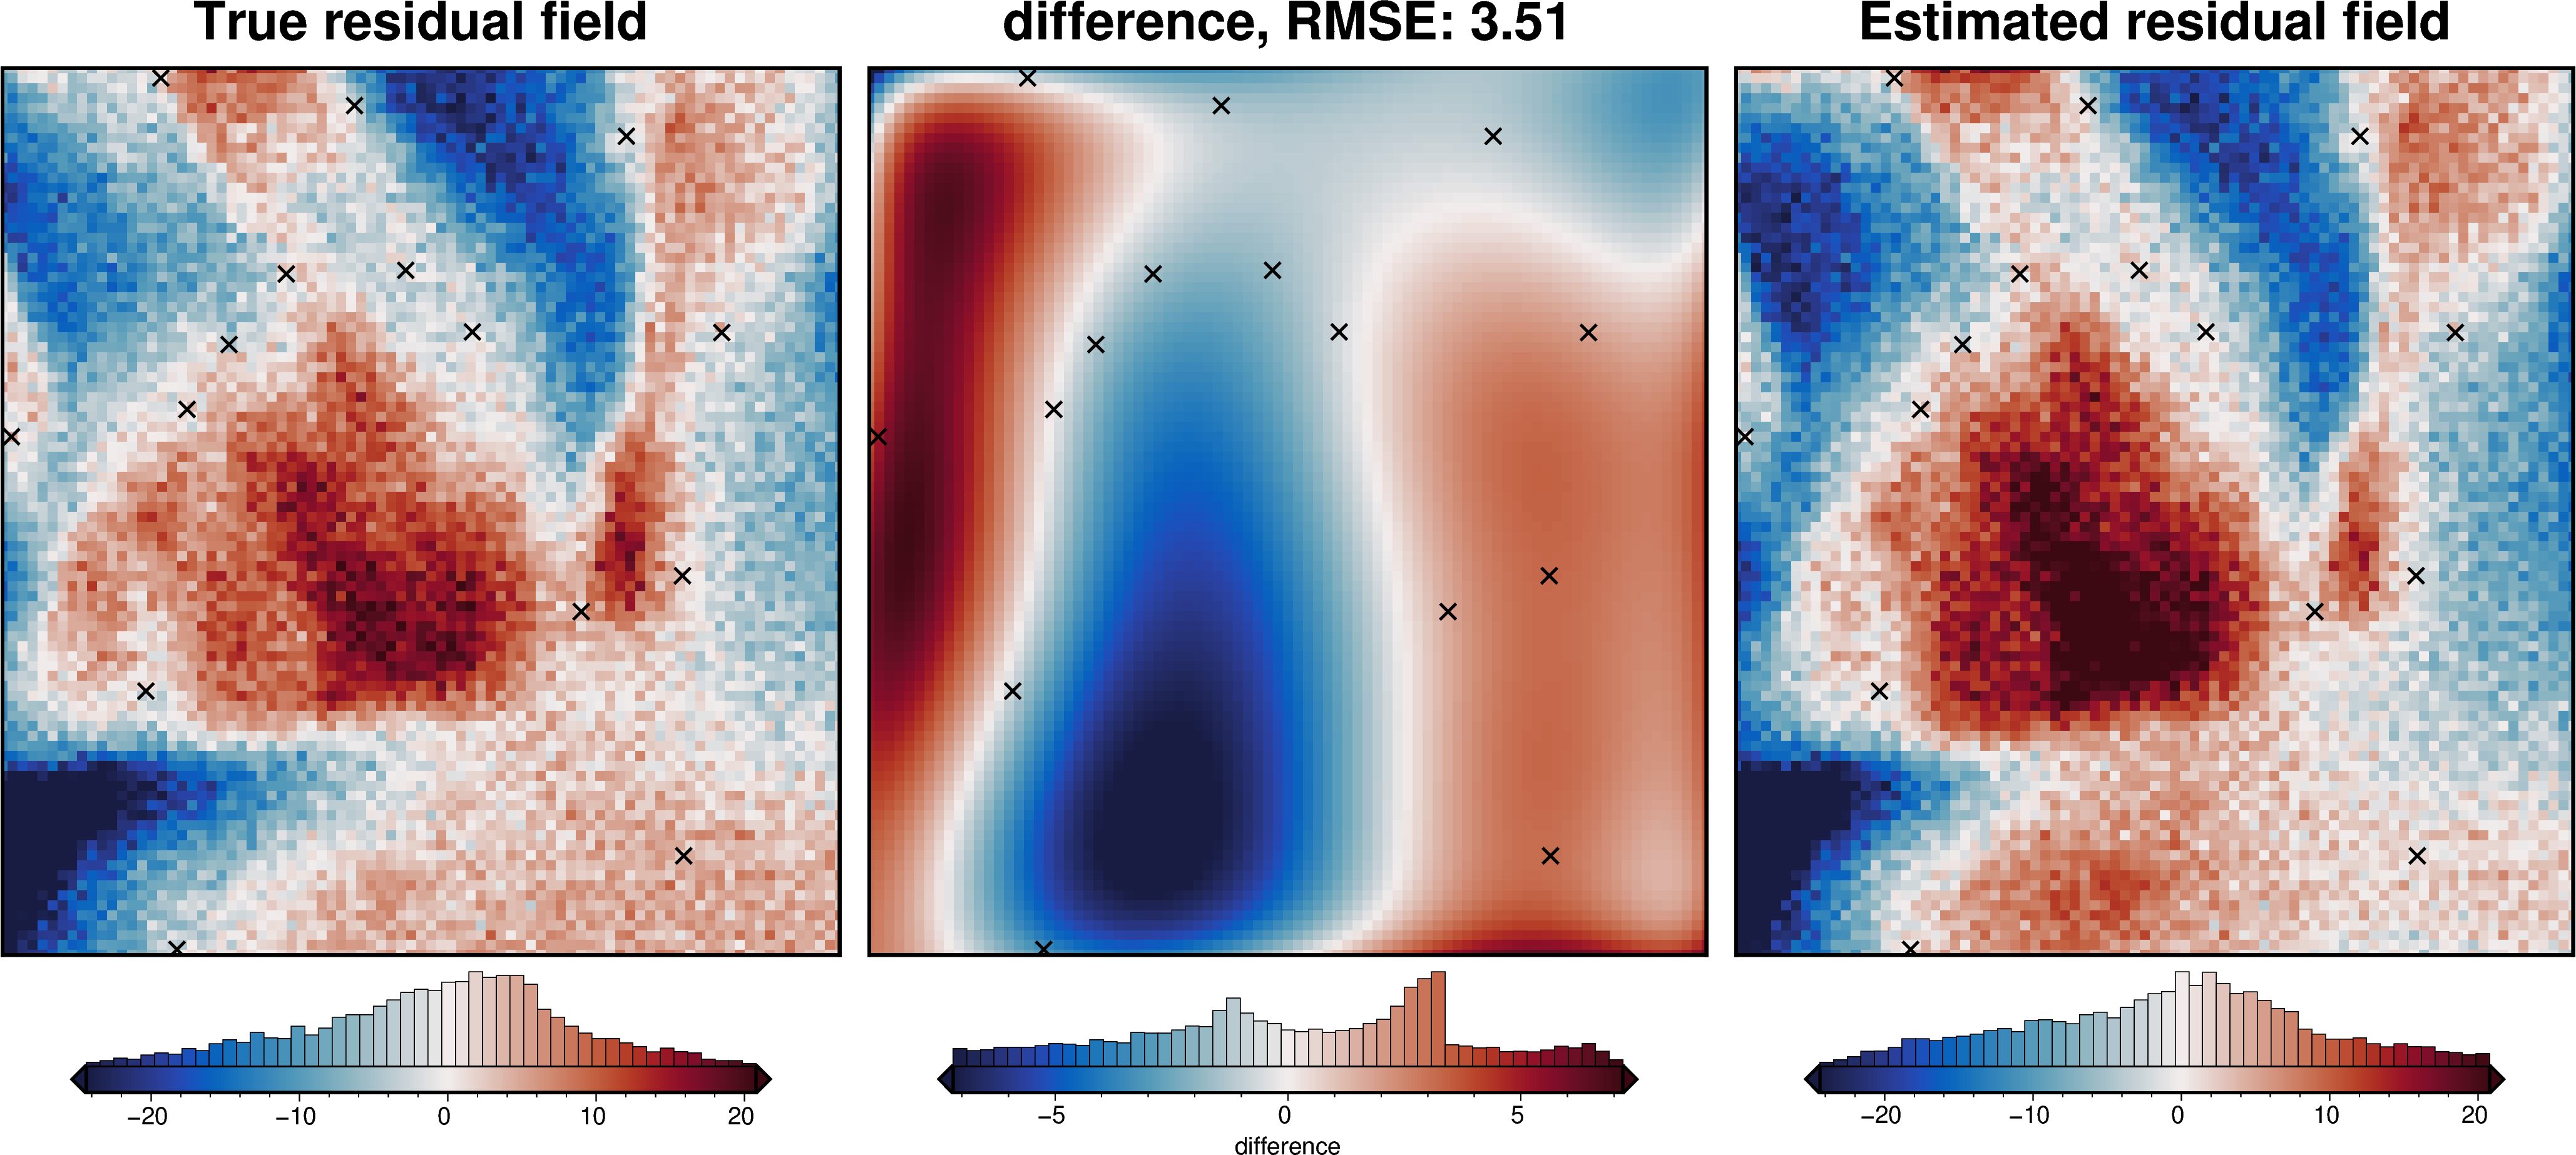

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...     trend_res  eq_sources_reg  eq_sources_res          reg  \
count  ...  7.650000e+03     7650.000000     7650.000000  7650.000000   
mean   ... -7.513734e-13       99.529885        0.078809   100.848928   
std    ...  7.005950e+00       29.887298        5.608333    27.314800   
min    ... -2.015606e+01       22.406783      -18.294135    42.105317   
25%    ... -5.089756e+00       77.708304       -3.555612    80.728989   
50%    ... -3.247819e-02      108.694621        0.084550   105.739070   
75%    ...  5.122518e+00      123.546778        3.731717   124.163015   
max    ...  3.065616e+01      146.611638       22.281547   141.669960   

       constraints_pygmt_reg  constraints_pygmt_res  constraints_verde_reg  \
count            7650.000000            7650.000000            7650.000000   
mean              101.843470              -2.234777             101.688063   
std                28.443087              10.085719              28.039639   
min                33.253517             -30.545652              34.975867   
25%                80.630211              -9.449601              81.053890   
50%               105.069168              -1.090657             106.005007   
75%               125.050148               4.841547             124.994716   
max               159.096756              24.801272             153.796027   

       constraints_verde_res  constraints_eqs_reg  constraints_eqs_res  
count            7650.000000          7650.000000          7650.000000  
mean               -2.079369           100.848928            -1.240234  
std                10.010793            27.314800            10.822615  
min               -34.421193            42.105317           -43.374690  
25%                -9.317515            80.728989            -8.159246  
50%                -1.220205           105.739070            -0.261099  
75%                 4.661532           124.163015             5.395708  
max                25.245437           141.669960            28.063042  

[8 rows x 29 columns]

In [28]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="eq_sources",
    # either automatically determine best damping
    cv=True,
    cv_kwargs=dict(
        n_trials=20,
        damping_limits=(1e-20, 1e3),
        fname="../tmp/tmp",
    ),
    # or provide a value
    # damping=1e-15,
    depth="default",
    block_size=None,
)
grav_df["constraints_eqs_reg"] = grav_df.reg
grav_df["constraints_eqs_res"] = grav_df.res

regional_comparison(grav_df, "constraints_eqs_reg")

grav_df.describe()

We can also use the function `regional.regional_separation()` and pass through the `method` and keyword args, combining all the above functions into one.

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 91.19169859399041 mGal


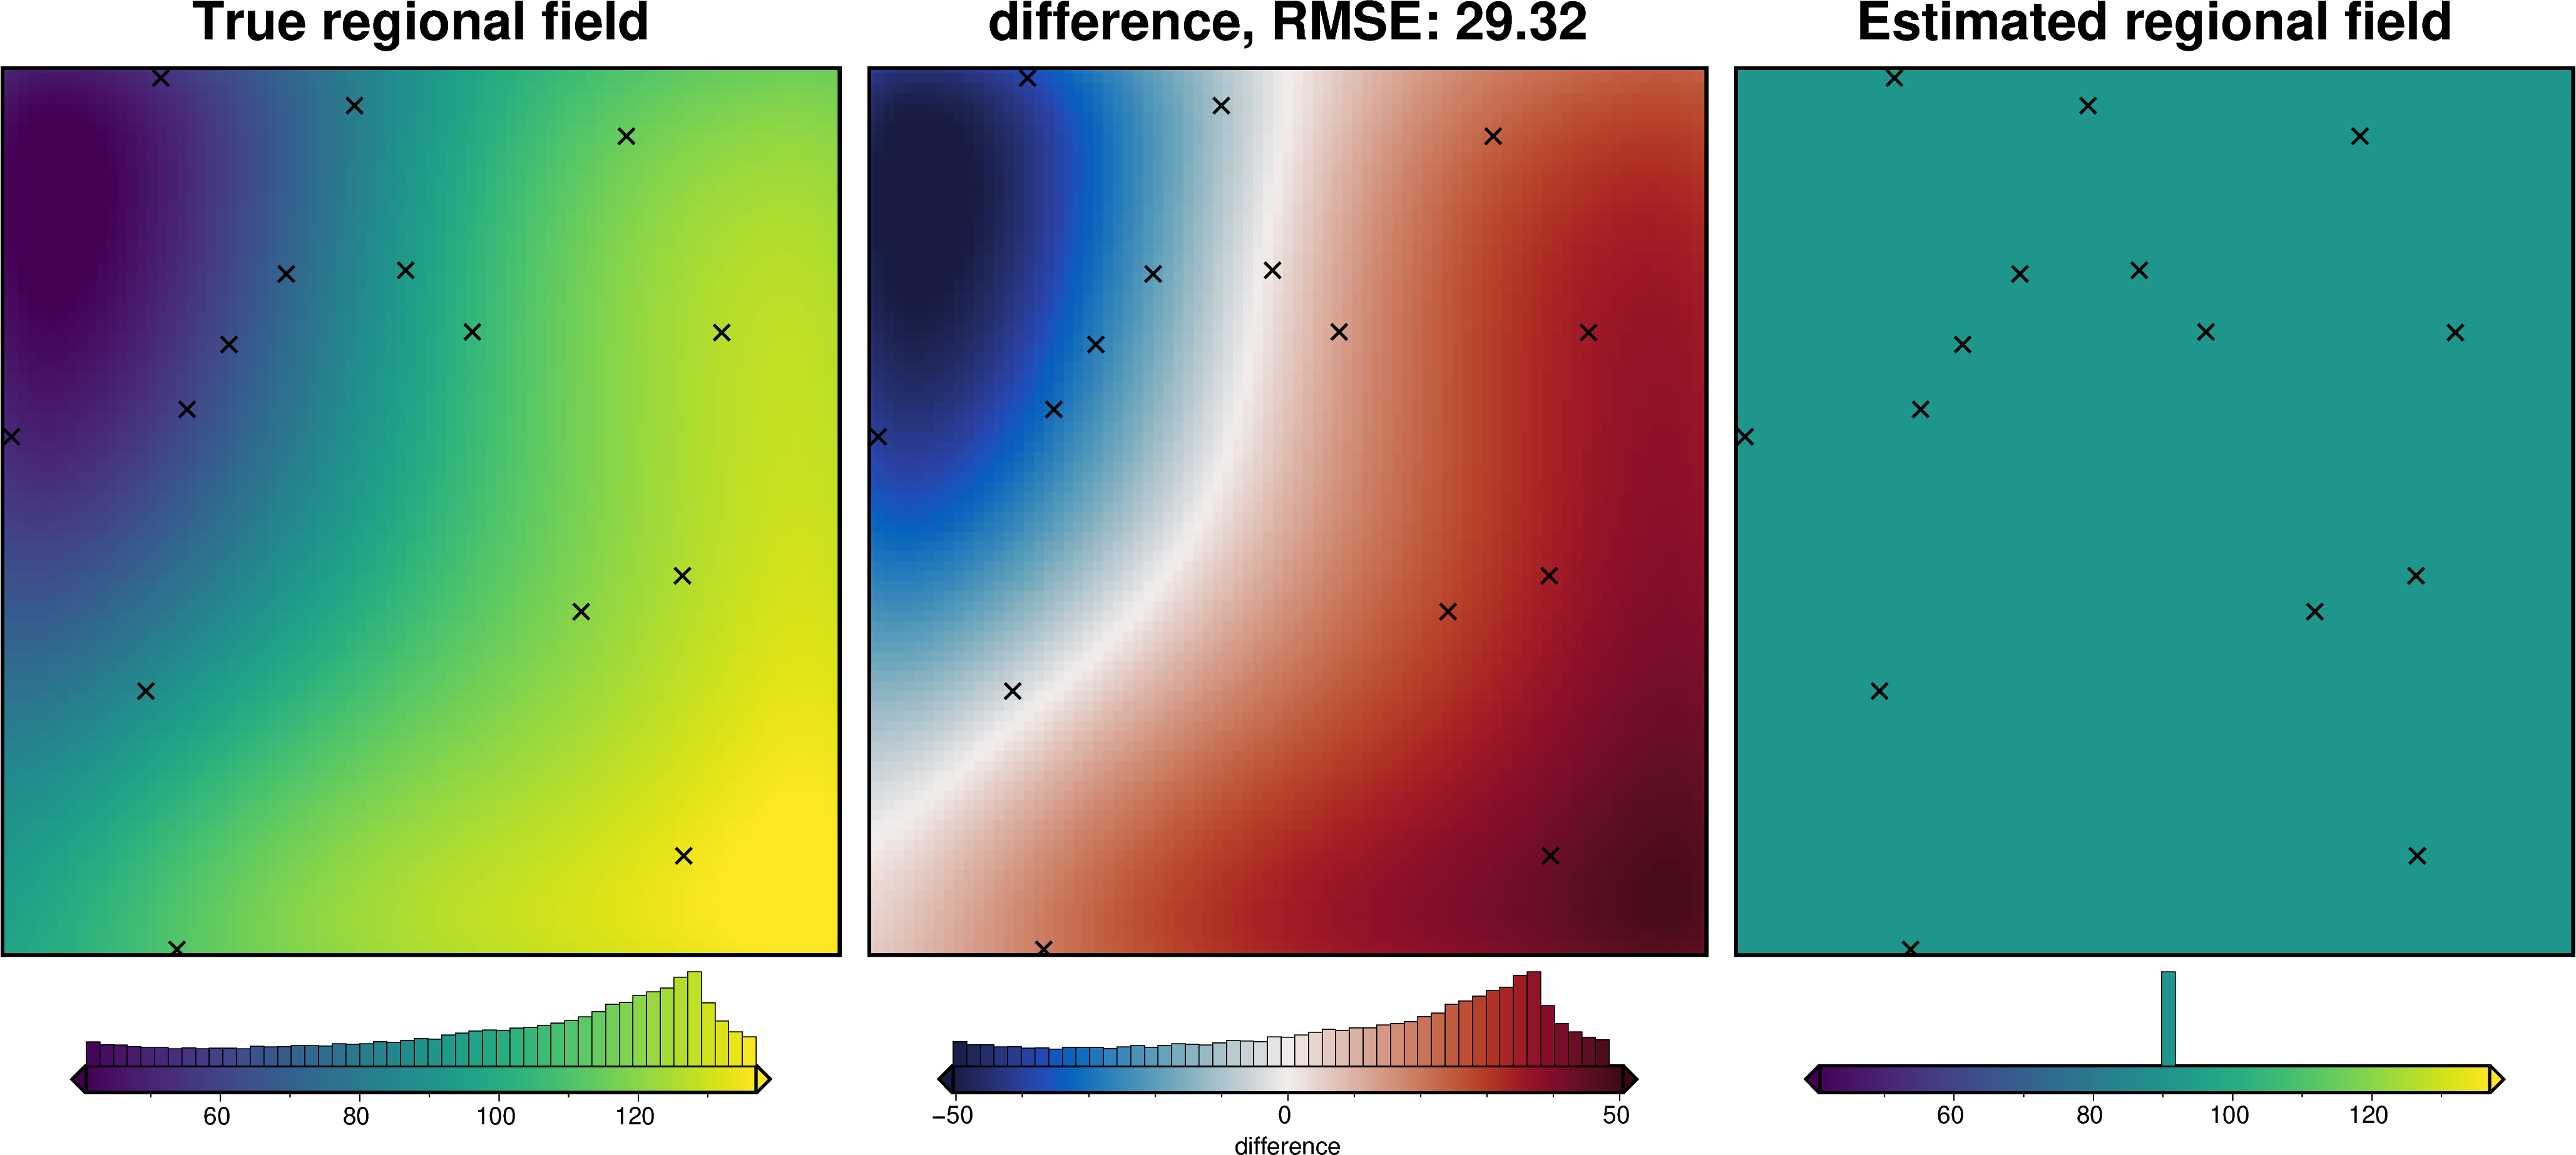

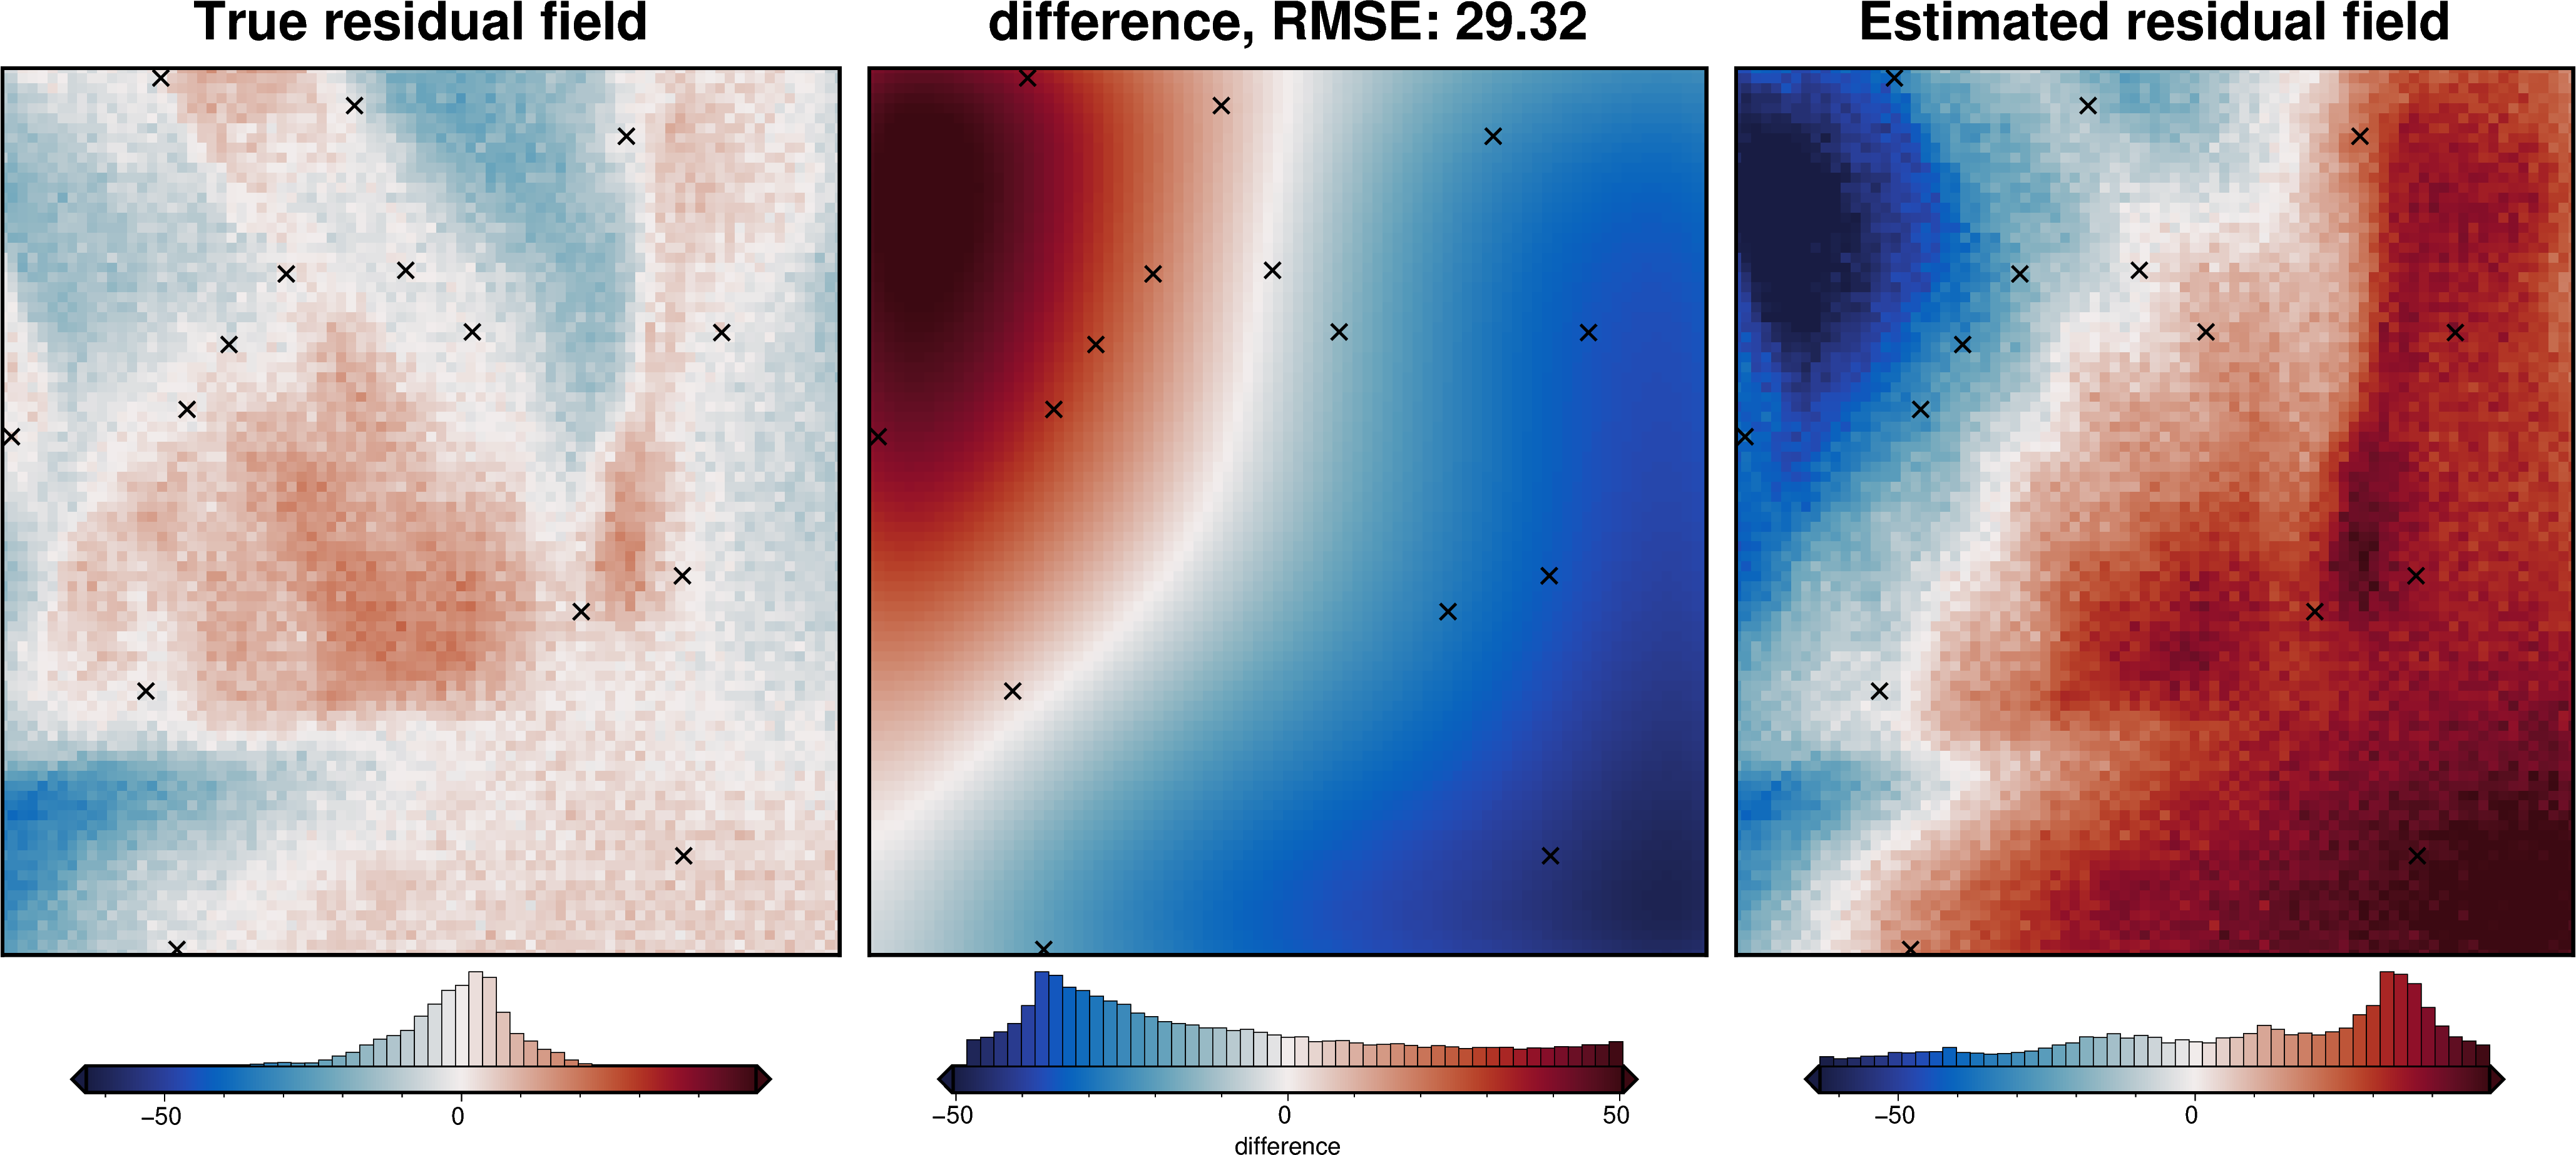

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302843   100.854428   
std    103923.425856   98149.168359     0.0      23.604988    27.683439   
min    162900.000000   23900.000000  1000.0     -33.028677    37.680354   
25%    250900.000000  107900.000000  1000.0     -18.377589    82.066231   
50%    340900.000000  191900.000000  1000.0      -4.927040   109.034686   
75%    430900.000000  275900.000000  1000.0      21.431379   123.718316   
max    518900.000000  359900.000000  1000.0      58.138421   139.560469   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157271       101.157271     2.0          1.548577    -1.245734   
std       9.703771         9.919851     0.0         24.926461     9.334160   
min      75.617509        70.861220     2.0        -36.414267   -39.698170   
25%      96.218487        96.092524     2.0        -17.408451    -6.458428   
50%     102.149812       102.057202     2.0         -3.040309    -0.024210   
75%     106.787344       107.006336     2.0         19.823536     4.763396   
max     126.329916       129.736453     2.0         59.698559    23.115665   

       ...     trend_res  eq_sources_reg  eq_sources_res           reg  \
count  ...  7.650000e+03     7650.000000     7650.000000  7.650000e+03   
mean   ... -7.513734e-13       99.529885        0.078809  9.119170e+01   
std    ...  7.005950e+00       29.887298        5.608333  1.421178e-14   
min    ... -2.015606e+01       22.406783      -18.294135  9.119170e+01   
25%    ... -5.089756e+00       77.708304       -3.555612  9.119170e+01   
50%    ... -3.247819e-02      108.694621        0.084550  9.119170e+01   
75%    ...  5.122518e+00      123.546778        3.731717  9.119170e+01   
max    ...  3.065616e+01      146.611638       22.281547  9.119170e+01   

       constraints_pygmt_reg  constraints_pygmt_res  constraints_verde_reg  \
count            7650.000000            7650.000000            7650.000000   
mean              101.843470              -2.234777             101.688063   
std                28.443087              10.085719              28.039639   
min                33.253517             -30.545652              34.975867   
25%                80.630211              -9.449601              81.053890   
50%               105.069168              -1.090657             106.005007   
75%               125.050148               4.841547             124.994716   
max               159.096756              24.801272             153.796027   

       constraints_verde_res  constraints_eqs_reg  constraints_eqs_res  
count            7650.000000          7650.000000          7650.000000  
mean               -2.079369           100.848928            -1.240234  
std                10.010793            27.314800            10.822615  
min               -34.421193            42.105317           -43.374690  
25%                -9.317515            80.728989            -8.159246  
50%                -1.220205           105.739070            -0.261099  
75%                 4.661532           124.163015             5.395708  
max                25.245437           141.669960            28.063042  

[8 rows x 29 columns]

In [29]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_separation(
    method="constant",
    grav_df=grav_df,
    constraints_df=constraint_points,
)

regional_comparison(grav_df, "reg")

grav_df.describe()

Above we just picked these hyperparameter values arbitrarily. The next [user guide](regional_field_hyperparameters.ipynb) shows a more informed technique for choosing each of these hyperparameter values.